## EDA on phagescope database

In [2]:
#pip install "dask[dataframe]" --upgrade
#pip install mkl==2021.4.0
#pip install "dask[distributed]" --upgrade
#pip install "bokeh!=3.0.*,>=2.4.2"
#pip install seaborn
#pip install dask_ml
#pip install plotly
#pip install graphviz
#pip install datashader
#pip install colorcet
import dask.dataframe as dd
import dask.array as da
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from dask_ml.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

import dask.dataframe as dd



import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select
from colorcet import fire
from functools import partial
from PIL import Image

In [2]:
from dask.distributed import Client

client = Client()
client

C:\Users\lorenzo\anaconda3\envs\esm\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55785 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:55786' processes=4 threads=16, memory=15.34 GiB>

In [29]:
# If dask needs to be shut down
client.shutdown()

In [3]:
#Load PROTEIN METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\annotated_protein_metadata\*.tsv'  # Use * to select all TSV files in the folder
folder_path = folder_path.replace(os.sep, '/')
# Load all TSV files into a single Dask DataFrame
start = time.time()
ddf = dd.read_csv(folder_path, sep='\t', dtype={'Instability_index': 'object',
       'Molecular_weight': 'object'})

# Some rows in Instability_index and Molecular_weight have non numeric (float64) values
# i load tose columns as objects then locate the non numeric rows

print("elapsed time: " +  str(time.time() - start))

# Optionally, print the first few rows (this won't trigger computation yet)
(ddf.head())



elapsed time: 0.12016606330871582


Phage_ID Protein_source Function_Prediction_source  Start  \
0  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper    319   
1  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper   1062   
2  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper   1398   
3  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper   1718   
4  SRS101376_a1_ct99314_vs01       prodigal                          -   2145   

   Stop Strand                   Protein_ID  \
0  1062      -  SRS101376_a1_ct99314_vs01_1   
1  1385      -  SRS101376_a1_ct99314_vs01_2   
2  1718      -  SRS101376_a1_ct99314_vs01_3   
3  2155      -  SRS101376_a1_ct99314_vs01_4   
4  2276      -  SRS101376_a1_ct99314_vs01_5   

                                  Product Protein_classification  \
0      N-acetylmuramoyl-L-alanine amidase              unsorted;   
1                    hypothetical protein          hypothetical;   
2  Psort location Cytoplasmic, score 8.87              assembly;   
3                    hypothetical protein          hypothetical;   
4                                 unknown              unsorted;   

    Molecular_weight  Aromaticity   Instability_index  Isoelectric_point  \
0          4186.6396     0.054054   22.98918918918919           5.664426   
1           3630.987     0.027027  0.9459459459459463           4.427894   
2  3685.323799999999     0.027778  23.205555555555563          11.000385   
3            623.652     0.200000               56.22           4.050028   
4  4829.349899999999     0.046512   52.20232558139535           4.827017   

   Helix_fraction  Turn_fraction  Sheet_fraction  Reduced_coefficient  \
0        0.270270       0.081081        0.405405                 2980   
1        0.216216       0.162162        0.405405                 1490   
2        0.388889       0.250000        0.277778                 5500   
3        0.400000       0.000000        0.400000                    0   
4        0.186047       0.069767        0.511628                 2980   

   Oxidized_coefficient Phage_source  
0                  2980         CHVD  
1                  1490         CHVD  
2                  5500         CHVD  
3                     0         CHVD  
4                  2980         CHVD

In [5]:
(ddf['Strand']).value_counts().compute()

Strand
-    21485255
+    21603327
Name: count, dtype: int64

In [159]:
# Count proteins per category

# Compute the value counts for the "Protein_classification" column
start = time.time()
value_counts = ddf['Protein_classification'].value_counts().compute()
print("elapsed time: " +  str(time.time() - start))

# Display the number of categories
num_categories = value_counts.index.size
print(f"Number of categories: {num_categories}")

# Display the count of items in each category
print("Counts of each category:")
print(value_counts.to_string())



2024-09-30 18:06:45,056 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cc40e006ad3748915f5aaca313713b12 initialized by task ('shuffle-transfer-cc40e006ad3748915f5aaca313713b12', 24) executed on worker tcp://127.0.0.1:61327
2024-09-30 18:07:21,954 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cc40e006ad3748915f5aaca313713b12 deactivated due to stimulus 'task-finished-1727712441.9412565'


elapsed time: 38.51831102371216
Number of categories: 144
Counts of each category:
Protein_classification
integration;tRNA_related;immune;                                        293
lysis;tRNA_related;packaging;                                           125
integration;infection;                                                20464
immune;                                                              677629
integration;replication;infection;                                       48
tRNA_related;                                                         73114
lysis;integration;replication;regulation;                                33
tRNA_related;infection;                                                7989
integration;regulation;                                               17675
tRNA_related;immune;                                                  27024
integration;                                                        1038873
integration;replication;assembly;                         

In [91]:
# Count standalone categories 

# Split the "Protein_classification" column into multiple rows
split_df = ddf['Protein_classification'].str.split(';').explode()

# Remove any empty strings that might result from splitting
split_df = split_df[split_df != '']

# Compute the value counts for each individual category
value_counts = split_df.value_counts().compute()

# Display the number of unique categories
num_categories = value_counts.index.size
print(f"Number of unique categories: {num_categories}")

# Display the count of items in each category
print("Counts of each category:")
print(value_counts)

2024-09-15 18:57:13,381 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 813a9bb2a471392f2ea08cbdb4bf392a initialized by task ('shuffle-transfer-813a9bb2a471392f2ea08cbdb4bf392a', 99) executed on worker tcp://127.0.0.1:52869
2024-09-15 18:58:30,026 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 813a9bb2a471392f2ea08cbdb4bf392a deactivated due to stimulus 'task-finished-1726419509.9949925'


Number of unique categories: 11
Counts of each category:
Protein_classification
infection        3265957
unsorted        23711399
tRNA_related      158824
integration      1353481
replication      3348996
packaging        1715732
hypothetical     3782577
lysis            1601680
assembly         4826695
immune            790813
regulation       1955263
Name: count, dtype: int64


In [32]:
print('total n. of proteins:')
print(ddf.shape[0].compute())

43088582

In [92]:
print('infection related protein %: ')
(3265957/43088582)*100

infection related protein %: 


7.579634437726448

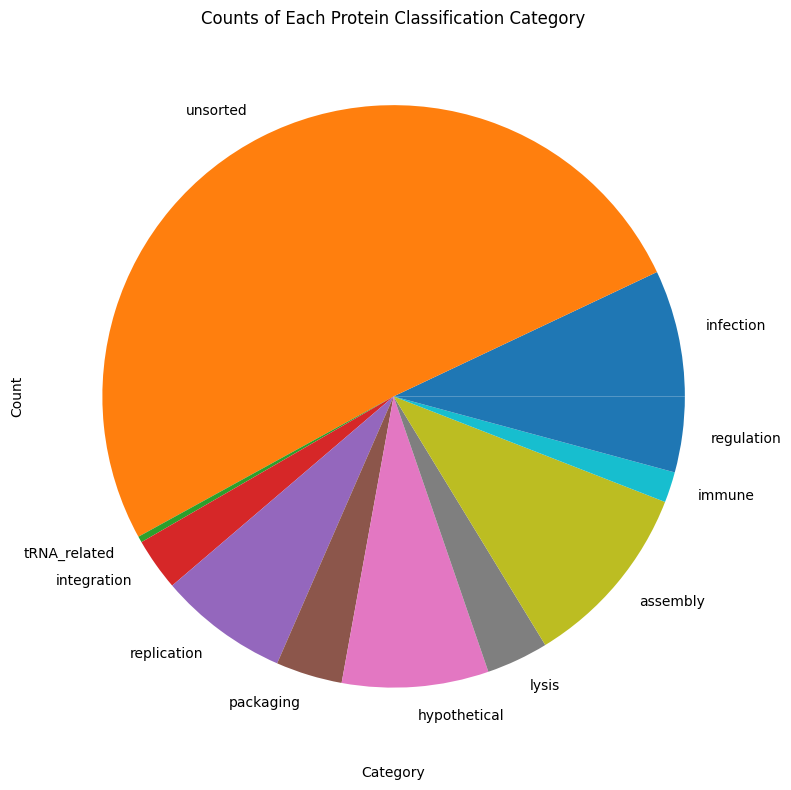

In [93]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 8))
value_counts.plot(kind='pie')

plt.title('Counts of Each Protein Classification Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.savefig('protein_categories.tif', format='TIFF')
plt.show()


In [161]:
# How many proteins per phage

protein_counts = ddf.groupby('Phage_ID')['Protein_ID'].size().compute()

protein_counts

2024-09-30 18:17:34,567 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8a4060c896ae418f25db5af69f42ef88 initialized by task ('shuffle-transfer-8a4060c896ae418f25db5af69f42ef88', 11) executed on worker tcp://127.0.0.1:61330
2024-09-30 18:18:19,367 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8a4060c896ae418f25db5af69f42ef88 deactivated due to stimulus 'task-finished-1727713099.3616443'


Phage_ID
SAMEA1906418_a1_ct14483         12
SAMEA1906424_a1_ct107971_vs1    52
SAMEA1906425_a1_ct151137_vs1    19
SAMEA1906427_a1_ct202002_vs1    46
SAMEA1906427_a1_ct252687_vs1    12
                                ..
TemPhD_cluster_993              14
TemPhD_cluster_9933             56
TemPhD_cluster_9977             22
TemPhD_cluster_998              14
TemPhD_cluster_9989             23
Name: Protein_ID, Length: 873679, dtype: Int64

In [96]:
print('mean proteins per phage:')
print(protein_counts.mean())
print('std:')
print(protein_counts.std())
print('\n\n')
print('max proteins per phage:')
print(protein_counts.nlargest())
print('\n')
print('min proteins per phage:')
print(protein_counts.nsmallest())


mean proteins per phage:
49.31855063472969
std:
37.98446711943007



max proteins per phage:
Phage_ID
IMGVR_UViG_3300045988_166570|3300045988|Ga0495776_117200      844
MGV-GENOME-0380271                                            836
IMGVR_UViG_3300028920_000022|3300028920|Ga0272441_10000008    723
NC_042013.1                                                   714
JN638751.1                                                    677
Name: Protein_ID, dtype: Int64


min proteins per phage:
Phage_ID
SAMN01915224_a1_ct139211_vs1                               1
uvig_180383                                                1
uvig_575436                                                1
uvig_580878                                                1
Han_2018_ERR1398154_NODE_3615_length_5748_cov_13.689268    1
Name: Protein_ID, dtype: Int64


<Axes: ylabel='Frequency'>

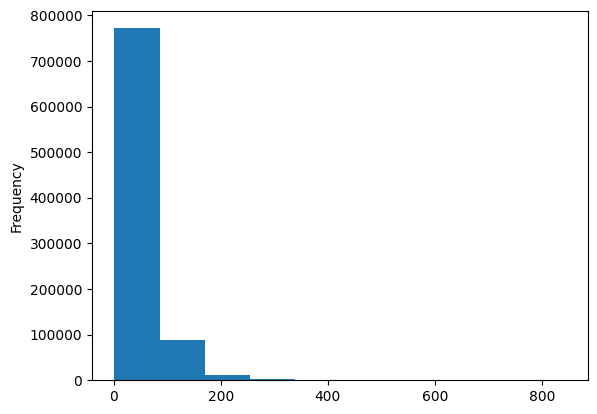

In [169]:
protein_counts.plot.hist()

<Axes: xlabel='Protein_ID', ylabel='Density'>

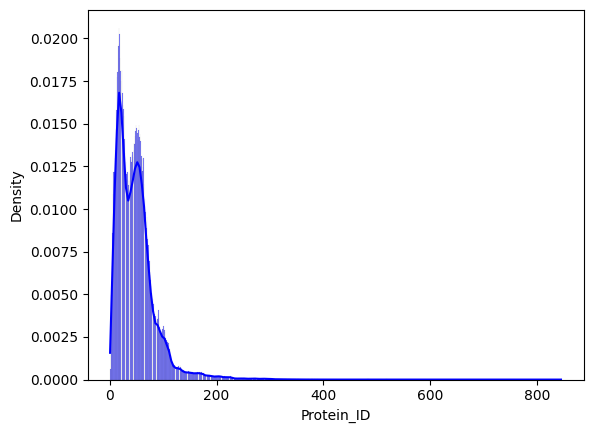

In [168]:
sns.histplot(protein_counts, kde=True, color='blue', stat="density")

2024-09-30 18:23:01,806 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:61336 (pid=7660) exceeded 95% memory budget. Restarting...
2024-09-30 18:23:01,822 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:61336' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('repartitiontofewer-a84ae207c2e24791010e6f7394c844a8', 0)} (stimulus_id='handle-worker-cleanup-1727713381.8259997')
2024-09-30 18:23:01,837 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-a84ae207c2e24791010e6f7394c844a8', 0): 'waiting'}
2024-09-30 18:23:01,853 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-a84ae207c2e24791010e6f7394c844a8', 0),)
2024-09-30 18:23:02,490 - distributed.nanny - WARNING - Restarting worker
2024-09-30 18:23:39,216 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:61331 (pid=6736) exceeded 95% memory budget. Restarting...
2024-09-30 18:23:39,2

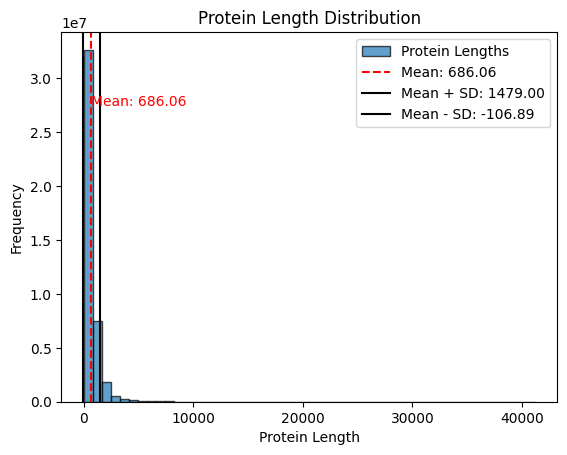

In [166]:
# Protein length distribution
ddf['Protein_length'] = ddf['Stop'] - ddf['Start']

# Compute the distribution (e.g., histogram)
length_distribution = ddf['Protein_length'].compute()

mean_length = length_distribution.mean()
std_length = length_distribution.std()

# Plot the histogram
plt.hist(length_distribution, bins=50, edgecolor='black', alpha=0.7, label='Protein Lengths')

# Add vertical lines for mean, mean + std, and mean - std
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(mean_length + std_length, color='black', label=f'Mean + SD: {mean_length + std_length:.2f}')
plt.axvline(mean_length - std_length, color='black', label=f'Mean - SD: {mean_length - std_length:.2f}')

# Add text for the mean
plt.text(mean_length, plt.ylim()[1] * 0.8, f'Mean: {mean_length:.2f}', color='red', ha='left')

# Labels and title
plt.xlabel('Protein Length')
plt.ylabel('Frequency')
plt.title('Protein Length Distribution')

# Add a legend
plt.legend()

# Show the plot
plt.show()

(0.0, 5000.0)

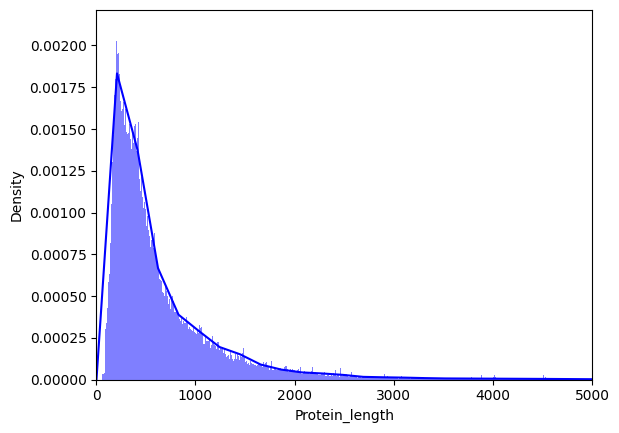

In [171]:
sns.histplot(length_distribution, kde=True, color='blue', stat="density")
plt.xlim([0,5000])

In [167]:
std_length

792.9412732837968

In [105]:
# TRY to PCA on all the proteins

# Some rows in Instability_index and Molecular_weight have non numeric (float64) values
# i loaded those columns as objects, now i locate the non numeric rows

# this block checks whether each value in the columns Instability_index and 
# Molecular_weight can be converted to a numeric type. 
# If not, the corresponding row is retained.

# This block needs to be run twice, the second time the error disappears



def find_non_numeric(df):
    # Identify non-numeric values in the 'Instability_index' and 'Molecular_weight' columns
    mask = (~pd.to_numeric(df['Molecular_weight'], errors='coerce').notna()) | \
           (~pd.to_numeric(df['Instability_index'], errors='coerce').notna())
    return df[mask]

# Apply the function to the Dask DataFrame
non_numeric_ddf = ddf.map_partitions(find_non_numeric)

ddf             = ddf.rename(columns={'Function_Prediction_source': 'Function_prediction_source'})              # altrimenti dà errore
non_numeric_ddf = non_numeric_ddf.rename(columns={'Function_Prediction_source': 'Function_prediction_source'})  # altrimenti dà errore

# Extract the index values where the condition holds
non_numeric_indices = non_numeric_ddf.index.compute()

# Display the indices
print('non_numeric_indices: ')
print(non_numeric_indices)

non_numeric_indices: 
Index([   272,  94331,  94416,  94508,  94630,  97179,  97248,  97301,  97306,
        97477,
       ...
        96826,  96840,  97005,  97011,  97161, 101706, 107634, 111703, 136740,
       232802],
      dtype='int64', length=66391)


In [106]:

# Remove the 63k rows with non float64 values

rows_to_remove_set = set(non_numeric_indices)

def filter_rows(df_partition, rows_to_remove_set):
    return df_partition[~df_partition.index.isin(rows_to_remove_set)]

# Apply the filtering function
filtered_df = ddf.map_partitions(filter_rows, rows_to_remove_set, meta=ddf)

#filtered_df.head()

In [108]:
from dask_ml.preprocessing import StandardScaler

# Select the 9 columns
columns = ['Molecular_weight', 'Aromaticity', 'Instability_index', 'Isoelectric_point', 'Helix_fraction', 'Turn_fraction', 'Sheet_fraction', 'Reduced_coefficient', 'Oxidized_coefficient']
#columns = ['Helix_fraction', 'Turn_fraction', 'Sheet_fraction']
X = filtered_df[columns]


In [109]:
# Check that filtered_df has only numericals


non_numeric_filtered_df = X.map_partitions(find_non_numeric)

#ddf             = ddf.rename(columns={'Function_Prediction_source': 'Function_prediction_source'})              # altrimenti dà errore
#non_numeric_ddf = non_numeric_ddf.rename(columns={'Function_Prediction_source': 'Function_prediction_source'})  # altrimenti dà errore

# Extract the index values where the condition holds
non_numeric_indices_filtered = non_numeric_filtered_df.index.compute()

# Display the indices
print(non_numeric_indices_filtered)

RangeIndex(start=0, stop=0, step=1)


In [110]:
#X.head()
#X.shape[0].visualize()
X.dtypes

Molecular_weight        string[pyarrow]
Aromaticity                     float64
Instability_index       string[pyarrow]
Isoelectric_point               float64
Helix_fraction                  float64
Turn_fraction                   float64
Sheet_fraction                  float64
Reduced_coefficient               int64
Oxidized_coefficient              int64
dtype: object

In [111]:
X = X.astype({'Molecular_weight': 'float64', 'Instability_index': 'float64', 'Reduced_coefficient': 'float64', 'Oxidized_coefficient': 'float64'})
X.dtypes

Molecular_weight        float64
Aromaticity             float64
Instability_index       float64
Isoelectric_point       float64
Helix_fraction          float64
Turn_fraction           float64
Sheet_fraction          float64
Reduced_coefficient     float64
Oxidized_coefficient    float64
dtype: object

In [44]:
# Standardize the data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled.head()

NameError: name 'StandardScaler' is not defined

In [113]:
# takes a very long time to run

from sklearn.decomposition import IncrementalPCA

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=2, batch_size = 10000)

# Convert to Dask array
#scaled_data_dsk = scaled_data.to_dask_array(lengths=True)

# Convert Dask DataFrame to a Dask array
scaled_data_dsk = X_scaled.to_dask_array(lengths=True)

# Fit IncrementalPCA in chunks
for chunk in np.array_split(scaled_data_dsk.compute(), len(scaled_data_dsk) // 50000):
    ipca.partial_fit(chunk)

# Transform the data
X_pca = []
for chunk in np.array_split(scaled_data_dsk.compute(), len(scaled_data_dsk) // 50000):
    X_pca.append(ipca.transform(chunk))

# Convert the list of arrays back to a Dask array
X_pca_dask = da.from_array(np.concatenate(X_pca, axis=0), chunks=(50000, 2)) # da is dask.array


In [114]:
ipca.explained_variance_

array([2.69925113, 1.46682112])

In [115]:
#X_pca
X_pca_dask.shape

(33032600, 2)

C:\Users\lorenzo\anaconda3\envs\esm\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 504.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


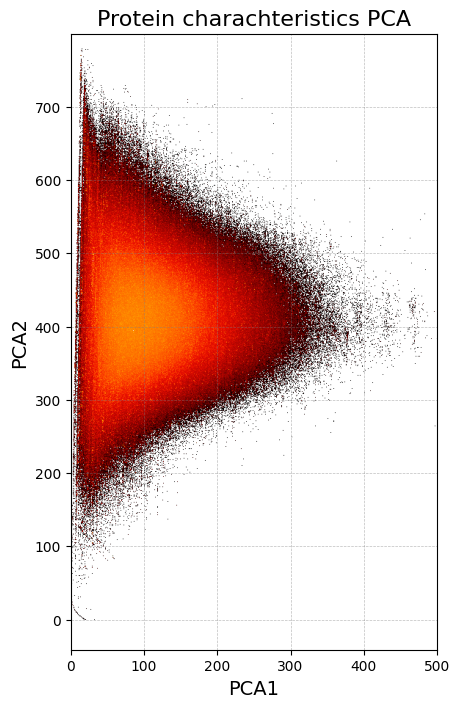

Explained variance: [2.69925113 1.46682112]


In [117]:

dask_df = dd.from_dask_array(X_pca_dask, columns=['PCA1', 'PCA2'])

def plot_dask_df(dask_df):
    # Compute a sample or the full DataFrame if possible
    df = dask_df.compute()
    loadings = ipca.components_.T * np.sqrt(ipca.explained_variance_)
    # Create a canvas
    canvas = ds.Canvas(plot_width=800, plot_height=800)
    
    # Aggregate the data
    agg = canvas.points(df, 'PCA1', 'PCA2')


    # Create the plot
    img = tf.shade(agg, cmap= fire, how='log')

    pil_img = img.to_pil()
    #pil_img = Image.fromarray(img.to_pil().convert('RGB'))  # Ensure conversion to RGB format
    
    # Plot using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 8))
    # Display the image
    ax.imshow(pil_img, origin='lower')

    
    ax.set_xlim(0,500)
    
    #ax.set_ylim(350, 450)
    
    # Add title and labels
    ax.set_title('Protein charachteristics PCA', fontsize=16)
    ax.set_xlabel('PCA1', fontsize=14)
    ax.set_ylabel('PCA2', fontsize=14)
    
    # Add grid
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha = 0.5)

    for i in range(loadings.shape[0]):
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.2, head_length=0.3, color='red')


    fig.savefig('protein_pca_plot.tif', format='TIFF')
    
    # Show the plot
    plt.show()
    
    # Display the plot
    return img

# Plot
plot = plot_dask_df(dask_df)

print("Explained variance:", ipca.explained_variance_)
# Save
#plot.savefig('protein_pca_plot.tif', format='TIFF')

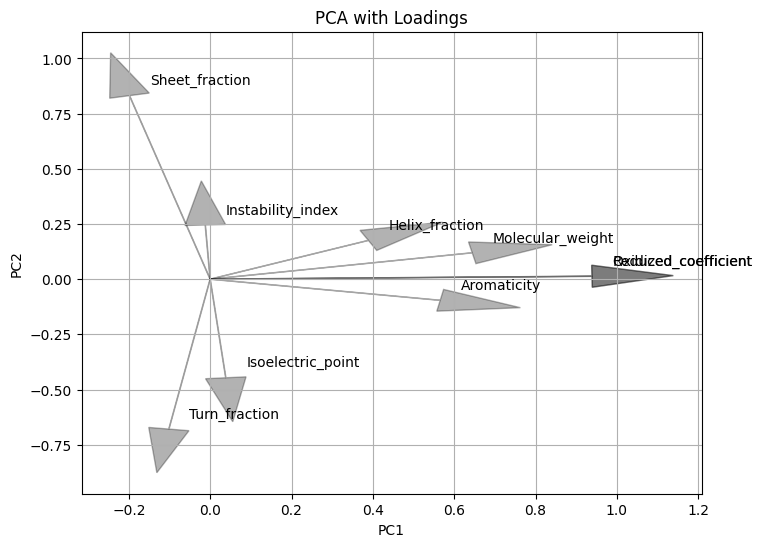

In [118]:
# Get the loadings
loadings = ipca.components_.T * np.sqrt(ipca.explained_variance_)
features = ['Molecular_weight', 'Aromaticity', 'Instability_index', 'Isoelectric_point', 'Helix_fraction', 'Turn_fraction', 'Sheet_fraction', 'Reduced_coefficient', 'Oxidized_coefficient']

# Create the plot
plt.figure(figsize=(8, 6))
#plt.scatter(X_pca_dask[:, 0], X_pca_dask[:, 1], alpha=0.5)

# Plot the arrows with column names
for i in range(loadings.shape[0]):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.1, head_length=0.2, color='black', alpha = 0.3)
    plt.text(loadings[i, 0] + 0.05, loadings[i, 1] + 0.05, features[i], fontsize=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA with Loadings")
plt.grid(True)
fig.savefig('protein_pca_loadings.tif', format='TIFF')
plt.show()

# Phage and hosts diversity

In [7]:
#Load PHAGE METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\phage_metadata\*.tsv'  # Use a wildcard to select all TSV files
folder_path = folder_path.replace(os.sep, '/')
# Load all TSV files into a single Dask DataFrame
#start = time.time()
phage_metadata = dd.read_csv(folder_path, sep='\t')

#print("elapsed time: " +  str(time.time() - start))

# Optionally, print the first few rows (this won't trigger computation yet)
phage_metadata.head()



Phage_ID  Length  GC_content      Taxonomy  \
0     SRS101376_a1_ct99314_vs01   31763   50.511602    Myoviridae   
1     SRS101388_a1_ct42327_vs01  223331   42.421339    Myoviridae   
2     SRS101376_a1_ct26874_vs01   25835   52.897232    Myoviridae   
3       SAMEA1906416_a1_ct13001   53468   40.515823  Siphoviridae   
4  SAMEA1906416_a1_ct130485_vs1   23523   61.658802  Siphoviridae   

     Completeness             Host Lifestyle         Cluster  \
0    High-quality         Gemmiger  virulent   cluster_33392   
1    High-quality        Neisseria  virulent  cluster_340704   
2     Low-quality                -  virulent  cluster_208857   
3    High-quality  Lachnospiraceae  virulent  cluster_243648   
4  Medium-quality  Bifidobacterium  virulent   cluster_44056   

          Subcluster Phage_source  
0   subcluster_40629         CHVD  
1  subcluster_411447         CHVD  
2  subcluster_251798         CHVD  
3  subcluster_294650         CHVD  
4   subcluster_53753         CHVD

In [11]:
ddf[ddf['Phage_ID'] == 'SAMN06165378_a1_ct762_vs1'].compute()

Phage_ID Protein_source Function_Prediction_source  \
247582  SAMN06165378_a1_ct762_vs1       prodigal              eggNOG-mapper   
247583  SAMN06165378_a1_ct762_vs1       prodigal                          -   
247584  SAMN06165378_a1_ct762_vs1       prodigal              eggNOG-mapper   

        Start  Stop Strand                   Protein_ID     Product  \
247582     77  1735      -  SAMN06165378_a1_ct762_vs1_1  GO:0039694   
247583   1772  2158      -  SAMN06165378_a1_ct762_vs1_2     unknown   
247584   2158  3507      -  SAMN06165378_a1_ct762_vs1_3      virion   

       Protein_classification   Molecular_weight  Aromaticity  \
247582              unsorted;  7305.129099999999     0.129032   
247583              unsorted;  6357.163100000002     0.051724   
247584             infection;  3412.040000000001     0.137931   

        Instability_index  Isoelectric_point  Helix_fraction  Turn_fraction  \
247582  51.30645161290321           7.124449        0.322581       0.290323   
247583  32.54827586206896           4.996057        0.379310       0.189655   
247584  26.46931034482759          11.592334        0.379310       0.206897   

        Sheet_fraction  Reduced_coefficient  Oxidized_coefficient Phage_source  
247582        0.241935                26470                 26470         CHVD  
247583        0.241379                 8480                  8480         CHVD  
247584        0.275862                 2980                  2980         CHVD

In [9]:
phage_metadata[phage_metadata['Taxonomy' ] == 'Leviviridae'].compute()

Phage_ID  Length  GC_content     Taxonomy  \
18168    SAMN06165378_a1_ct762_vs1    3591   53.856864  Leviviridae   
18185  SAMN06165444_a1_ct17052_vs1    2383   44.355854  Leviviridae   
18230    SAMN06165623_a1_ct676_vs1    3902   46.899026  Leviviridae   

         Completeness Host Lifestyle         Cluster         Subcluster  \
18168    High-quality    -  virulent  cluster_410912  subcluster_496251   
18185  Medium-quality    -  virulent   cluster_77149   subcluster_93479   
18230    High-quality    -  virulent  cluster_207925  subcluster_250701   

      Phage_source  
18168         CHVD  
18185         CHVD  
18230         CHVD

In [5]:
phage_metadata = phage_metadata.compute()

In [170]:
ddf.dtypes

Phage_ID                      string[pyarrow]
Protein_source                string[pyarrow]
Function_prediction_source    string[pyarrow]
Start                                   int64
Stop                                    int64
Strand                        string[pyarrow]
Protein_ID                    string[pyarrow]
Product                       string[pyarrow]
Protein_classification        string[pyarrow]
Molecular_weight              string[pyarrow]
Aromaticity                           float64
Instability_index             string[pyarrow]
Isoelectric_point                     float64
Helix_fraction                        float64
Turn_fraction                         float64
Sheet_fraction                        float64
Reduced_coefficient                     int64
Oxidized_coefficient                    int64
Phage_source                  string[pyarrow]
Protein_length                          int64
dtype: object

In [70]:
phage_metadata.dtypes

Phage_ID        string[pyarrow]
Length                    int64
GC_content              float64
Taxonomy        string[pyarrow]
Completeness    string[pyarrow]
Host            string[pyarrow]
Lifestyle       string[pyarrow]
Cluster         string[pyarrow]
Subcluster      string[pyarrow]
Phage_source    string[pyarrow]
dtype: object

In [65]:
#phage_metadata = phage_metadata.astype({'Taxonomy': 'string', 'Phage_source': 'string'})
phage_metadata['Taxonomy'] = phage_metadata['Taxonomy'].astype('string')
phage_metadata['Phage_source'] = phage_metadata['Phage_source'].astype('string')


In [188]:
phage_metadata['Phage_source'].value_counts()

Phage_source
<NA>      441637
GOV2      195699
IMG_VR    177361
CHVD       44935
IGVD       10021
STV         4065
Name: count, dtype: Int64

In [36]:
phage_metadata[phage_metadata['Phage_source'] =='IGVD' ] ['Taxonomy'].value_counts()

Taxonomy
Anelloviridae     970
Alpaviridae       476
Gokushoviridae    439
Amandaviridae     279
Jeppeviridae      274
                 ... 
Claraviridae        2
Veraviridae         2
Jamieviridae        1
Julianviridae       1
Luiviridae          1
Name: count, Length: 246, dtype: int64

In [6]:
phage_metadata[phage_metadata['Phage_source'] =='STV' ] 

Phage_ID  Length  GC_content        Taxonomy    Completeness  \
0        biochar_0  259025   27.793842  Caudoviricetes        Complete   
1        biochar_1  246933   57.337820  Caudoviricetes        Complete   
2        biochar_2  153522   67.663267  Caudoviricetes        Complete   
3        biochar_3  153521   67.650028  Caudoviricetes        Complete   
4        biochar_4  153377   67.863500  Caudoviricetes        Complete   
...            ...     ...         ...             ...             ...   
4060  biochar_6173   10017   65.768194  Caudoviricetes  Not-determined   
4061  biochar_6175   10016   63.837859  Caudoviricetes     Low-quality   
4062  biochar_6178   10011   65.168315  Caudoviricetes     Low-quality   
4063  biochar_6180   10008   59.102718  Caudoviricetes     Low-quality   
4064  biochar_6181   10006   71.017390  Caudoviricetes     Low-quality   

                            Host  Lifestyle         Cluster  \
0          Clostridium botulinum  temperate  cluster_519859   
1     Mycobacterium tuberculosis   virulent  cluster_151320   
2        Mycobacterium smegmatis  temperate   cluster_47933   
3        Mycobacterium smegmatis   virulent   cluster_47933   
4           Corynebacterium equi   virulent  cluster_164678   
...                          ...        ...             ...   
4060     Pseudomonas fluorescens   virulent  cluster_402067   
4061       Klebsiella pneumoniae   virulent   cluster_66332   
4062  Mycobacterium tuberculosis  temperate  cluster_292651   
4063      Sinorhizobium meliloti   virulent   cluster_60145   
4064       Salinispora arenicola  temperate  cluster_364871   

             Subcluster Phage_source  
0     subcluster_625991          STV  
1     subcluster_182552          STV  
2      subcluster_58583          STV  
3      subcluster_58583          STV  
4     subcluster_198316          STV  
...                 ...          ...  
4060  subcluster_485570          STV  
4061   subcluster_80652          STV  
4062  subcluster_353604          STV  
4063   subcluster_73232          STV  
4064  subcluster_440534          STV  

[4065 rows x 10 columns]

In [41]:


sampled_rows = phage_metadata[(phage_metadata['Taxonomy'] == 'Alpaviridae') & (phage_metadata['Phage_source'] == 'IGVD') & (phage_metadata['Completeness'] == 'Complete')].sample(20)
print(sampled_rows)

       Phage_ID  Length  GC_content     Taxonomy Completeness         Host  \
2922  OTU_11904    5786   39.975804  Alpaviridae     Complete  Bacteroides   
9509  OTU_11244    6261   40.329021  Alpaviridae     Complete  Bacteroides   
9994  OTU_10854    6556   36.409396  Alpaviridae     Complete  Bacteroides   
8094  OTU_10584    7028   37.350598  Alpaviridae     Complete   Prevotella   
9602  OTU_11188    6309   39.752734  Alpaviridae     Complete  Bacteroides   
6495  OTU_11210    6288   40.521628  Alpaviridae     Complete  Bacteroides   
9996  OTU_11486    6083   39.898077  Alpaviridae     Complete  Bacteroides   
3789  OTU_11134    6344   40.384615  Alpaviridae     Complete  Bacteroides   
1796  OTU_11403    6140   39.022801  Alpaviridae     Complete  Bacteroides   
4984  OTU_11071    6381   37.376587  Alpaviridae     Complete  Bacteroides   
1034  OTU_11189    6307   39.701919  Alpaviridae     Complete  Bacteroides   
9995  OTU_11154    6334   39.011683  Alpaviridae     Complete  B

In [42]:
(list(sampled_rows['Phage_ID']))

['OTU_11904',
 'OTU_11244',
 'OTU_10854',
 'OTU_10584',
 'OTU_11188',
 'OTU_11210',
 'OTU_11486',
 'OTU_11134',
 'OTU_11403',
 'OTU_11071',
 'OTU_11189',
 'OTU_11154',
 'OTU_10879',
 'OTU_10693',
 'OTU_11042',
 'OTU_10903',
 'OTU_10940',
 'OTU_10890',
 'OTU_11866',
 'OTU_10765']

In [18]:
from Bio import SeqIO

In [23]:

fasta_content = """>sequence_1
AAGTTAAGAT
"""


# Specify the file path
file_path = "10_phages_Gokushoviridae_complete.fasta"

# Write the content to the file
with open(file_path, 'w') as file:
    file.write(fasta_content)


In [28]:
print(list(sampled_rows))

['Phage_ID', 'Length', 'GC_content', 'Taxonomy', 'Completeness', 'Host', 'Lifestyle', 'Cluster', 'Subcluster', 'Phage_source']


In [43]:
from Bio import SeqIO

# Define the input/output file paths
input_fasta = "C:/Users/lorenzo/Desktop/phagescope/FASTA/phage_fasta/IGVD.fasta"
output_fasta = "10_phages_Alpaviridae_complete.fasta"
#names_list = ["seq1", "seq2", "seq3"]  # Replace with your list of sequence names
#names_list = list(sampled_rows)
names_list = list(sampled_rows['Phage_ID'])
# Read the input FASTA file and filter sequences
with open(input_fasta, "r") as input_handle, open(output_fasta, "w") as output_handle:
    # Iterate through the sequences in the input FASTA file
    for record in SeqIO.parse(input_handle, "fasta"):
        #print(input_handle)
        #print(f"ID: {record.id}")
        if record.id in names_list:
            
            SeqIO.write(record, output_handle, "fasta")

print(f"Filtered sequences written to {output_fasta}")

Filtered sequences written to 10_phages_Alpaviridae_complete.fasta


In [120]:
print("Number of phages:")
print(phage_metadata.shape[0].compute())

Number of phages:
873718


2024-09-15 23:30:23,532 - distributed.scheduler - WARNING - Worker failed to heartbeat for 534s; attempting restart: <WorkerState 'tcp://127.0.0.1:53152', name: 0, status: running, memory: 0, processing: 0>
2024-09-15 23:30:23,534 - distributed.scheduler - WARNING - Worker failed to heartbeat for 534s; attempting restart: <WorkerState 'tcp://127.0.0.1:53154', name: 2, status: running, memory: 0, processing: 0>
2024-09-15 23:30:23,534 - distributed.scheduler - WARNING - Worker failed to heartbeat for 534s; attempting restart: <WorkerState 'tcp://127.0.0.1:53161', name: 3, status: running, memory: 0, processing: 0>
2024-09-15 23:30:23,534 - distributed.scheduler - WARNING - Worker failed to heartbeat for 534s; attempting restart: <WorkerState 'tcp://127.0.0.1:53282', name: 1, status: running, memory: 0, processing: 0>
2024-09-15 23:30:26,813 - distributed.nanny - WARNING - Restarting worker
2024-09-15 23:30:26,822 - distributed.nanny - WARNING - Restarting worker
2024-09-15 23:30:26,827 

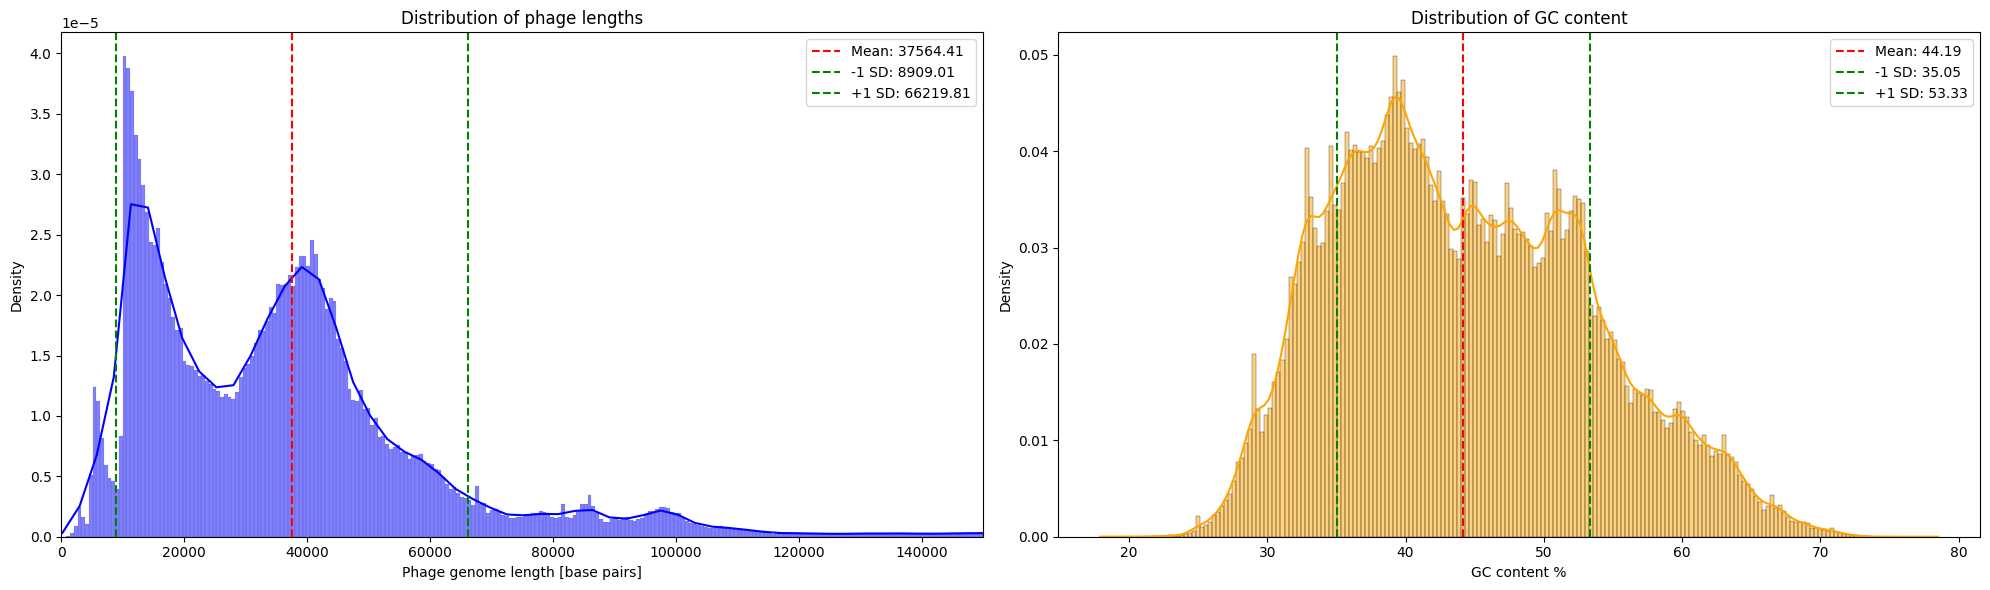

In [122]:
# plot LENGTH and GC_CONTENT columns histograms

mean = phage_metadata['Length'].mean().compute()
std = phage_metadata['Length'].std().compute()

mean2 = phage_metadata['GC_content'].mean().compute()
std2 = phage_metadata['GC_content'].std().compute()


# Convert to Pandas for plotting
pandas_df1 = phage_metadata['Length'].compute()
pandas_df2 = phage_metadata['GC_content'].compute()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the first distribution
sns.histplot(pandas_df1, kde=True, color='blue', stat="density", ax=axes[0])
axes[0].axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
axes[0].axvline(mean - std, color='green', linestyle='--', label=f'-1 SD: {mean - std:.2f}')
axes[0].axvline(mean + std, color='green', linestyle='--', label=f'+1 SD: {mean + std:.2f}')
axes[0].set_xlim(0, 150000)
axes[0].set_title('Distribution of phage lengths')
axes[0].set_xlabel('Phage genome length [base pairs]')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot the second distribution
sns.histplot(pandas_df2, kde=True, color='orange', stat="density", ax=axes[1])
axes[1].axvline(mean2, color='red', linestyle='--', label=f'Mean: {mean2:.2f}')
axes[1].axvline(mean2 - std2, color='green', linestyle='--', label=f'-1 SD: {mean2 - std2:.2f}')
axes[1].axvline(mean2 + std2, color='green', linestyle='--', label=f'+1 SD: {mean2 + std2:.2f}')
axes[1].set_title('Distribution of GC content')
axes[1].set_xlabel('GC content %')
axes[1].set_ylabel('Density')
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

fig.savefig('phege_length.tif', format='TIFF')

In [123]:
# List of categorical columns
#categorical_columns = ['Phage_source', 'Completeness', 'Lifestyle'] # PhageSource gives problems
categorical_columns = ['Completeness', 'Lifestyle']
#phage_metadata = phage_metadata.rename(columns={'Phage_source': 'Phage_source'})
category_counts = {col: phage_metadata[col].value_counts().compute() for col in categorical_columns}



2024-09-15 23:33:09,141 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle fed0479f74cac4860ab9c90f3fcae391 initialized by task ('shuffle-transfer-fed0479f74cac4860ab9c90f3fcae391', 3) executed on worker tcp://127.0.0.1:53958
2024-09-15 23:33:10,340 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle fed0479f74cac4860ab9c90f3fcae391 deactivated due to stimulus 'task-finished-1726435990.3357995'
2024-09-15 23:33:10,602 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e5d31371e09b1495346d880898e5bc55 initialized by task ('shuffle-transfer-e5d31371e09b1495346d880898e5bc55', 2) executed on worker tcp://127.0.0.1:53961
2024-09-15 23:33:11,242 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e5d31371e09b1495346d880898e5bc55 deactivated due to stimulus 'task-finished-1726435991.2355502'


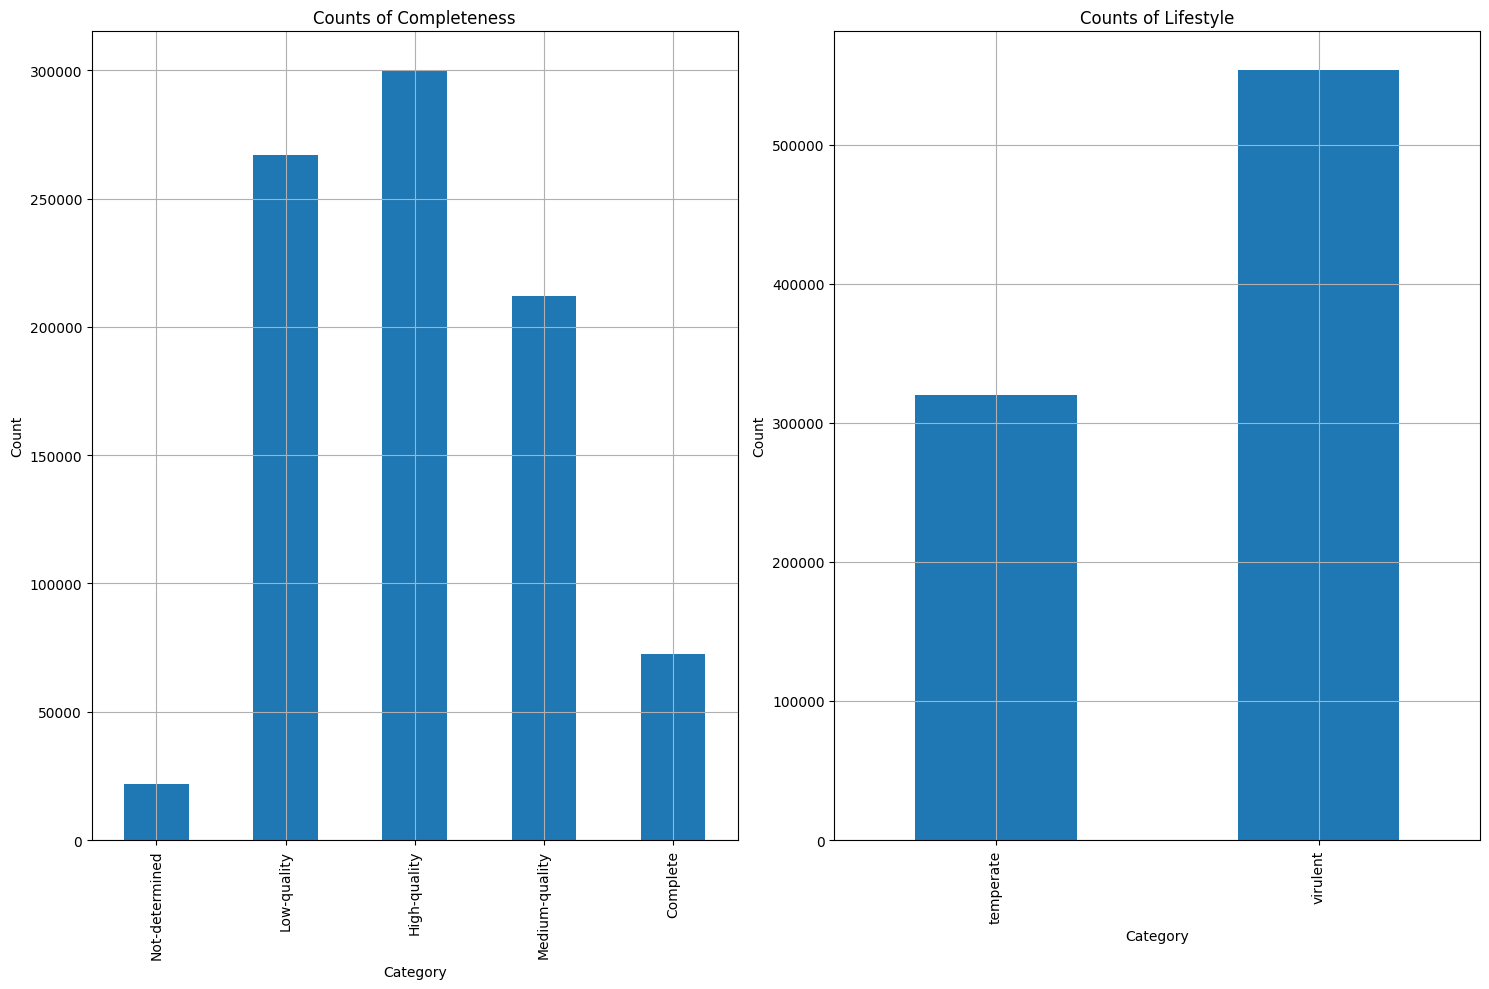

In [124]:
# Plotting the counts in subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

for i, col in enumerate(categorical_columns):
    category_counts[col].plot(kind='bar', ax=axs[i], title=f'Counts of {col}')
    axs[i].set_xlabel('Category')
    axs[i].set_ylabel('Count')
    axs[i].grid(True) 

plt.tight_layout()
plt.savefig('completeness_and_lifestyle.tif', format='TIFF')
plt.show()

In [173]:
# Value counts
# Compute the value counts for the "Taxonomy" and "Host" column
start = time.time()
phage_counts = phage_metadata['Taxonomy'].value_counts().compute()
host_counts  = phage_metadata['Host'].value_counts().compute()
print("elapsed time: " +  str(time.time() - start))

# Display the number of categories
num_categories_phages = phage_counts.index.size
print(f"Number of categories of phages: {num_categories_phages}")

num_categories_Host = host_counts.index.size
print(f"Number of categories of Hosts: {num_categories_Host}")

# Display the count of items in each category
print("Counts of each category:")
print(phage_counts.head())
#print(phage_counts.head())
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(host_counts.head())



2024-09-30 18:56:40,212 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e680327f166211d0addb978058b310c2 initialized by task ('shuffle-transfer-e680327f166211d0addb978058b310c2', 2) executed on worker tcp://127.0.0.1:61564
2024-09-30 18:56:42,130 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e680327f166211d0addb978058b310c2 deactivated due to stimulus 'task-finished-1727715402.108881'
2024-09-30 18:56:42,476 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 54fb5a47b2874f3ba75a34f36b5edf1b initialized by task ('shuffle-transfer-54fb5a47b2874f3ba75a34f36b5edf1b', 10) executed on worker tcp://127.0.0.1:61330
2024-09-30 18:56:43,703 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 54fb5a47b2874f3ba75a34f36b5edf1b deactivated due to stimulus 'task-finished-1727715403.6670558'


elapsed time: 4.222321271896362
Number of categories of phages: 351
Number of categories of Hosts: 13802
Counts of each category:
Taxonomy
Amyviridae             6
Andreaviridae         20
Autographiviridae    184
Bromoviridae           6
Ellaviridae           56
Name: count, dtype: int64[pyarrow]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Host
1G12                   1
2-02-FULL-47-50        3
2-02-FULL-58-16 A      3
43-37                  2
51-20                100
Name: count, dtype: int64[pyarrow]


In [181]:
type(phage_counts)

pandas.core.series.Series

In [182]:
phage_counts.isnull().any()

False

In [183]:
print(phage_counts.index)

Index(['Amyviridae', 'Andreaviridae', 'Autographiviridae', 'Bromoviridae',
       'Ellaviridae', 'Gokushoviridae', 'Jamieviridae', 'Johanneviridae',
       'Julianviridae', 'Karenviridae',
       ...
       'Mikasviridae', 'Mikkelviridae', 'Milleviridae', 'Pakpunavirus',
       'Pelleviridae', 'Plectroviridae', 'Rosaviridae', 'Schitoviridae',
       'Siaviridae', 'Tymovirales'],
      dtype='string', name='Taxonomy', length=351)


In [186]:
phage_counts.dtype

dtype('int32')

In [185]:
phage_counts = phage_counts.astype(int)

In [188]:
phage_counts.nlargest()

Taxonomy
Caudovirales      583452
Caudoviricetes    165109
Siphoviridae       22029
Myoviridae          9963
Microviridae        9362
Name: count, dtype: int32

In [189]:
sum(phage_counts)

824950

In [193]:
((583452+165109)/824950)*100

90.74016607067095

2024-09-30 19:40:20,537 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1427s; attempting restart: <WorkerState 'tcp://127.0.0.1:61327', name: 1, status: running, memory: 0, processing: 0>
2024-09-30 19:40:20,537 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1427s; attempting restart: <WorkerState 'tcp://127.0.0.1:61330', name: 3, status: running, memory: 0, processing: 0>
2024-09-30 19:40:20,540 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1427s; attempting restart: <WorkerState 'tcp://127.0.0.1:61551', name: 0, status: running, memory: 0, processing: 0>
2024-09-30 19:40:20,541 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1427s; attempting restart: <WorkerState 'tcp://127.0.0.1:61564', name: 2, status: running, memory: 0, processing: 0>
2024-09-30 19:40:21,751 - distributed.nanny - WARNING - Restarting worker
2024-09-30 19:40:21,763 - distributed.nanny - WARNING - Restarting worker
2024-09-30 19:40:21,

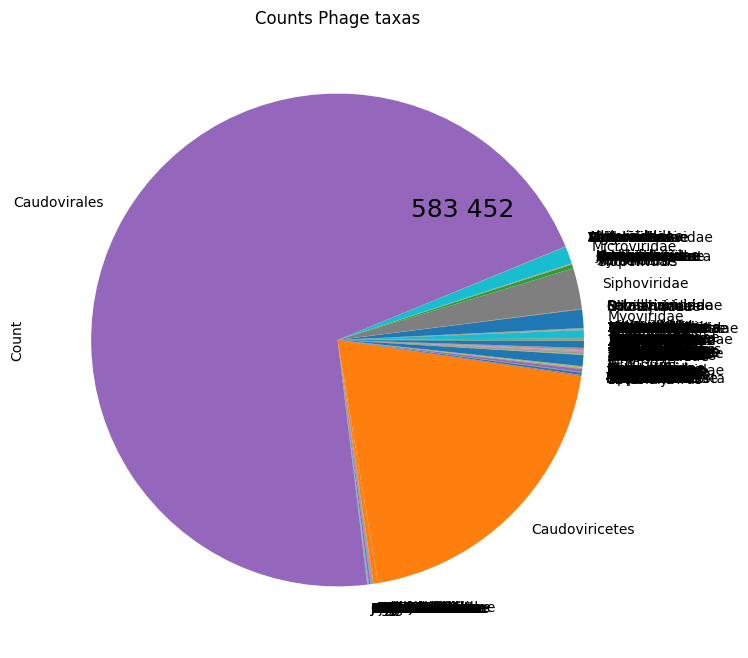

In [187]:
# Plotting the results
plt.figure(figsize=(10, 8))
phage_counts.plot(kind='pie')

plt.title('Counts Phage taxas')
#plt.xlabel('Category')
plt.ylabel('Count')
#plt.ylim(0, 500)

plt.xticks(rotation=90, visible = False)
#plt.tight_layout()

plt.text(
    x=0.3,
    y=0.5,
    s='583 452',
    fontsize=18
)


# Show the plot
plt.savefig('phage_taxa_distr.tif', format='TIFF')
plt.show()

#
# BIGGEST TAXA IS Caudovirales
#

In [201]:
# Split the "Host" column into multiple rows
split_df = phage_metadata['Host'].str.split(';').explode()

# Remove any empty strings that might result from splitting
split_df = split_df[split_df != '']

# Compute the value counts for each individual category
host_counts = split_df.value_counts().compute()

# Display the number of unique categories
num_categories = host_counts.index.size
print(f"Number of unique categories: {num_categories}")

# Display the count of items in each category
print("Counts of each category:")
host_counts.head()



2024-09-30 19:58:11,277 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3f261fc75999852028bad0d73e38cf5f initialized by task ('shuffle-transfer-3f261fc75999852028bad0d73e38cf5f', 1) executed on worker tcp://127.0.0.1:61804
2024-09-30 19:58:14,016 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3f261fc75999852028bad0d73e38cf5f deactivated due to stimulus 'task-finished-1727719094.0269825'


Number of unique categories: 10790
Counts of each category:


Host
1G12                   1
2-02-FULL-47-50        3
2-02-FULL-58-16 A      3
43-37                  2
51-20                100
Name: count, dtype: int64

In [202]:
data = split_df.compute()

In [203]:
type(data)

pandas.core.series.Series

In [204]:
(data.unique())

array(['Gemmiger', 'Neisseria', '-', ..., 'Pontibacter ummariensis',
       'Bacillus sp. KBS0812', 'Anaeromusa acidaminophila'], dtype=object)

In [205]:
data = data.astype('string')

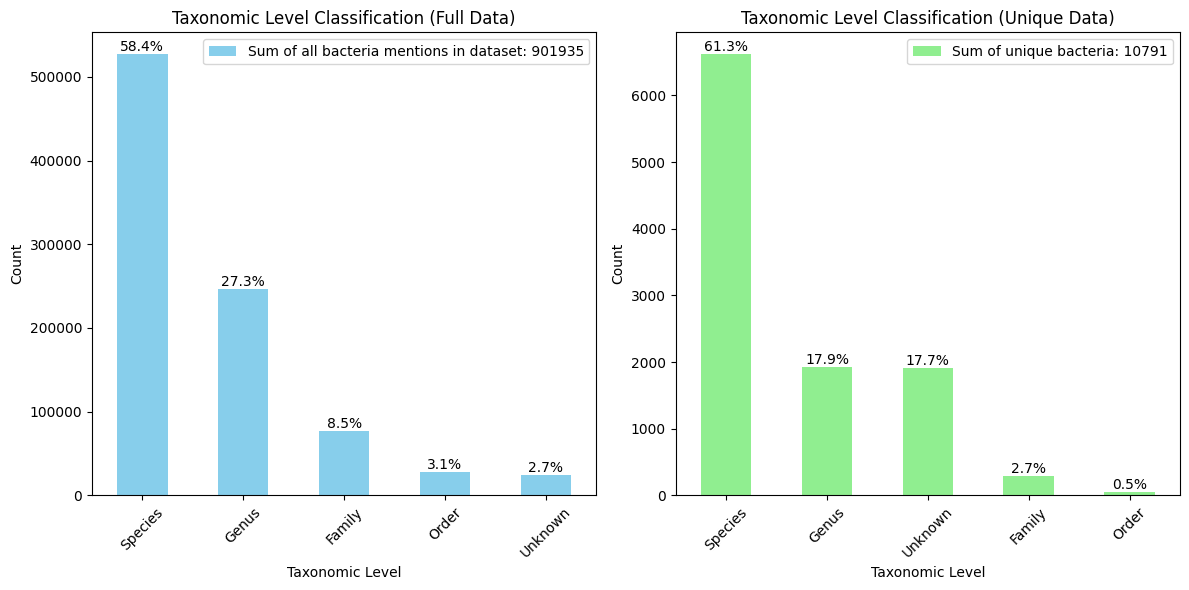

In [213]:
data = data.astype('string')
import pandas as pd

# Sample data
#data = pd.Series(['Escherichia coli', 'Escherichia', 'Enterobacteriaceae', 'Enterobacteriales'])


def classify_taxonomic_level(entry):
    if pd.isna(entry):  # Check for missing values (None, NaN, NA)
        return 'Unknown'
    words = entry.split()
    
    if len(words) == 2:
        if words[1].lower() in ['sp.', 'spp.']:
            return 'Genus'
        else:
            return 'Species'
    elif len(words) == 1:
        if entry.endswith('aceae'):
            return 'Family'
        elif entry.endswith('ales'):
            return 'Order'
        else:
            return 'Genus'
    return 'Unknown'

# Apply classification to the pandas series
data_classified = data.apply(classify_taxonomic_level)
category_counts = data_classified.value_counts()

unique_data = pd.Series(data.unique())  # Get unique values from the data
unique_classified = unique_data.apply(classify_taxonomic_level)
unique_category_counts = unique_classified.value_counts()

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the full data series
category_counts.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Taxonomic Level Classification (Full Data)')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Taxonomic Level')
axes[0].tick_params(axis='x', rotation=45)
# Add percentage labels on top of the bars

category_percentages = (category_counts / category_counts.sum()) * 100

for container in axes[0].containers:
    axes[0].bar_label(container, labels=[f'{p:.1f}%' for p in category_percentages])
axes[0].legend([f'Sum of all bacteria mentions in dataset: {category_counts.sum()}'], loc='upper right')



# Plot for the unique values
unique_category_counts.plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Taxonomic Level Classification (Unique Data)')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Taxonomic Level')
axes[1].tick_params(axis='x', rotation=45)
unique_category_percentages = (unique_category_counts / unique_category_counts.sum()) * 100

for container in axes[1].containers:
    axes[1].bar_label(container, labels=[f'{p:.1f}%' for p in unique_category_percentages])
axes[1].legend([f'Sum of unique bacteria: {unique_category_counts.sum()}'], loc='upper right')



plt.tight_layout()
plt.show()

In [197]:
unique_category_counts.sum()

10791

In [52]:
host_counts.nlargest(n= 20)

Host
Salmonella enterica             47967
Lawsonia intracellularis        38339
Clostridioides difficile        29445
Lachnospiraceae                 27751
Bacteroides                     22341
Bacteroidaceae                  21818
Escherichia coli                20735
Bacillus cereus                 19813
Faecalibacterium                17851
-                               17412
Streptococcus agalactiae        16038
Faecalibacterium prausnitzii    15751
Prevotella                      12966
Bacteroidales                   12596
Klebsiella pneumoniae           12409
Oscillospirales                 12196
Prevotella copri                12171
Oscillospiraceae                 9264
Parabacteroides                  9096
Staphylococcus aureus            9008
Name: count, dtype: int64

In [140]:
max_idx = host_counts.idxmax()
print(max_idx)
print(host_counts.loc[max_idx])

Salmonella enterica
47967


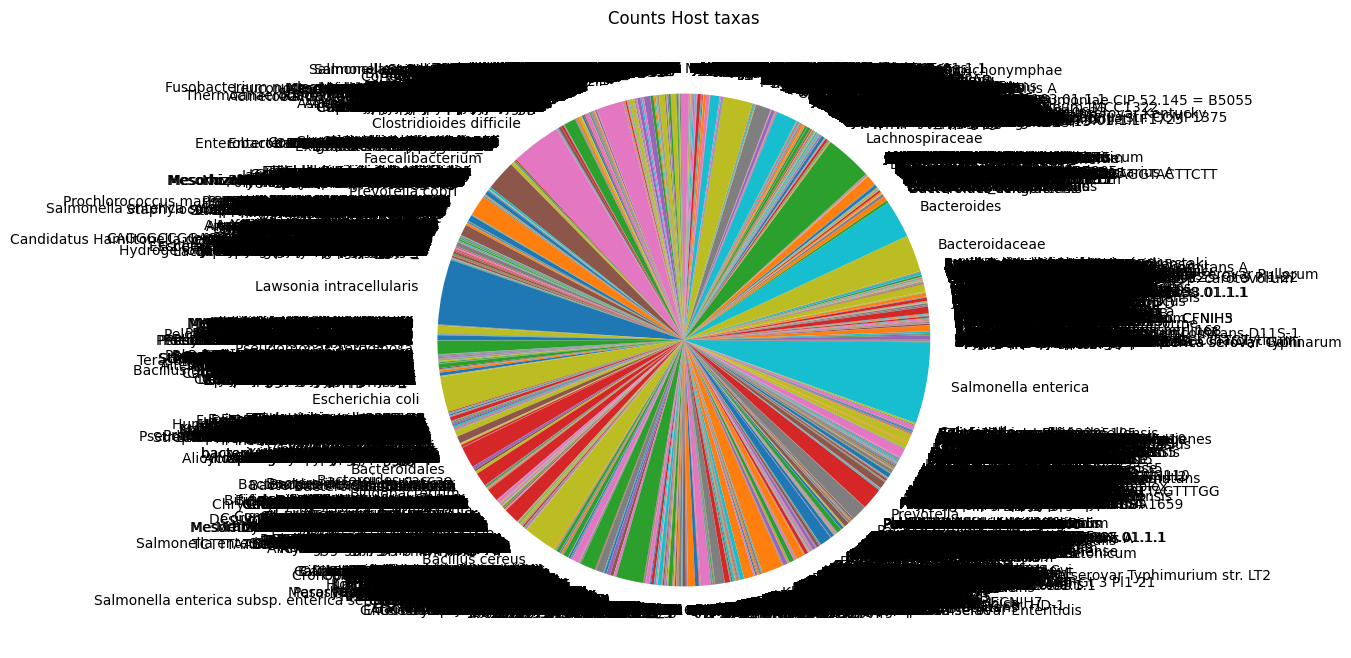

In [142]:
plt.figure(figsize=(10, 8))
host_counts.plot(kind='pie')

plt.title('Counts Host taxas')
#plt.xlabel('Category')
plt.ylabel('Count')
#plt.ylim(0, 25000)

plt.xticks(rotation=90, visible=False)
#plt.tight_layout()

# Show the plot
plt.savefig('host_species_distr.tif', format='TIFF')
plt.show()


In [217]:
from ete3 import NCBITaxa

# Initialize the NCBI taxonomy instance
ncbi = NCBITaxa()

# Example list of species or genera names
bacteria_names = ["Escherichia coli", "Bacillus subtilis", "Staphylococcus aureus"]

# Fetch taxonomic IDs from names
name_to_taxid = ncbi.get_name_translator(bacteria_names)

# For each taxon, retrieve the lineage information
for name, taxid in name_to_taxid.items():
    lineage = ncbi.get_lineage(taxid[0])  # Fetch the lineage for the first taxon ID
    names = ncbi.get_taxid_translator(lineage)  # Get the names for the taxonomic IDs
    ranks = ncbi.get_rank(lineage)  # Get the ranks (species, genus, family, etc.)
    
    print(f"Taxonomic lineage for {name}:")
    for taxid in lineage:
        print(f"{ranks[taxid]}: {names[taxid]}")
    print("\n")


Taxonomic lineage for Bacillus subtilis:
no rank: root
no rank: cellular organisms
superkingdom: Bacteria
clade: Terrabacteria group
phylum: Bacillota
class: Bacilli
order: Bacillales
family: Bacillaceae
genus: Bacillus
species group: Bacillus subtilis group
species: Bacillus subtilis


Taxonomic lineage for Escherichia coli:
no rank: root
no rank: cellular organisms
superkingdom: Bacteria
phylum: Pseudomonadota
class: Gammaproteobacteria
order: Enterobacterales
family: Enterobacteriaceae
genus: Escherichia
species: Escherichia coli


Taxonomic lineage for Staphylococcus aureus:
no rank: root
no rank: cellular organisms
superkingdom: Bacteria
clade: Terrabacteria group
phylum: Bacillota
class: Bacilli
order: Bacillales
family: Staphylococcaceae
genus: Staphylococcus
species: Staphylococcus aureus




In [218]:
name_to_taxid

{'Bacillus subtilis': [1423],
 'Escherichia coli': [562],
 'Staphylococcus aureus': [1280]}

In [219]:
ncbi.get_lineage(1423)

[1, 131567, 2, 1783272, 1239, 91061, 1385, 186817, 1386, 653685, 1423]

In [221]:
names = ncbi.get_taxid_translator(lineage)  # Get the names for the taxonomic IDs
names
#

{1: 'root',
 2: 'Bacteria',
 1239: 'Bacillota',
 1279: 'Staphylococcus',
 1280: 'Staphylococcus aureus',
 1385: 'Bacillales',
 90964: 'Staphylococcaceae',
 91061: 'Bacilli',
 131567: 'cellular organisms',
 1783272: 'Terrabacteria group'}

In [222]:
ranks = ncbi.get_rank(lineage)  # Get the ranks (species, genus, family, etc.)
ranks

{1: 'no rank',
 2: 'superkingdom',
 1239: 'phylum',
 1279: 'genus',
 1280: 'species',
 1385: 'order',
 90964: 'family',
 91061: 'class',
 131567: 'no rank',
 1783272: 'clade'}

2024-09-30 23:40:06,533 - distributed.scheduler - WARNING - Worker failed to heartbeat for 10798s; attempting restart: <WorkerState 'tcp://127.0.0.1:61799', name: 3, status: running, memory: 0, processing: 0>
2024-09-30 23:40:06,534 - distributed.scheduler - WARNING - Worker failed to heartbeat for 10798s; attempting restart: <WorkerState 'tcp://127.0.0.1:61800', name: 0, status: running, memory: 0, processing: 0>
2024-09-30 23:40:06,535 - distributed.scheduler - WARNING - Worker failed to heartbeat for 10798s; attempting restart: <WorkerState 'tcp://127.0.0.1:61801', name: 2, status: running, memory: 0, processing: 0>
2024-09-30 23:40:06,535 - distributed.scheduler - WARNING - Worker failed to heartbeat for 10798s; attempting restart: <WorkerState 'tcp://127.0.0.1:61804', name: 1, status: running, memory: 0, processing: 0>
2024-09-30 23:40:07,257 - distributed.nanny - WARNING - Restarting worker
2024-09-30 23:40:07,263 - distributed.nanny - WARNING - Restarting worker
2024-09-30 23:40

In [40]:
# Contingency table between Taxonomy and Host

p_m = phage_metadata.compute()
p_m['Host'] = p_m['Host'].str.split(';')
p_m_exploded = p_m.explode('Host')
p_m = p_m.astype({'Taxonomy': 'string[pyarrow]', 'Host': 'string[pyarrow]'})

contingency_table = pd.crosstab(p_m['Taxonomy'], p_m['Host'])
contingency_table

Host              ['-']  ['0-14-0-80-60-11']  ['1-19 sp001922585']  \
Taxonomy                                                             
-                   944                    0                     0   
Ackermannviridae     29                    0                     0   
Adamviridae           0                    0                     0   
Adenoviridae         11                    0                     0   
Adrianviridae        31                    0                     0   
...                 ...                  ...                   ...   
β-crassviridae       34                    0                     0   
γ-crassviridae        2                    0                     0   
δ-crassviridae        8                    0                     0   
ε-crassviridae        3                    0                     0   
ζ-crassviridae        1                    0                     0   

Host              ['14-2 sp000403255']  ['14-2 sp000403315']  \
Taxonomy                                                       
-                                    0                     0   
Ackermannviridae                     0                     0   
Adamviridae                          0                     0   
Adenoviridae                         0                     0   
Adrianviridae                        0                     0   
...                                ...                   ...   
β-crassviridae                       0                     0   
γ-crassviridae                       0                     0   
δ-crassviridae                       0                     0   
ε-crassviridae                       0                     0   
ζ-crassviridae                       0                     0   

Host              ['14-2 sp000403845']  ['172606-1']  ['1G12']  \
Taxonomy                                                         
-                                    0             0         0   
Ackermannviridae                     0             0         0   
Adamviridae                          0             0         0   
Adenoviridae                         0             0         0   
Adrianviridae                        0             0         0   
...                                ...           ...       ...   
β-crassviridae                       0             0         0   
γ-crassviridae                       0             0         0   
δ-crassviridae                       0             0         0   
ε-crassviridae                       0             0         0   
ζ-crassviridae                       0             0         0   

Host              ['1XD42-69 sp003612565']  ['1XD8-76 sp003611955']  ...  \
Taxonomy                                                             ...   
-                                        0                        0  ...   
Ackermannviridae                         0                        0  ...   
Adamviridae                              0                        0  ...   
Adenoviridae                             0                        0  ...   
Adrianviridae                            0                        0  ...   
...                                    ...                      ...  ...   
β-crassviridae                           0                        0  ...   
γ-crassviridae                           0                        0  ...   
δ-crassviridae                           0                        0  ...   
ε-crassviridae                           0                        0  ...   
ζ-crassviridae                           0                        0  ...   

Host              ['uncultured Ruminococcus sp.', 'Bifidobacterium adolescentis']  \
Taxonomy                                                                            
-                                                                 0                 
Ackermannviridae                                                  0                 
Adamviridae                                                       0 

In [89]:
print('Total n of PHIs:')
contingency_table.astype(bool).sum(axis=0).sum()

Total n of PHIs:


18866

In [94]:
print('Phage taxa that infect the most bact. species: ')
contingency_table.astype(bool).sum(axis=1).nlargest(n=10)

Phage taxa that infect the most bact. species: 


Taxonomy
Caudoviricetes    8160
Caudovirales      6306
Inoviridae         656
Siphoviridae       439
Microviridae       363
Myoviridae         337
NCLDV              257
Podoviridae        205
-                  140
Tubulavirales      120
dtype: int64

In [123]:
# Intraspecies host variability for Caudoviricetes

df = phage_metadata[['Taxonomy','Host']]

# Assuming your Dask DataFrame is called 'df' and the column to split is 'Host'
#df['Host'] = df['Host'].str.split(';')

# Explode the 'Host' column so that each entry in the list becomes a separate row
#df_exploded = df.explode('Host')

In [214]:
ddf = df[df['Taxonomy'] == 'Caudoviricetes']
ct = pd.crosstab(ddf['Host'], ddf['Taxonomy'])
ct

col_0                   Caudoviricetes
row_0                                 
0-14-0-80-60-11                      3
1-19 sp001922585                     1
14-2 sp000403255                     3
14-2 sp000403315                     2
14-2 sp000403845                     3
...                                ...
Zoogloea sp012927165                 1
Zunongwangia                         1
Zunongwangia atlantica               1
Zymobacter palmae                    4
Zymomonas mobilis                    8

[8160 rows x 1 columns]

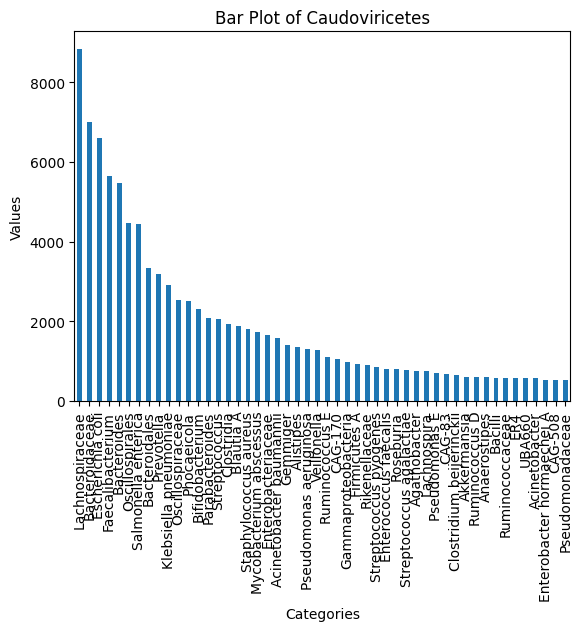

In [215]:
ct['Caudoviricetes'].nlargest(n=50).plot(kind='bar')

plt.title('Bar Plot of Caudoviricetes')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.show()

In [113]:
phage_metadata['Host'].compute()

0                      Gemmiger
1                     Neisseria
2                             -
3               Lachnospiraceae
4               Bifidobacterium
                  ...          
66818    Listeria monocytogenes
66819    Listeria monocytogenes
66820    Listeria monocytogenes
66821    Listeria monocytogenes
66822    Listeria monocytogenes
Name: Host, Length: 873718, dtype: object

In [24]:
print('Phage with biggest presence in the DB (>600k entries): ')
print('Caudovirales')
print('n.of bacteria he targets:')
contingency_table.astype(bool).sum(axis=1)['Caudovirales']

Phage with biggest presence in the DB (>600k entries): 
Caudovirales
n.of bacteria he targets:


6306

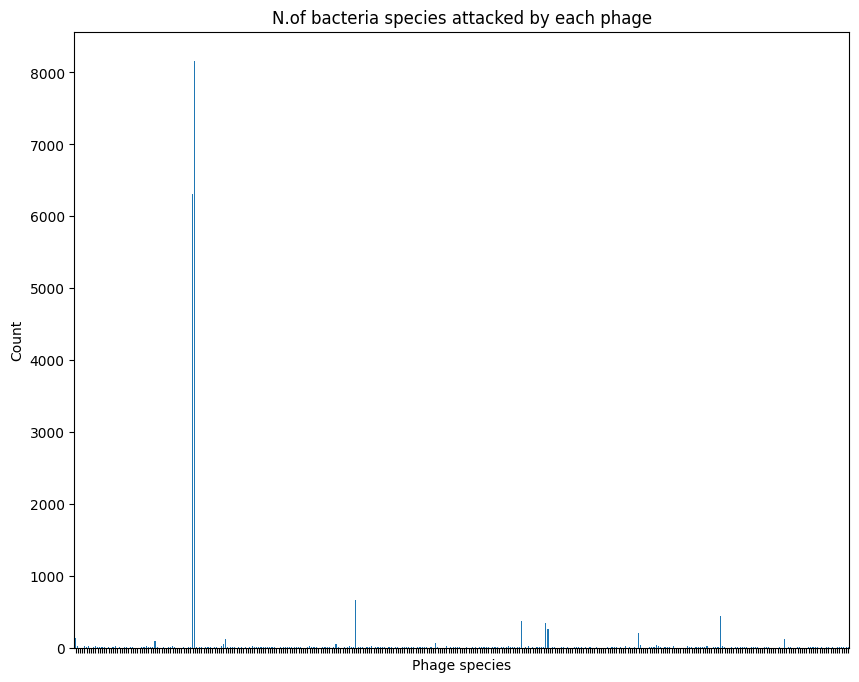

In [147]:
plt.figure(figsize=(10, 8))
contingency_table.astype(bool).sum(axis=1).plot(kind='bar')

plt.title('N.of bacteria species attacked by each phage')
plt.xlabel('Phage species')
plt.ylabel('Count')
#plt.ylim(0, 25000)

plt.xticks(rotation=90, visible=False)
#plt.tight_layout()

# Show the plot
plt.savefig('n of bacteria species attacked by each phage.tif', format='TIFF')
#plt.savefig()
plt.show()

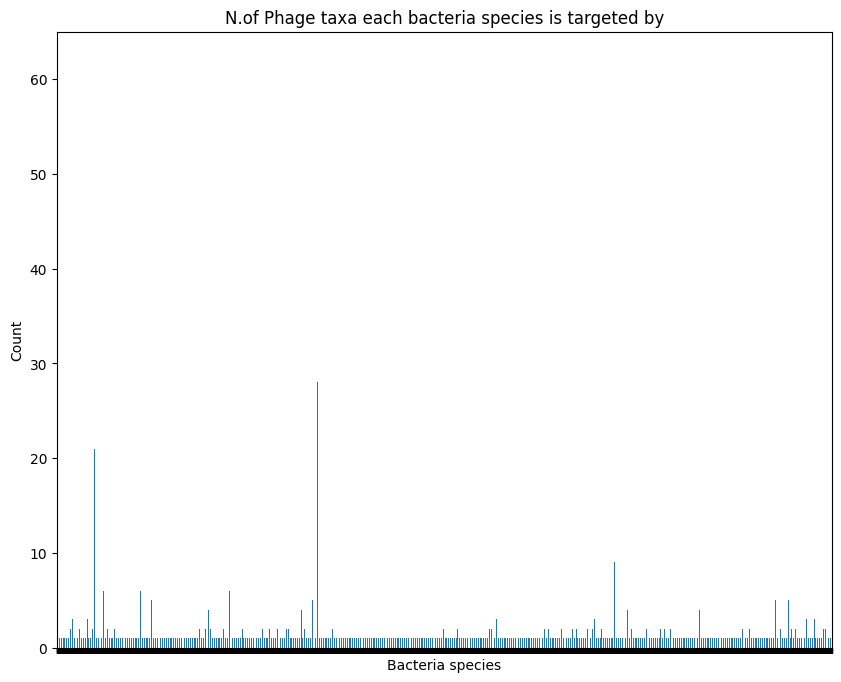

2024-10-01 10:44:47,531 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1153s; attempting restart: <WorkerState 'tcp://127.0.0.1:61248', name: 1, status: running, memory: 0, processing: 0>
2024-10-01 10:44:47,532 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1154s; attempting restart: <WorkerState 'tcp://127.0.0.1:61319', name: 2, status: running, memory: 0, processing: 0>
2024-10-01 10:44:47,533 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1154s; attempting restart: <WorkerState 'tcp://127.0.0.1:61320', name: 3, status: running, memory: 0, processing: 0>
2024-10-01 10:44:47,533 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1154s; attempting restart: <WorkerState 'tcp://127.0.0.1:61321', name: 0, status: running, memory: 0, processing: 0>
2024-10-01 10:44:47,912 - distributed.nanny - WARNING - Restarting worker
2024-10-01 10:44:47,917 - distributed.nanny - WARNING - Restarting worker
2024-10-01 10:44:47,

In [224]:
plt.figure(figsize=(10, 8))
#contingency_table.astype(bool).sum(axis=0).nlargest(n= 300).plot(kind='bar')
contingency_table.astype(bool).sum(axis=0).plot(kind='bar')
plt.title('N.of Phage taxa each bacteria species is targeted by')
plt.xlabel('Bacteria species')
plt.ylabel('Count')

plt.ylim(0, 65)

plt.xticks(rotation=90, visible=False)
#plt.tight_layout()

# Show the plot
plt.savefig('n of Phage taxa each bacteria species is targeted by.tif', format='TIFF')
#plt.savefig()
plt.show()

In [50]:
contingency_table.astype(bool).sum(axis=1).mean()

53.74928774928775

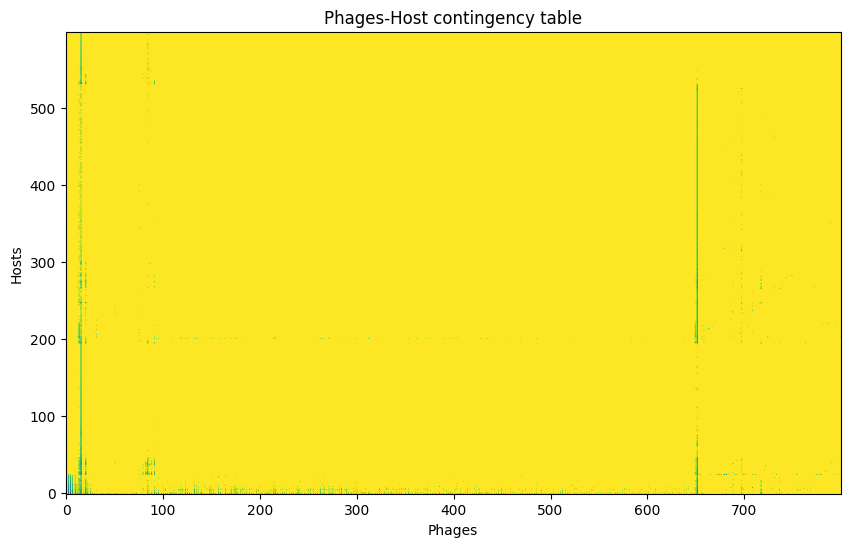

In [152]:
from datashader.utils import export_image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

phage_metadata_pandas = p_m

phage_metadata_pandas['Taxonomy'], col1_codes = pd.factorize(phage_metadata_pandas['Taxonomy'])
phage_metadata_pandas['Host'], col2_codes = pd.factorize(phage_metadata_pandas['Host'])

canvas = ds.Canvas(plot_width=800, plot_height=600)
agg = canvas.points(phage_metadata_pandas, 'Taxonomy', 'Host', agg=ds.count())
img = ds.tf.shade(agg, cmap='red', how='log')

# Convert the Datashader image to a format that Matplotlib can use
exported_img = export_image(img, "plot", background="white")

# Plot the image with Matplotlib and add labels
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(exported_img, aspect='auto', origin='lower')

# Add labels and title
ax.set_title('Phages-Host contingency table')
ax.set_xlabel('Phages')
ax.set_ylabel('Hosts')

fig.savefig('Phage_Host_contingency table.tif', format='TIFF')

plt.show()


In [167]:
contingency_table.shape

(351, 13595)

In [223]:
# Define the column names for the GFF3 format
column_names = [
    'seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'
]

# Load the GFF3 file
gff3_df = dd.read_csv(
    'C:/Users/lorenzo/Desktop/phagescope/GFF3/Phage_GFF3/RefSeq.gff3',
    sep='\t',
    comment='#',  # Skip comment lines starting with #
    names=column_names,
    dtype={
        'seqid': 'object', 
        'source': 'object', 
        'type': 'object', 
        'start': 'int64', 
        'end': 'int64',
        'score': 'object', 
        'strand': 'object', 
        'phase': 'object', 
        'attributes': 'object'
    }
)

# Preview the DataFrame
print(gff3_df['attributes'].head()[2])

ID=cds-NP_049616.1;Parent=gene-T4p001;Dbxref=GenBank:NP_049616.1,GeneID:1258593;Name=NP_049616.1;Note=mutants give rapid lysis on various lysogenic strains due to effects of specific prophage products%2C mistakenly interpreted as related to lysis inhibition;gbkey=CDS;gene=rIIA;locus_tag=T4p001;product=RIIA lysis inhibitor;protein_id=NP_049616.1;transl_table=11


In [221]:
gff3_df.head()

seqid  source    type  start     end score strand phase  \
0  NC_000866.4  RefSeq  region      1  168903     .      +     .   
1  NC_000866.4  RefSeq    gene     12    2189     .      -     .   
2  NC_000866.4  RefSeq     CDS     12    2189     .      -     0   
3  NC_000866.4  RefSeq    gene   2200    2403     .      -     .   
4  NC_000866.4  RefSeq     CDS   2200    2403     .      -     0   

                                          attributes  
0  ID=NC_000866.4:1..168903;Dbxref=taxon:2681598;...  
1  ID=gene-T4p001;Dbxref=GeneID:1258593;Name=rIIA...  
2  ID=cds-NP_049616.1;Parent=gene-T4p001;Dbxref=G...  
3  ID=gene-T4p002;Dbxref=GeneID:1258774;Name=rIIA...  
4  ID=cds-NP_049617.1;Parent=gene-T4p002;Dbxref=G...

## NON CODING DNA

In [43]:
ddf.dtypes

Phage_ID                      string[pyarrow]
Protein_source                string[pyarrow]
Function_Prediction_source    string[pyarrow]
Start                                   int64
Stop                                    int64
Strand                        string[pyarrow]
Protein_ID                    string[pyarrow]
Product                       string[pyarrow]
Protein_classification        string[pyarrow]
Molecular_weight              string[pyarrow]
Aromaticity                           float64
Instability_index             string[pyarrow]
Isoelectric_point                     float64
Helix_fraction                        float64
Turn_fraction                         float64
Sheet_fraction                        float64
Reduced_coefficient                     int64
Oxidized_coefficient                    int64
Phage_source                  string[pyarrow]
dtype: object

In [29]:
Protein_metadata = ddf[['Phage_ID', 'Start', 'Stop']]

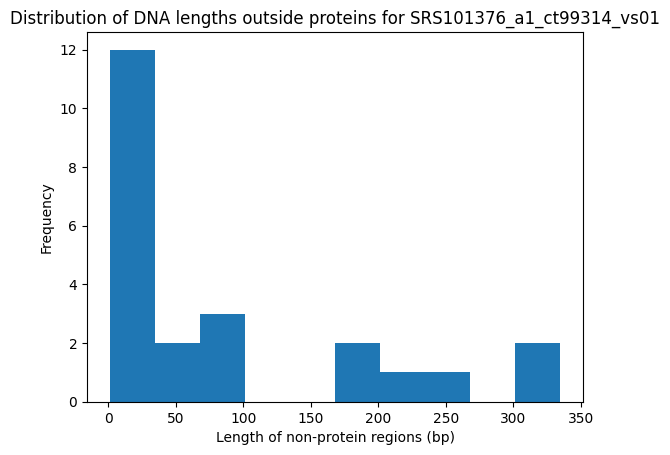

In [153]:
# Distribution of DNA lengths outside proteins for 1 phage

Protein_metadata = ddf[['Phage_ID', 'Start', 'Stop']]

# Step 1: Filter the data
phage_id = 'SRS101376_a1_ct99314_vs01'

# Get phage length
phage_length = phage_metadata[phage_metadata['Phage_ID'] == phage_id]['Length'].compute().values[0]

# Get protein regions
protein_regions = Protein_metadata[Protein_metadata['Phage_ID'] == phage_id][['Start', 'Stop']].compute().sort_values(by='Start')

# Step 2: Identify DNA regions outside proteins
non_protein_regions = []

# If there's DNA before the first protein
if protein_regions['Start'].iloc[0] > 1:
    non_protein_regions.append(protein_regions['Start'].iloc[0] - 1)

# Find the gaps between proteins
for i in range(1, len(protein_regions)):
    gap = protein_regions['Start'].iloc[i] - protein_regions['Stop'].iloc[i-1] - 1
    if gap > 0:
        non_protein_regions.append(gap)

# If there's DNA after the last protein
if protein_regions['Stop'].iloc[-1] < phage_length:
    non_protein_regions.append(phage_length - protein_regions['Stop'].iloc[-1])

# Step 3: Plot the distribution
plt.hist(non_protein_regions, bins=10)
plt.xlabel('Length of non-protein regions (bp)')
plt.ylabel('Frequency')
plt.title(f'Distribution of DNA lengths outside proteins for {phage_id}')
plt.show()


In [155]:
print('phage SRS101376_a1_ct99314_vs01 % of unannotated dna: ')
print((sum(non_protein_regions)/ phage_length)*100)

phage SRS101376_a1_ct99314_vs01 % of unannotated dna: 
5.997544312564934


In [156]:
# Read phage_metadata anew

folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\phage_metadata\*.tsv'  # Use a wildcard to select all TSV files
folder_path = folder_path.replace(os.sep, '/')
# Load all TSV files into a single Dask DataFrame
#start = time.time()
phage_metadata = dd.read_csv(folder_path, sep='\t')

In [157]:
#
# DISTRIBUTION OF RATIOS OF NON-CODING DNA LENGTH OVER TOTAL PHAGE LENGTH
#

Protein_metadata = ddf[['Phage_ID', 'Start', 'Stop']]
phage_metadata = phage_metadata[['Phage_ID', 'Length']]

merged_data = Protein_metadata.merge(phage_metadata[['Phage_ID', 'Length']], on='Phage_ID')


def compute_non_protein_ratio_per_phage(df):
    #print(df['Phage_ID'])
    #print(df.compute())
    phage_id = df['Phage_ID']
    phage_length = df['Length'].iloc[0]
    group = df[['Start', 'Stop']].copy()

    non_protein_regions = []

    # DNA before first protein
    if group['Start'].iloc[0] > 1:
        non_protein_regions.append(group['Start'].iloc[0] - 1)

    # Gaps between proteins
    for i in range(1, len(group)):
        gap = group['Start'].iloc[i] - group['Stop'].iloc[i-1] - 1
        if gap > 0:
            non_protein_regions.append(gap)

    # DNA after last protein
    if group['Stop'].iloc[-1] < phage_length:
        non_protein_regions.append(phage_length - group['Stop'].iloc[-1])

    # Calculate total non-protein length and ratio
    total_non_protein_length = sum(non_protein_regions)
    
    return total_non_protein_length / phage_length



ratios = merged_data.groupby('Phage_ID').apply(compute_non_protein_ratio_per_phage, meta=('Phage_ID', 'float')).compute()

ratios

2024-09-15 23:57:22,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8d30f340c076b09bec539edda60ee7ba initialized by task ('hash-join-transfer-8d30f340c076b09bec539edda60ee7ba', 9) executed on worker tcp://127.0.0.1:53961
2024-09-15 23:57:23,956 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a62acc179a9c78ab69c10c5b5d06f2fd initialized by task ('hash-join-transfer-a62acc179a9c78ab69c10c5b5d06f2fd', 7) executed on worker tcp://127.0.0.1:53958
2024-09-15 23:58:46,651 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f89ed070455ac16154f4ac9720acd1e3 initialized by task ('shuffle-transfer-f89ed070455ac16154f4ac9720acd1e3', 168) executed on worker tcp://127.0.0.1:53961
2024-09-16 00:00:06,621 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8d30f340c076b09bec539edda60ee7ba deactivated due to stimulus 'task-finished-1726437606.430361'
2024-09-16 00:00:06,631 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a62acc179a9c78ab69c10c5b5d

Phage_ID
7037.1.59410.ACACG_Malaspina_NODE_381_length_23770_cov_8.028785     0.096298
7154.1.61923.CACCT_Malaspina_NODE_1429_length_13259_cov_3.904415    0.013199
AB920995.1                                                          0.156695
Arthrobacter_phage_Litotes                                          0.058350
Broecker_Sample_ID29-1192-0_NODE_959_length_12695_cov_18.701503     0.099724
                                                                      ...   
uvig_96576                                                          0.072505
uvig_96853                                                          0.191053
uvig_96901                                                          0.058181
uvig_96927                                                          0.049575
uvig_98866                                                          0.338575
Name: Phage_ID, Length: 873679, dtype: float64

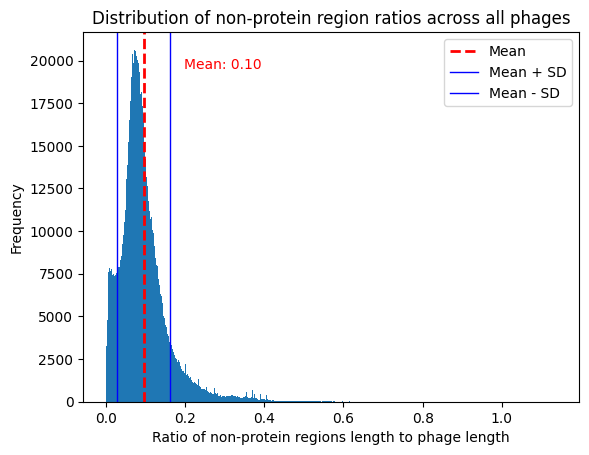

2024-09-16 09:55:37,544 - distributed.scheduler - WARNING - Worker failed to heartbeat for 34728s; attempting restart: <WorkerState 'tcp://127.0.0.1:53956', name: 3, status: running, memory: 0, processing: 0>
2024-09-16 09:55:37,545 - distributed.scheduler - WARNING - Worker failed to heartbeat for 34728s; attempting restart: <WorkerState 'tcp://127.0.0.1:53957', name: 1, status: running, memory: 0, processing: 0>
2024-09-16 09:55:37,546 - distributed.scheduler - WARNING - Worker failed to heartbeat for 34728s; attempting restart: <WorkerState 'tcp://127.0.0.1:53958', name: 2, status: running, memory: 0, processing: 0>
2024-09-16 09:55:37,547 - distributed.scheduler - WARNING - Worker failed to heartbeat for 34728s; attempting restart: <WorkerState 'tcp://127.0.0.1:53961', name: 0, status: running, memory: 0, processing: 0>
2024-09-16 09:55:41,821 - distributed.nanny - WARNING - Restarting worker
2024-09-16 09:55:41,842 - distributed.nanny - WARNING - Restarting worker
2024-09-16 09:55

In [158]:
#
# PLOT THE DISTRIBUTION
#
plt.hist(ratios, bins = 500)
plt.xlabel('Ratio of non-protein regions length to phage length')
plt.ylabel('Frequency')
plt.title('Distribution of non-protein region ratios across all phages')

# Calculate mean and standard deviation
mean_ratio = ratios.mean()
std_ratio = ratios.std()

# Plot vertical lines
plt.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(mean_ratio + std_ratio, color='blue', linestyle='-', linewidth=1, label='Mean + SD')
plt.axvline(mean_ratio - std_ratio, color='blue', linestyle='-', linewidth=1, label='Mean - SD')

# Annotate the mean value
plt.text(mean_ratio + 0.2, plt.ylim()[1] * 0.9, f'Mean: {mean_ratio:.2f}', color='red', ha='center')

# Show the plot
plt.legend()
plt.show()

plt.show()

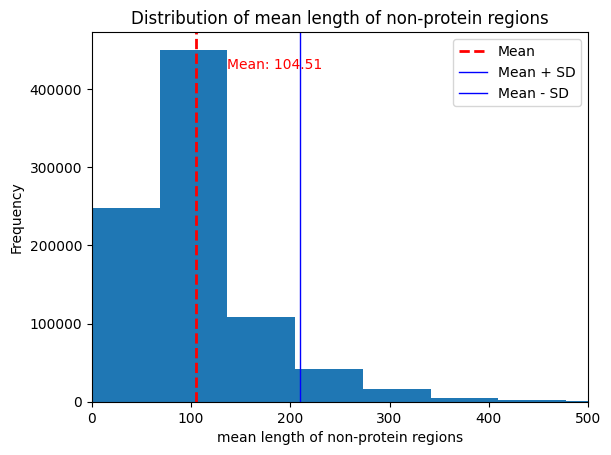

In [ ]:
!pip install ete3


In [151]:
import pandas as pd

# Sample taxonomic data (adjust to fit your dataset)
data = pd.DataFrame({
    'Domain': ['Bacteria', 'Bacteria', 'Bacteria'],
    'Phylum': ['Proteobacteria', 'Firmicutes', 'Proteobacteria'],
    'Class': ['Gammaproteobacteria', 'Bacilli', 'Alphaproteobacteria'],
    'Order': ['Enterobacteriales', 'Bacillales', 'Rhodospirillales'],
    'Family': ['Enterobacteriaceae', 'Bacillaceae', 'Rhodospirillaceae'],
    'Genus': ['Escherichia', 'Bacillus', 'Rhodospirillum'],
    'Species': ['Escherichia coli', '', '']
})




from ete3 import Tree, TreeStyle, NodeStyle

# Initialize the root of the tree
root = Tree()

# Add data to the tree recursively
def add_to_tree(tree, taxon):
    # Start with the root and go down through the taxonomy ranks
    node = tree
    for rank in taxon:
        # Find the node or create it if it doesn't exist
        if not node.search_nodes(name=rank):
            child = node.add_child(name=rank)
        else:
            child = node.search_nodes(name=rank)[0]
        node = child

# Iterate through each taxonomic entry
for _, row in data.iterrows():
    taxon_path = row.dropna().tolist()  # Drop missing ranks
    add_to_tree(root, taxon_path)

# Set up tree style (optional)
ts = TreeStyle()
ts.show_leaf_name = True

# Visualize the tree
root.show(tree_style=ts)


In [153]:
import networkx as nx
import matplotlib.pyplot as plt


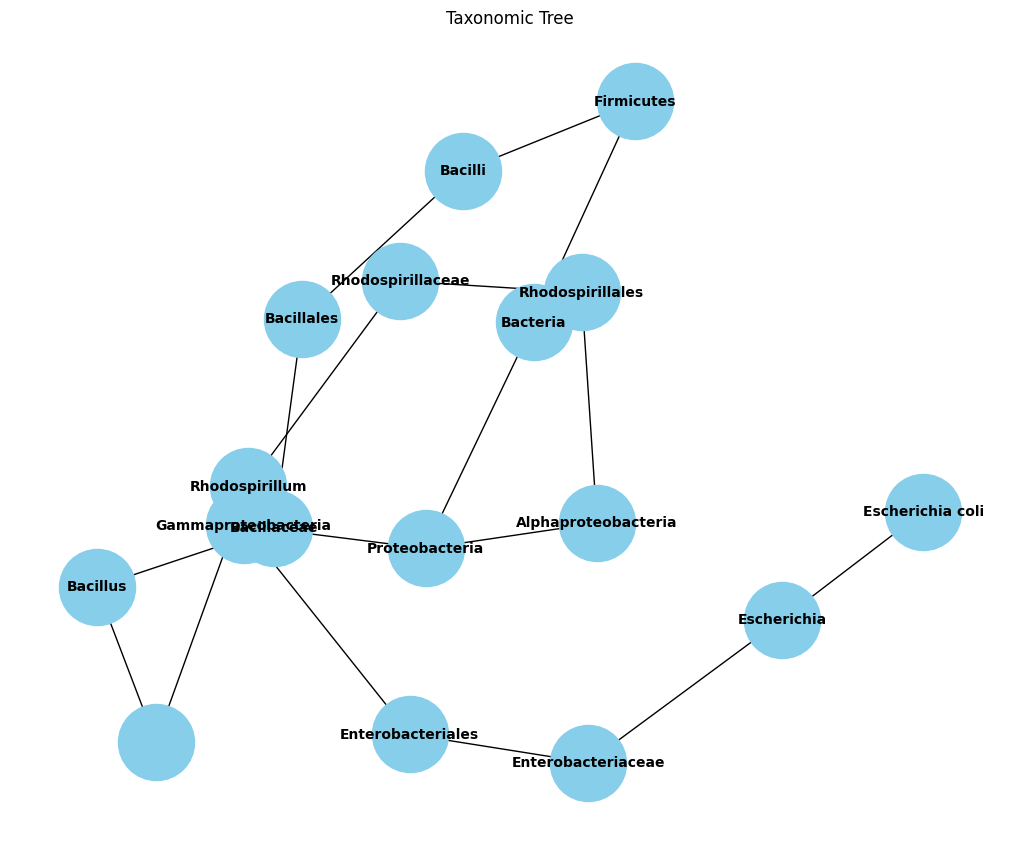

In [154]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph based on taxonomic data
for _, row in data.iterrows():
    path = row.dropna().tolist()  # Drop missing ranks
    for i in range(len(path) - 1):
        G.add_edge(path[i], path[i + 1])

# Draw the tree using NetworkX's built-in plotting functionality
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrows=False)
plt.title('Taxonomic Tree')
plt.show()


# Interspecies variability
## Caudovirales and caudoviricetes are the two phage taxa more represented in the dataset (70% and 20% respectively) and are the only two taxa that infect more than half of the hosts. Let's analyze them

In [4]:
phage_metadata_caudovirales = phage_metadata[phage_metadata['Taxonomy'] == 'Caudovirales']
phage_metadata_caudoviricetes = phage_metadata[phage_metadata['Taxonomy'] == 'Caudoviricetes']
phage_metadata_else = phage_metadata[(phage_metadata['Taxonomy'] != 'Caudovirales') & (phage_metadata['Taxonomy'] != 'Caudoviricetes')]

phage_metadata_caudovirales.head()

Phage_ID  Length  GC_content      Taxonomy  \
22  SAMEA1906418_a1_ct54868_vs1   17517   38.048753  Caudovirales   
38      SAMEA1906422_b1_ct2_vs3   43000   42.434884  Caudovirales   
48     SAMEA1906422_b1_ct69_vs2   24209   38.783097  Caudovirales   
63      SAMEA1906422_b1_ct9_vs6    9750   46.594872  Caudovirales   
64      SAMEA1906422_b1_ct9_vs7   14100   49.234043  Caudovirales   

      Completeness                 Host  Lifestyle         Cluster  \
22     Low-quality  Pseudoruminoccoccus  temperate  cluster_514788   
38    High-quality        Solobacterium  temperate  cluster_243649   
48     Low-quality          Bacteroides   virulent  cluster_132574   
63  Not-determined                    -   virulent  cluster_141479   
64  Not-determined                    -   virulent  cluster_256881   

           Subcluster Phage_source  
22  subcluster_620082         CHVD  
38  subcluster_294651         CHVD  
48  subcluster_159836         CHVD  
63  subcluster_170522         CHVD  
64  subcluster_310241         CHVD

In [313]:
phage_metadata_else.head()

Phage_ID  Length  GC_content      Taxonomy  \
0     SRS101376_a1_ct99314_vs01   31763   50.511602    Myoviridae   
1     SRS101388_a1_ct42327_vs01  223331   42.421339    Myoviridae   
2     SRS101376_a1_ct26874_vs01   25835   52.897232    Myoviridae   
3       SAMEA1906416_a1_ct13001   53468   40.515823  Siphoviridae   
4  SAMEA1906416_a1_ct130485_vs1   23523   61.658802  Siphoviridae   

     Completeness             Host Lifestyle         Cluster  \
0    High-quality         Gemmiger  virulent   cluster_33392   
1    High-quality        Neisseria  virulent  cluster_340704   
2     Low-quality                -  virulent  cluster_208857   
3    High-quality  Lachnospiraceae  virulent  cluster_243648   
4  Medium-quality  Bifidobacterium  virulent   cluster_44056   

          Subcluster Phage_source  
0   subcluster_40629         CHVD  
1  subcluster_411447         CHVD  
2  subcluster_251798         CHVD  
3  subcluster_294650         CHVD  
4   subcluster_53753         CHVD

In [5]:
print('len(phage_metadata_caudovirales): ')
print(len(phage_metadata_caudovirales))

print('len(phage_metadata_caudoviricetes): ')
print(len(phage_metadata_caudoviricetes))

print('len(phage_metadata_else): ')
print(len(phage_metadata_else))



len(phage_metadata_caudovirales): 
583452
len(phage_metadata_caudoviricetes): 
165109
len(phage_metadata_else): 
125157


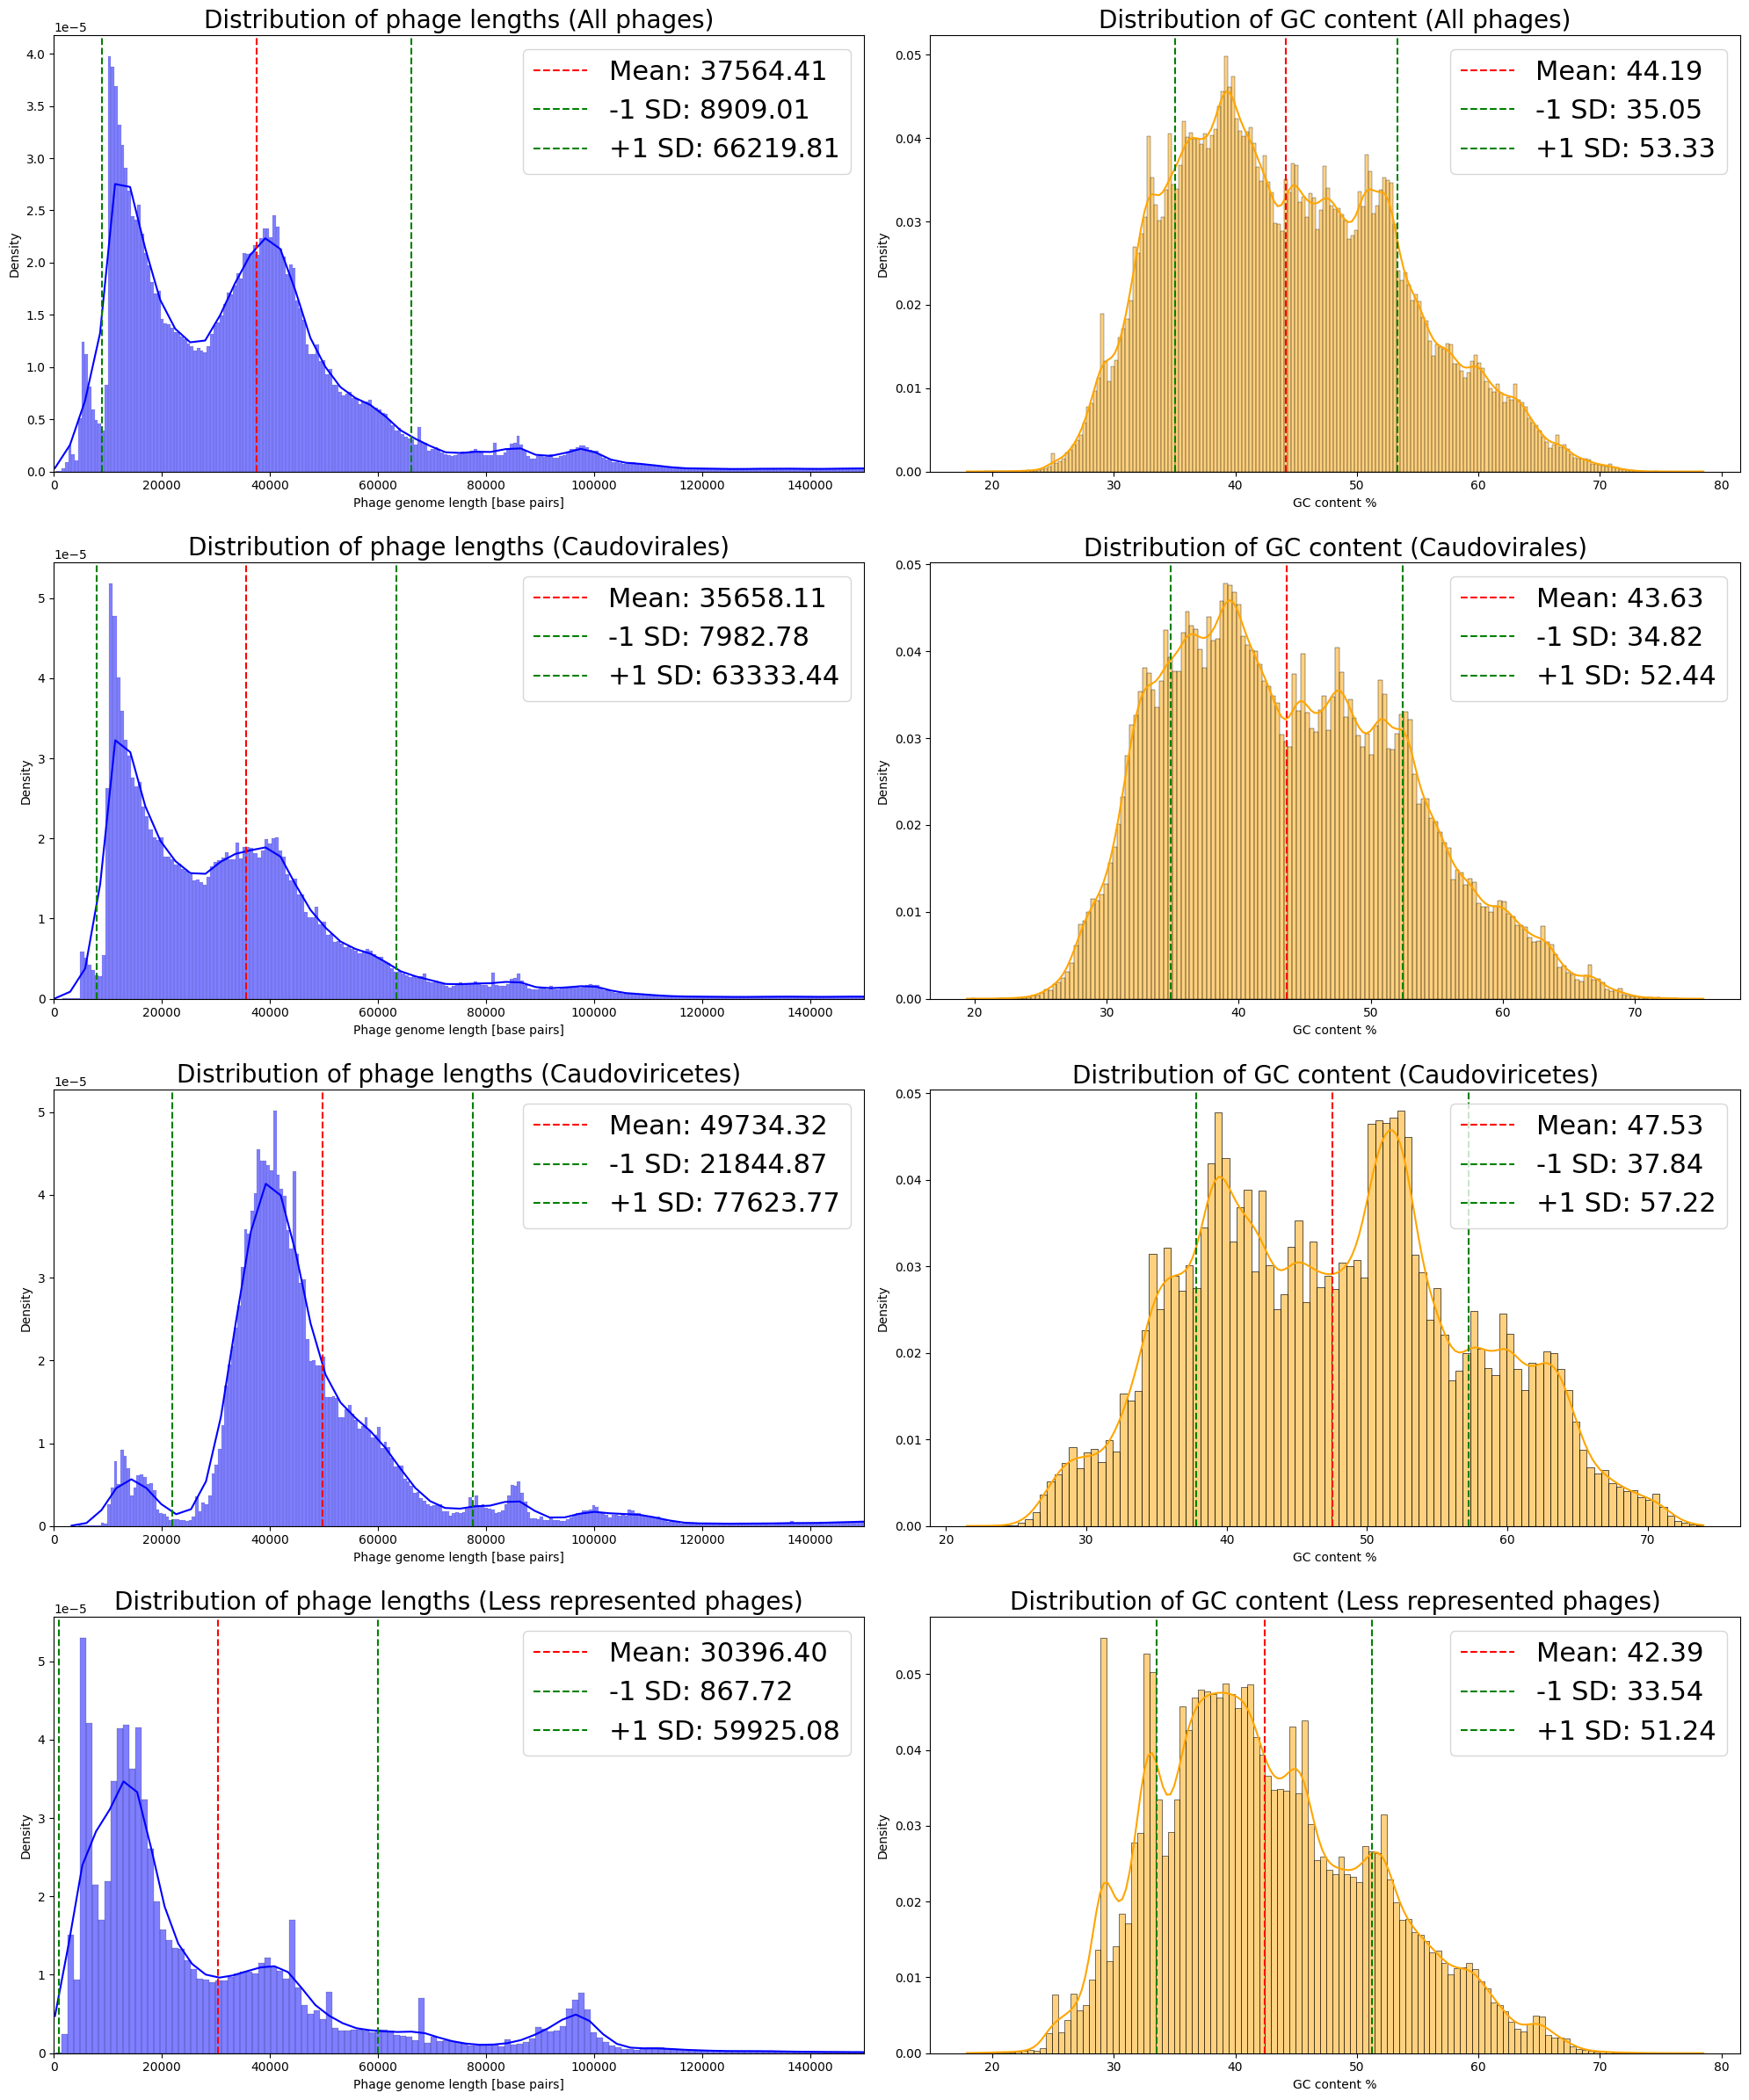

In [6]:
#
# PLOT LENGTH AND GC CONTENT FOR ALL PHAGES, CAUDOVIRALES, CAUDOVIRICETES AND THE LESS REPRESENTED PHAGES
#

import matplotlib.pyplot as plt
import seaborn as sns

# List of DataFrames and their names
dfs = [phage_metadata, phage_metadata_caudovirales, phage_metadata_caudoviricetes, phage_metadata_else]
df_names = ['All phages', 'Caudovirales', 'Caudoviricetes', 'Less represented phages']

# Create a figure with 4 rows and 2 columns (8 subplots total)
fig, axes = plt.subplots(4, 2, figsize=(20, 24))  # Adjust figure size as needed

for i, df in enumerate(dfs):
    # Compute the means and std for each DataFrame
    mean_length = df['Length'].mean().compute()
    std_length = df['Length'].std().compute()
    mean_gc = df['GC_content'].mean().compute()
    std_gc = df['GC_content'].std().compute()

    # Convert Dask DataFrames to Pandas for plotting
    pandas_df1 = df['Length'].compute()
    pandas_df2 = df['GC_content'].compute()

    # Plot the first distribution (Length)
    sns.histplot(pandas_df1, kde=True, color='blue', stat="density", ax=axes[i, 0])
    axes[i, 0].axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
    axes[i, 0].axvline(mean_length - std_length, color='green', linestyle='--', label=f'-1 SD: {mean_length - std_length:.2f}')
    axes[i, 0].axvline(mean_length + std_length, color='green', linestyle='--', label=f'+1 SD: {mean_length + std_length:.2f}')
    axes[i, 0].set_xlim(0, 150000)
    axes[i, 0].set_title(f'Distribution of phage lengths ({df_names[i]})', fontsize = 20)
    axes[i, 0].set_xlabel('Phage genome length [base pairs]')
    axes[i, 0].set_ylabel('Density')
    axes[i, 0].legend(fontsize=22, handlelength=2, labelspacing=0.5)

    # Plot the second distribution (GC content)
    sns.histplot(pandas_df2, kde=True, color='orange', stat="density", ax=axes[i, 1])
    axes[i, 1].axvline(mean_gc, color='red', linestyle='--', label=f'Mean: {mean_gc:.2f}')
    axes[i, 1].axvline(mean_gc - std_gc, color='green', linestyle='--', label=f'-1 SD: {mean_gc - std_gc:.2f}')
    axes[i, 1].axvline(mean_gc + std_gc, color='green', linestyle='--', label=f'+1 SD: {mean_gc + std_gc:.2f}')
    axes[i, 1].set_title(f'Distribution of GC content ({df_names[i]})', fontsize = 20)
    axes[i, 1].set_xlabel('GC content %')
    axes[i, 1].set_ylabel('Density')
    axes[i, 1].legend(fontsize=22, handlelength=2, labelspacing=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('length_and_gc.tiff', format='tiff', dpi=300)
plt.show()


2024-10-08 19:07:54,530 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle fed0479f74cac4860ab9c90f3fcae391 initialized by task ('shuffle-transfer-fed0479f74cac4860ab9c90f3fcae391', 11) executed on worker tcp://127.0.0.1:55814
2024-10-08 19:07:55,526 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle fed0479f74cac4860ab9c90f3fcae391 deactivated due to stimulus 'task-finished-1728407275.5196958'
2024-10-08 19:07:55,886 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e5d31371e09b1495346d880898e5bc55 initialized by task ('shuffle-transfer-e5d31371e09b1495346d880898e5bc55', 10) executed on worker tcp://127.0.0.1:55814
2024-10-08 19:07:56,769 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e5d31371e09b1495346d880898e5bc55 deactivated due to stimulus 'task-finished-1728407276.764212'
2024-10-08 19:07:57,272 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 969e4c073a4b8756e0d4ee9efd625673 initialized by task ('shuffle-transfer-969e4c073a4b8

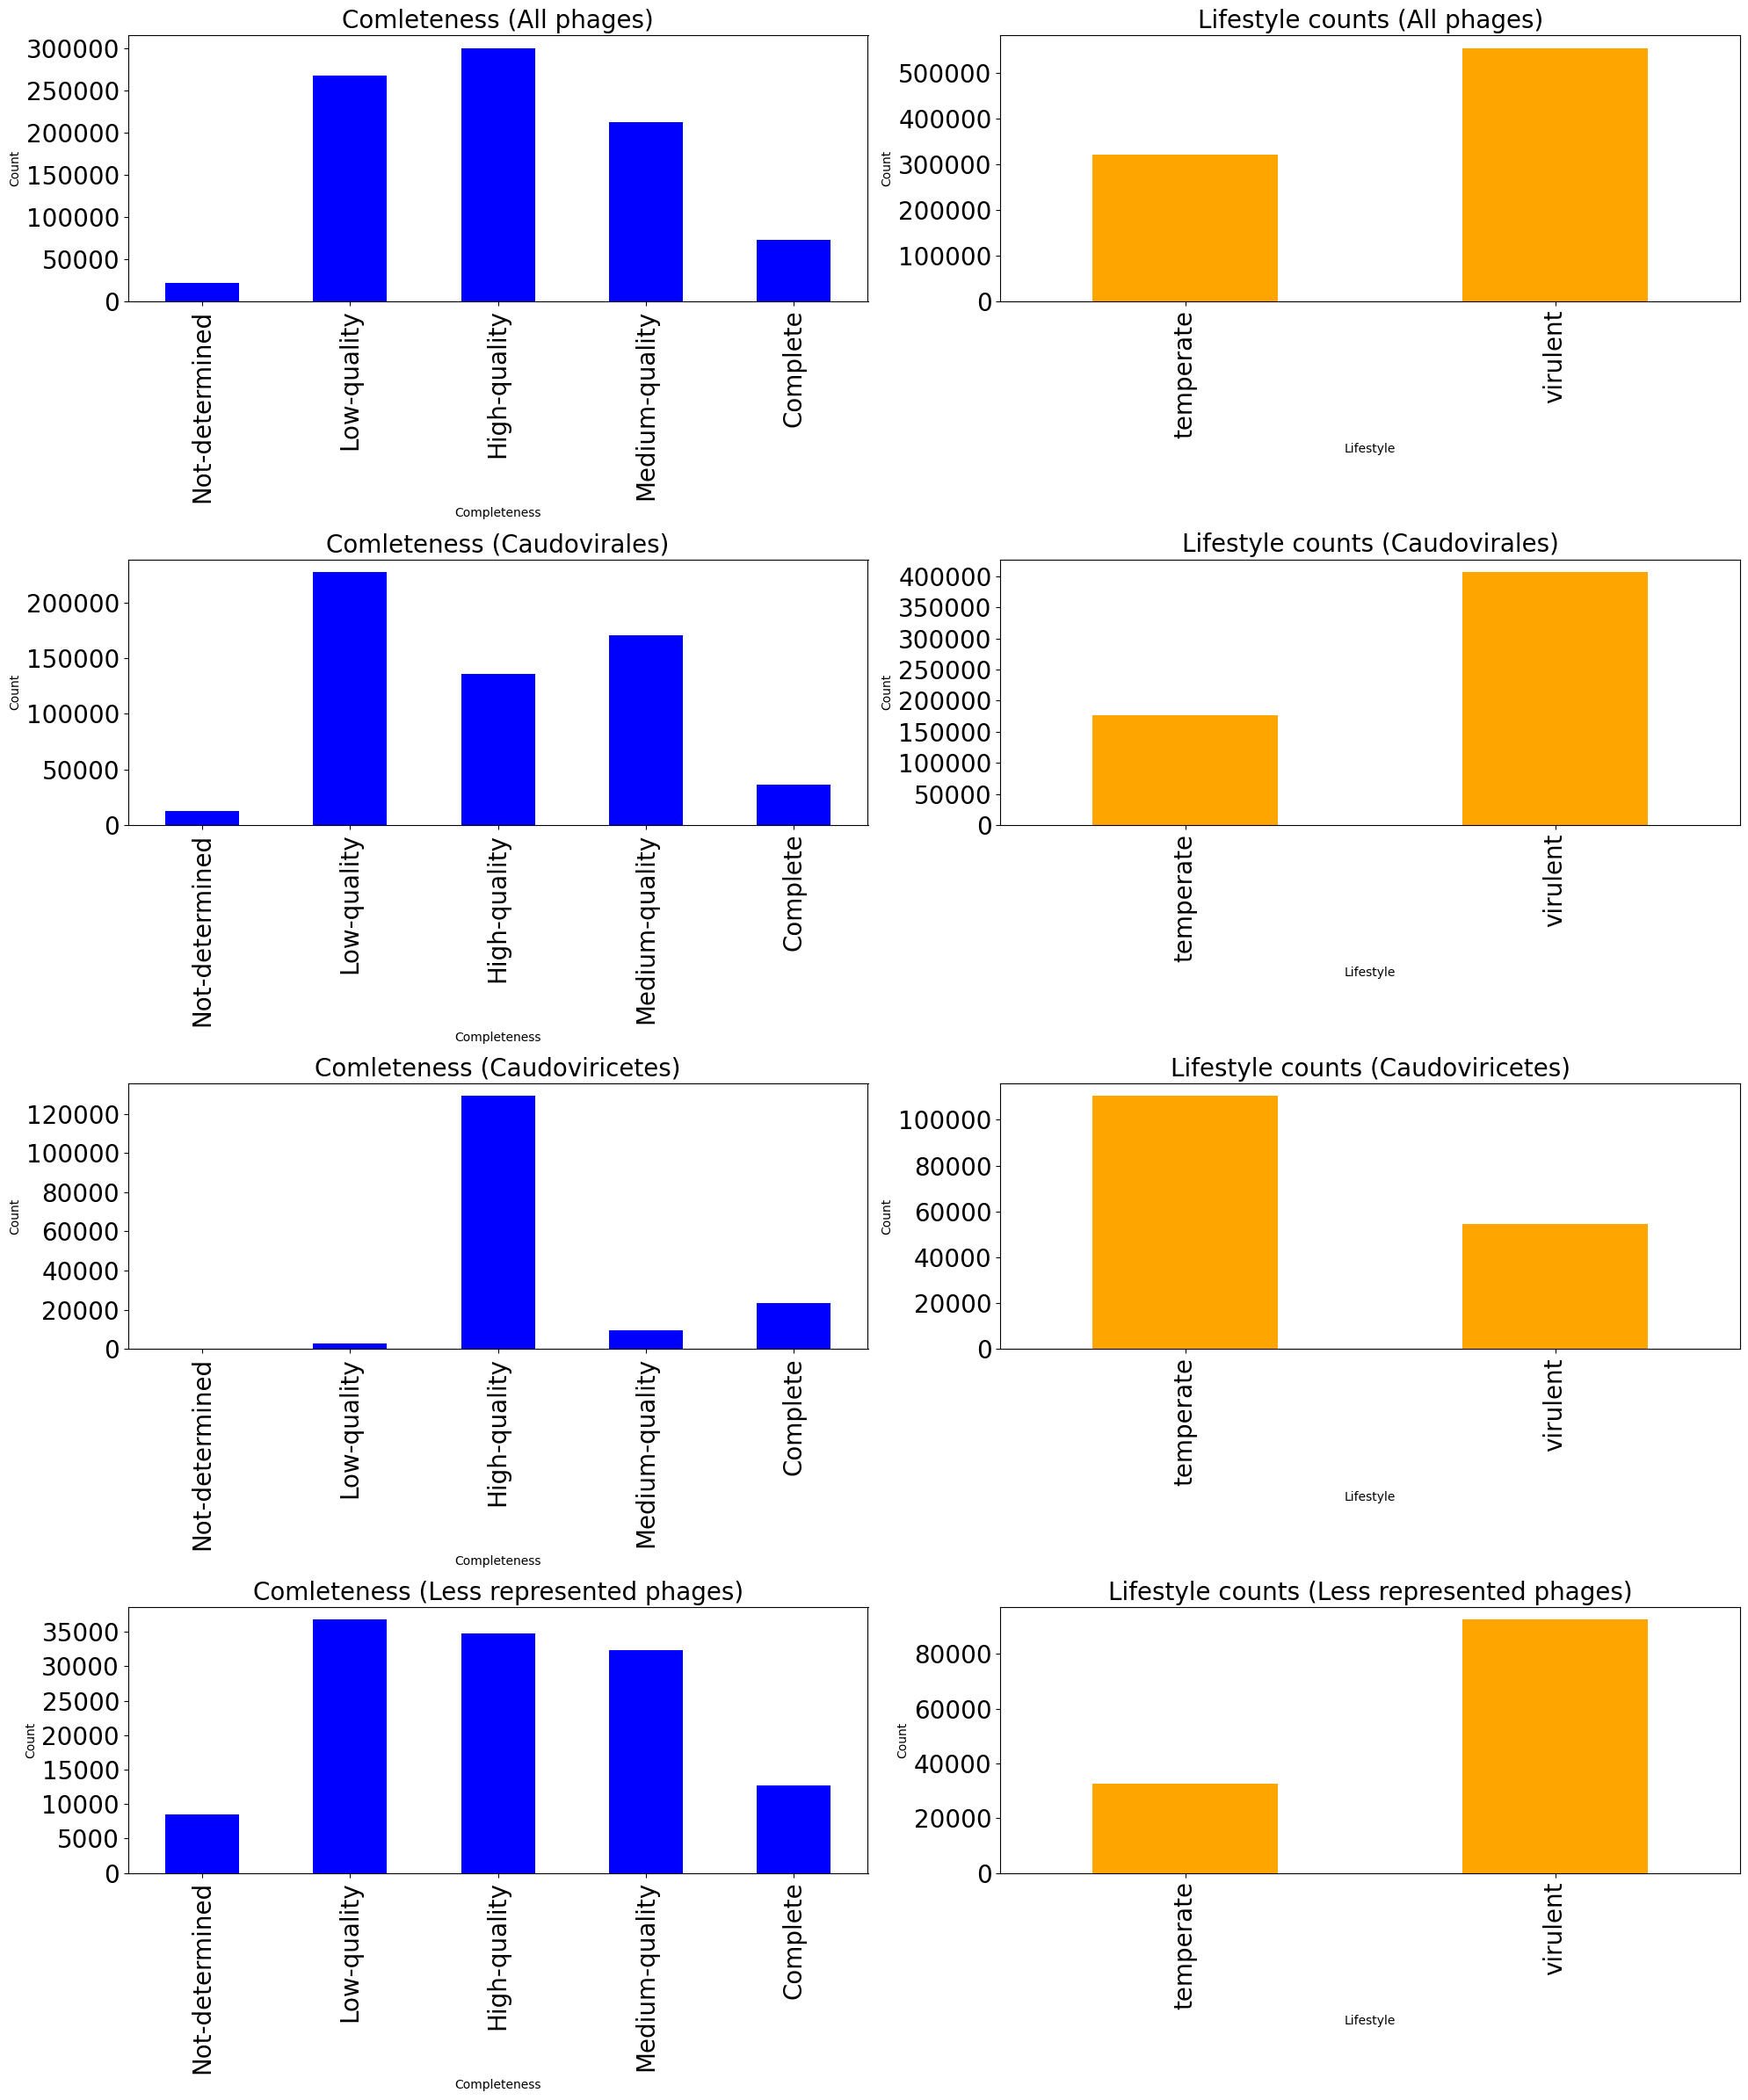

In [8]:
# PLOT QUALITY AND LIFESTYLE


dfs = [phage_metadata, phage_metadata_caudovirales, phage_metadata_caudoviricetes, phage_metadata_else]
df_names = ['All phages', 'Caudovirales', 'Caudoviricetes', 'Less represented phages']

# Create a figure with 4 rows and 2 columns (8 subplots total)
fig, axes = plt.subplots(4, 2, figsize=(20, 24))  # Adjust figure size as needed

for i, df in enumerate(dfs):
    # Compute the value counts for 'Completeness' and 'Lifestyle'
    pandas_df1 = df['Completeness'].value_counts().compute()  # Counts for bar plot
    pandas_df2 = df['Lifestyle'].value_counts().compute()  # Counts for bar plot

    # Plot 'Completeness' counts
    pandas_df1.plot(kind='bar', ax=axes[i, 0], color='blue', title=f'Completeness counts ({df_names[i]})', fontsize=20)
    axes[i, 0].set_title(f'Comleteness ({df_names[i]})', fontsize=20)
    #axes[i, 0].set_xlabel('Completeness')
    axes[i, 0].set_ylabel('Count')

    # Plot 'Lifestyle' counts
    pandas_df2.plot(kind='bar', ax=axes[i, 1], color='orange', title=f'Lifestyle counts ({df_names[i]})', fontsize=20)
    axes[i, 1].set_title(f'Lifestyle counts ({df_names[i]})', fontsize=20)
    #axes[i, 1].set_xlabel('Lifestyle')
    axes[i, 1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig('protein_categories_plot.tiff', format='tiff', dpi=300)
# Show the plots
plt.show()


In [9]:
# Value counts
# Compute the value counts for the "Taxonomy" and "Host" column
#start = time.time()
phage_counts = phage_metadata_else['Taxonomy'].value_counts().compute()
phage_counts = phage_counts.astype(int)

# THE 'HOST' COLUMN COULD HAVE MULTIPLE ; SEPARATED HOSTS 
def explode_host_column (df):
    #df = df.compute()
    df['Host'] = df['Host'].str.split(';')
    df = df.explode('Host')
    df = df.astype({'Taxonomy': 'string[pyarrow]', 'Host': 'string[pyarrow]'})
    return df

p_m_else_exploded = explode_host_column( phage_metadata_else )
p_m_caudovirales_exploded = explode_host_column( phage_metadata_caudovirales )
p_m_caudoviricetes_exploded = explode_host_column(phage_metadata_caudoviricetes)


host_counts  = p_m_else_exploded['Host'].value_counts().compute()
host_counts = host_counts.astype(int)

host_counts_caudovirales  = p_m_caudovirales_exploded['Host'].value_counts().compute()
host_counts_caudovirales = host_counts_caudovirales.astype(int)

host_counts_caudoviricetes  = p_m_caudoviricetes_exploded['Host'].value_counts().compute()
host_counts_caudoviricetes = host_counts_caudoviricetes.astype(int)

#phage_metadata_caudovirales
#print("elapsed time: " +  str(time.time() - start))

# Display the number of categories
num_categories_phages = phage_counts.index.size
print(f"Number of categories of less repr. phages: {num_categories_phages}")

num_categories_Host = host_counts.index.size
print(f"Number of categories of Hosts infected by less repr. phages: {num_categories_Host}")

# Display the count of items in each category
print("Counts of each category:")
print(phage_counts.head())
#print(phage_counts.head())
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(host_counts.head())



2024-10-08 19:10:33,250 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 394d22d77a8906067a81fe873f9b9587 initialized by task ('shuffle-transfer-394d22d77a8906067a81fe873f9b9587', 3) executed on worker tcp://127.0.0.1:55806
2024-10-08 19:10:34,271 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 394d22d77a8906067a81fe873f9b9587 deactivated due to stimulus 'task-finished-1728407434.2689235'
2024-10-08 19:10:34,768 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e013ce00acd26947e0336f0423fc9b3b initialized by task ('shuffle-transfer-e013ce00acd26947e0336f0423fc9b3b', 2) executed on worker tcp://127.0.0.1:55807
2024-10-08 19:10:36,209 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e013ce00acd26947e0336f0423fc9b3b deactivated due to stimulus 'task-finished-1728407436.2002933'
2024-10-08 19:10:36,698 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 24d10586c036c3b99d2bde820615c084 initialized by task ('shuffle-transfer-24d10586c036c3

Number of categories of less repr. phages: 349
Number of categories of Hosts infected by less repr. phages: 2300
Counts of each category:
Taxonomy
Amyviridae             6
Andreaviridae         20
Autographiviridae    184
Bromoviridae           6
Ellaviridae           56
Name: count, dtype: int32
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Host
43-37                         2
Acidovorax A konjaci          1
Acinetobacter baumannii     350
Acinetobacter guillouiae      1
Aerococcaceae                 6
Name: count, dtype: int32


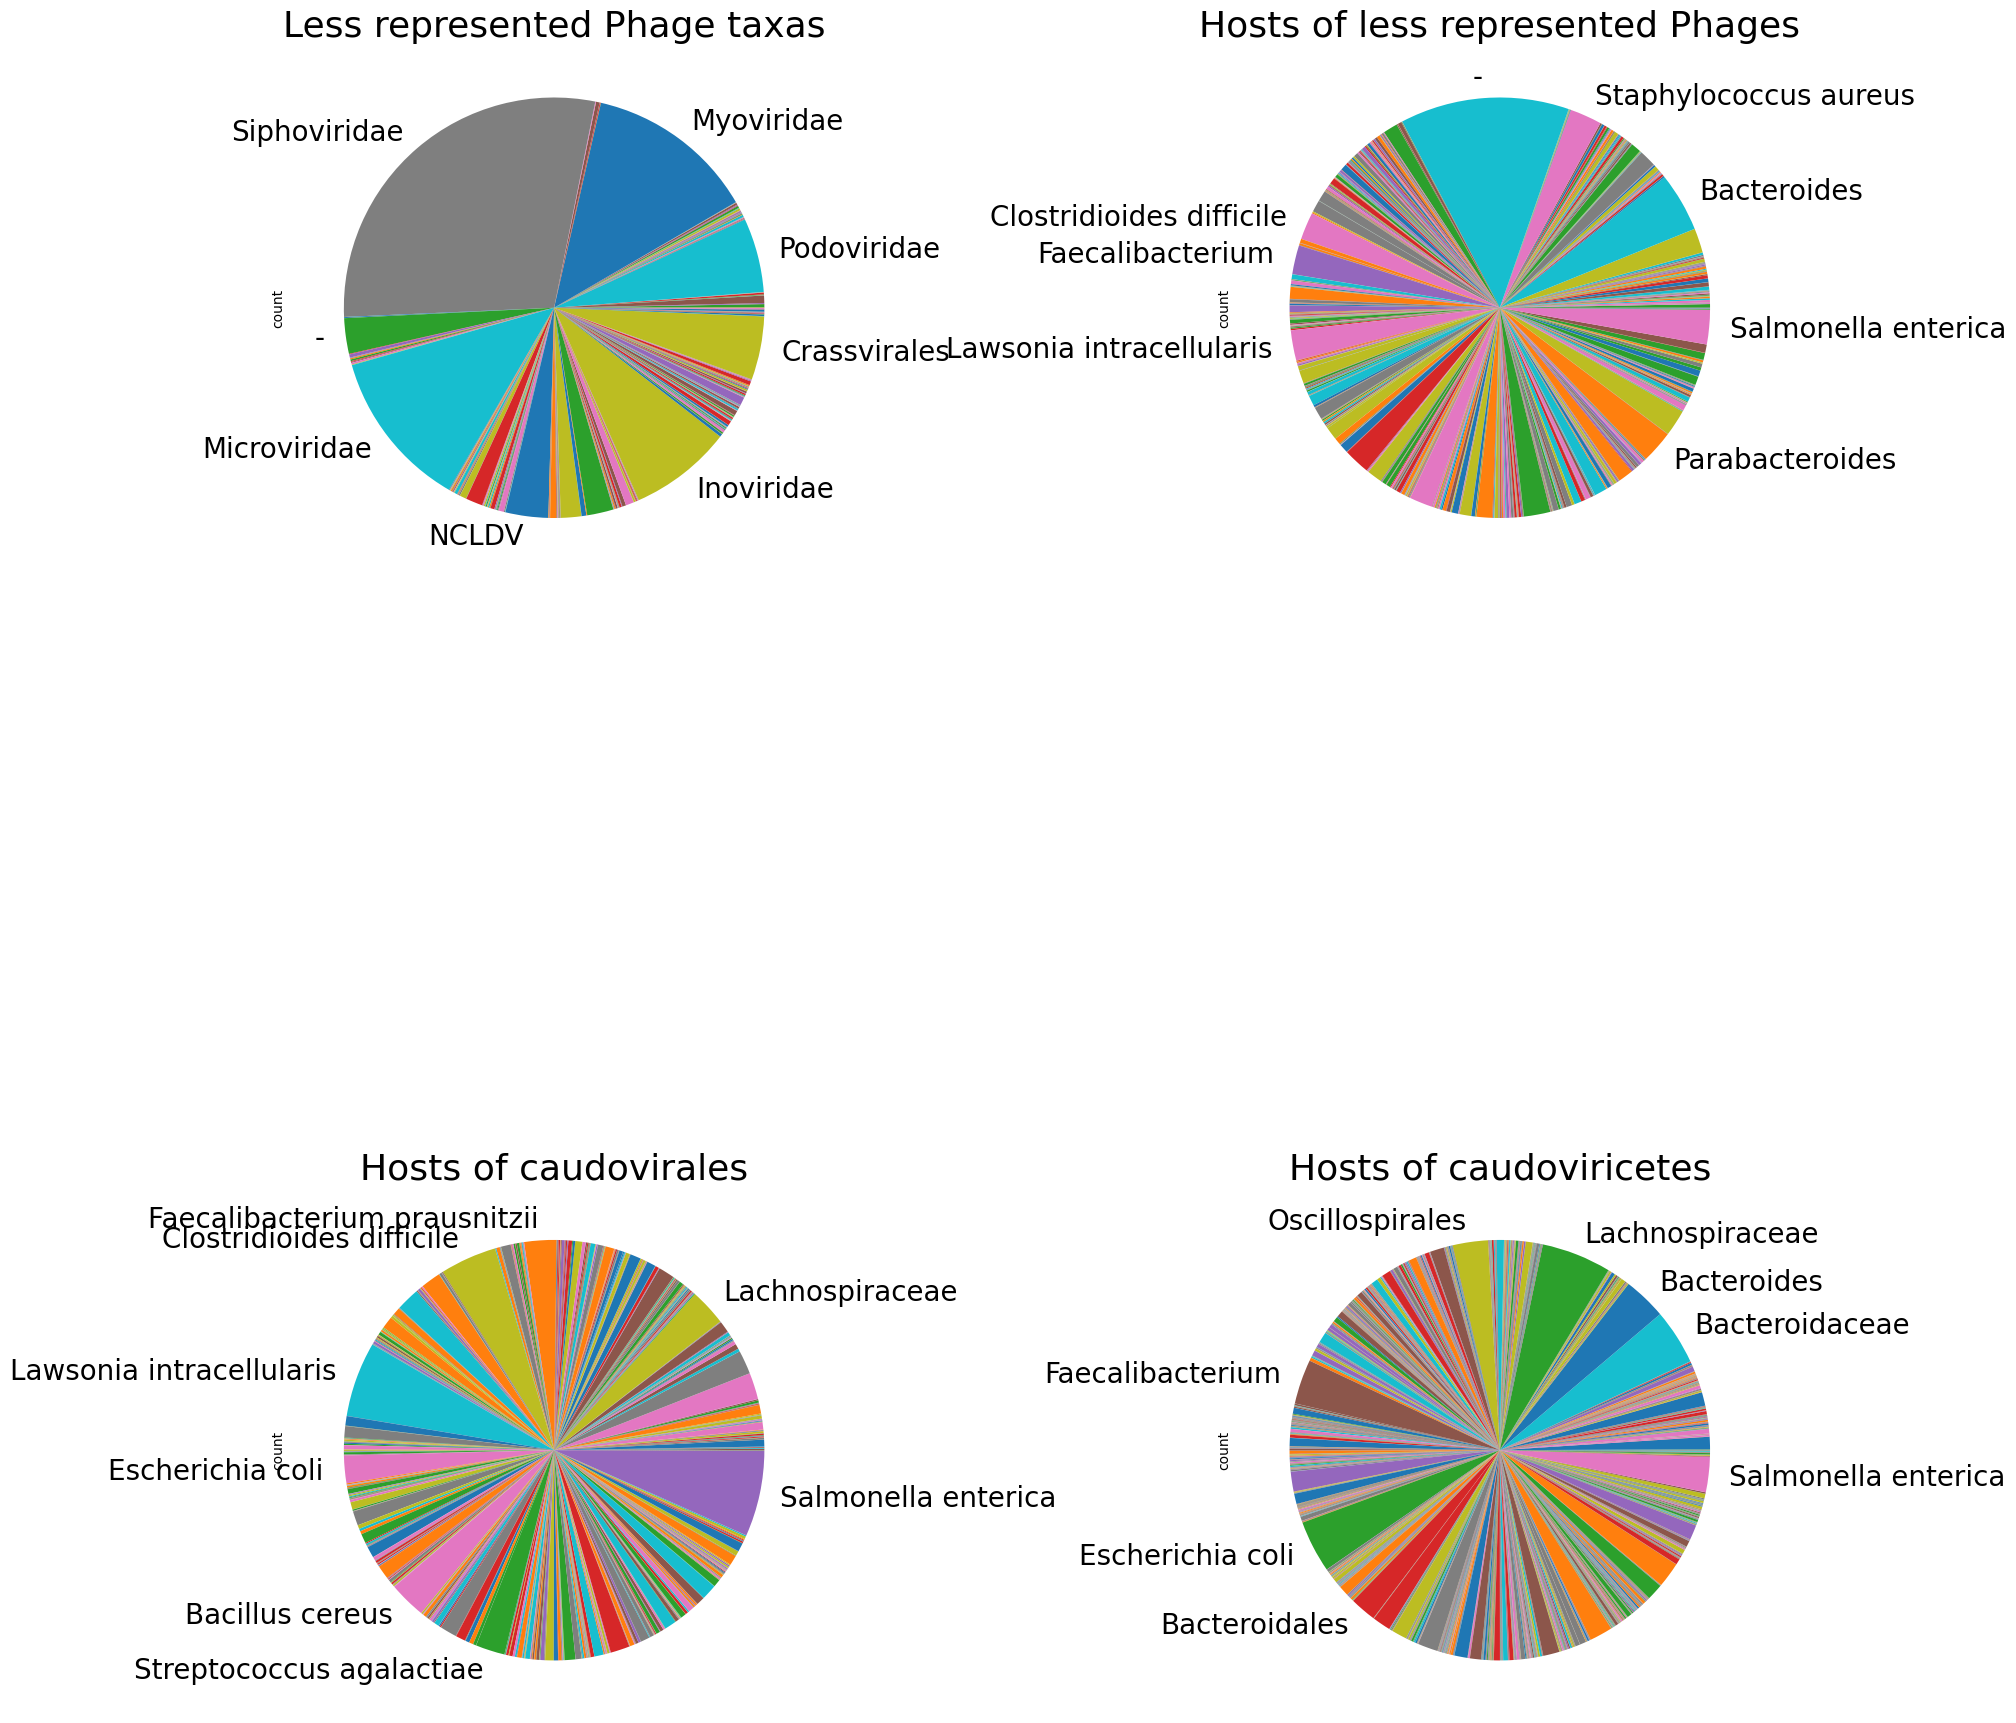

In [10]:

dfs = [phage_metadata, phage_metadata_caudovirales, phage_metadata_caudoviricetes, phage_metadata_else]
df_names = ['All phages', 'Caudovirales', 'Caudoviricetes', 'Less represented phages']



fig, axes = plt.subplots(2, 2, figsize=(20, 24))  # Adjust figure size as needed

top_5_phage_counts = phage_counts.nlargest(8)  # Get the top 5 categories
labels = [label if label in top_5_phage_counts.index else '' for label in phage_counts.index]

phage_counts.plot(kind='pie', ax=axes[0,0], title=f'Completeness counts ({df_names[0]})', fontsize=20, labels=labels)
axes[0,0].set_title('Less represented Phage taxas', fontsize = 26)

top_5_host_counts = host_counts.nlargest(8)  # Get the top 5 categories
labels = [label if label in top_5_host_counts.index else '' for label in host_counts.index]

host_counts.plot(kind='pie', ax=axes[0,1], title=f'Completeness counts ({df_names[1]})', fontsize=20, labels=labels)
axes[0,1].set_title('Hosts of less represented Phages', fontsize=26)

top_5_host_counts = host_counts_caudovirales.nlargest(8)  # Get the top 5 categories
labels = [label if label in top_5_host_counts.index else '' for label in host_counts_caudovirales.index]
host_counts_caudovirales.plot(kind='pie', ax=axes[1,0], title=f'Completeness counts ({df_names[2]})', fontsize=20, labels=labels)
axes[1,0].set_title('Hosts of caudovirales', fontsize=26)

top_5_host_counts = host_counts_caudoviricetes.nlargest(8)  # Get the top 5 categories
labels = [label if label in top_5_host_counts.index else '' for label in host_counts_caudoviricetes.index]
host_counts_caudoviricetes.plot(kind='pie', ax=axes[1,1], title=f'Completeness counts ({df_names[3]})', fontsize=20, labels=labels)
axes[1,1].set_title('Hosts of caudoviricetes', fontsize=26)


#plt.savefig('phage_taxa_distr.tif', format='TIFF')
plt.tight_layout()
plt.savefig('phage_and_hosts_counts.tiff', format='tiff', dpi=300)
plt.show()

In [11]:
ppm = explode_host_column(phage_metadata)
ppm

Dask DataFrame Structure:
               Phage_ID Length GC_content Taxonomy Completeness    Host Lifestyle Cluster Subcluster Phage_source
npartitions=14                                                                                                   
                 string  int64    float64   string       string  string    string  string     string       string
                    ...    ...        ...      ...          ...     ...       ...     ...        ...          ...
...                 ...    ...        ...      ...          ...     ...       ...     ...        ...          ...
                    ...    ...        ...      ...          ...     ...       ...     ...        ...          ...
                    ...    ...        ...      ...          ...     ...       ...     ...        ...          ...
Dask Name: astype, 6 expressions
Expr=AsType(frame=ExplodeFrame(frame=Assign(frame=ReadCSV(bc25c05)), column=['Host']), dtypes={'Taxonomy': 'string[pyarrow]', 'Host': 'string[pyarrow]'})

In [25]:
# Ricarico i 3 df 
#Load PHAGE METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\phage_metadata\*.tsv'  # Use a wildcard to select all TSV files
folder_path = folder_path.replace(os.sep, '/')
phage_metadata = dd.read_csv(folder_path, sep='\t')

phage_metadata_caudovirales = phage_metadata[phage_metadata['Taxonomy'] == 'Caudovirales']
phage_metadata_caudoviricetes = phage_metadata[phage_metadata['Taxonomy'] == 'Caudoviricetes']
phage_metadata_else = phage_metadata[(phage_metadata['Taxonomy'] != 'Caudovirales') & (phage_metadata['Taxonomy'] != 'Caudoviricetes')]

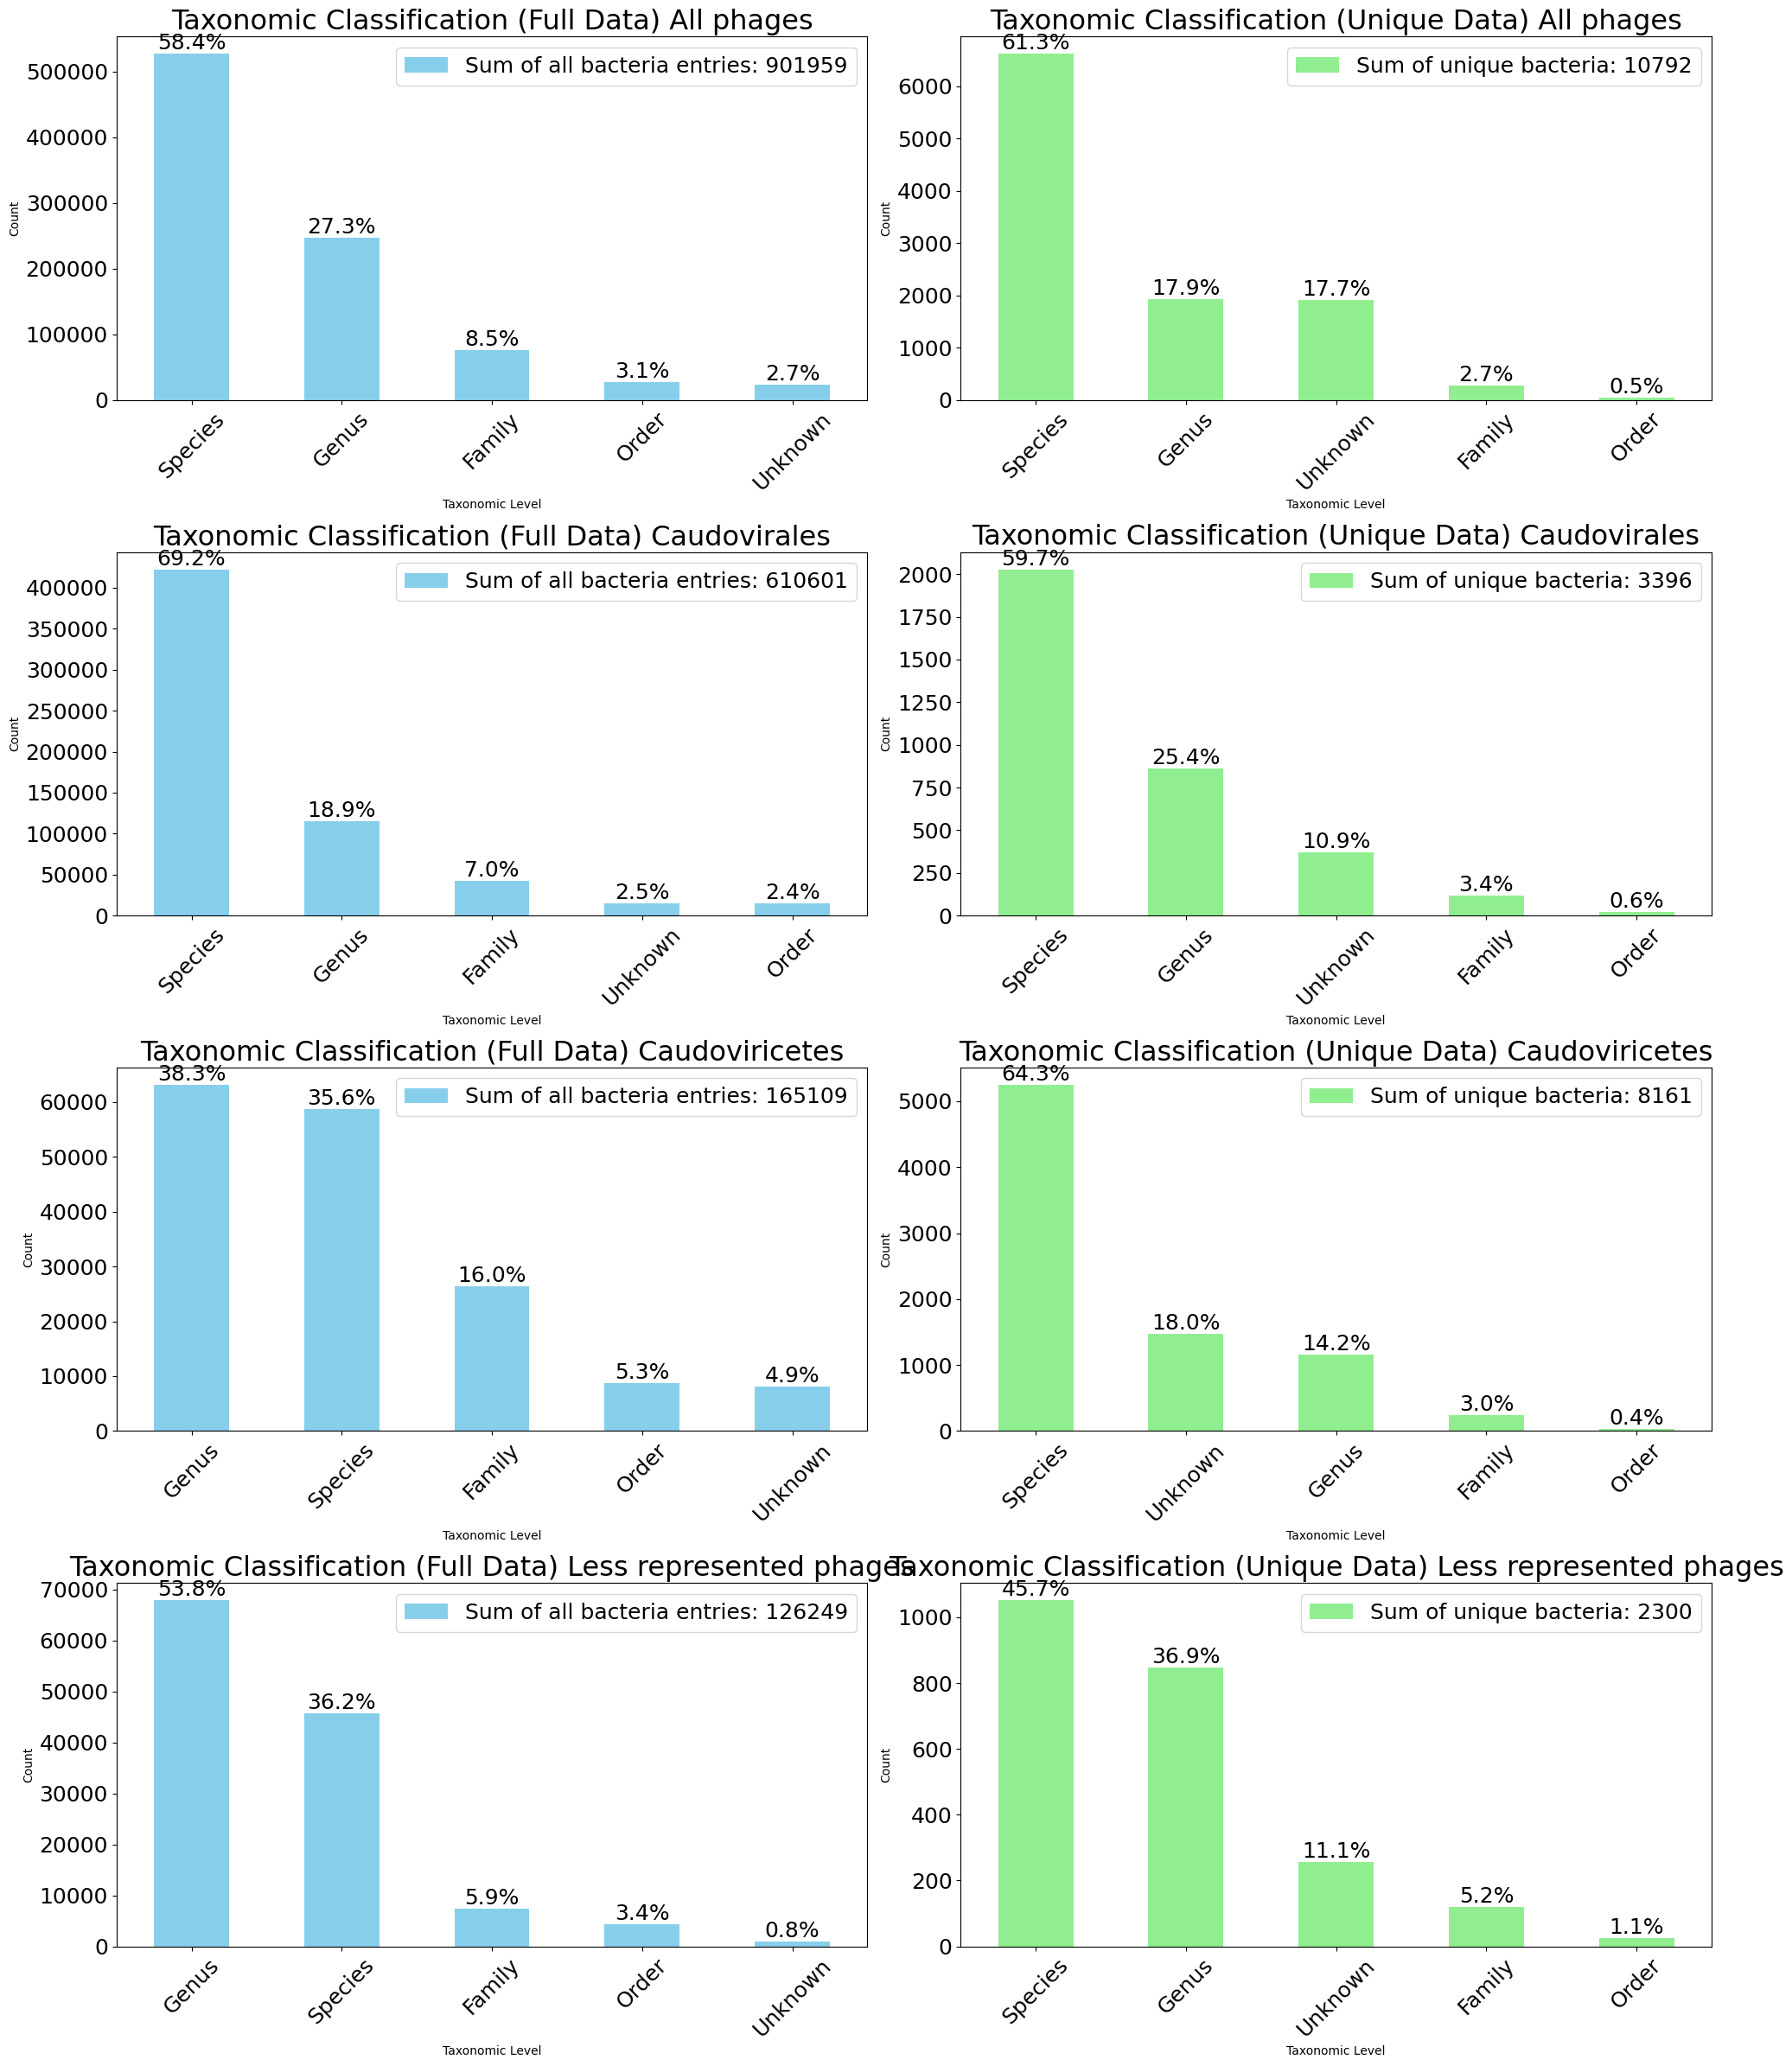

In [20]:

dfs = [explode_host_column(phage_metadata), 
       explode_host_column(phage_metadata_caudovirales), 
       explode_host_column(phage_metadata_caudoviricetes),
       explode_host_column(phage_metadata_else)]
df_names = ['All phages', 'Caudovirales', 'Caudoviricetes', 'Less represented phages']

# Create a figure with 4 rows and 2 columns (8 subplots total)
fig, axes = plt.subplots(4, 2, figsize=(20, 24)) 

for i, df in enumerate(dfs):
    
    
    
    
    data = df['Host'].compute()
    data = data.astype('string')
    

    # ALREADY DEFINED PREVIOUSLY
    def classify_taxonomic_level(entry):
        if pd.isna(entry):  # Check for missing values (None, NaN, NA)
            return 'Unknown'
        words = entry.split()
        
        if len(words) == 2:
            if words[1].lower() in ['sp.', 'spp.']:
                return 'Genus'
            else:
                return 'Species'
        elif len(words) == 1:
            if entry.endswith('aceae'):
                return 'Family'
            elif entry.endswith('ales'):
                return 'Order'
            else:
                return 'Genus'
        return 'Unknown'
    
    # Apply classification to the pandas series
    data_classified = data.apply(classify_taxonomic_level)
    category_counts = data_classified.value_counts()
    
    unique_data = pd.Series(data.unique())  # Get unique values from the data
    unique_classified = unique_data.apply(classify_taxonomic_level)
    unique_category_counts = unique_classified.value_counts()
    
    
    # Plot
    category_counts.plot(kind='bar', color='skyblue', ax=axes[i,0], fontsize=18)
    axes[i,0].set_title(f'Taxonomic Classification (Full Data) {df_names[i]}', fontsize=23)
    axes[i,0].set_ylabel('Count')
    axes[i,0].set_xlabel('Taxonomic Level')
    axes[i,0].tick_params(axis='x', rotation=45)
    # Add percentage labels on top of the bars
    
    category_percentages = (category_counts / category_counts.sum()) * 100
    
    for container in axes[i,0].containers:
        axes[i,0].bar_label(container, labels=[f'{p:.1f}%' for p in category_percentages], fontsize=18)
    axes[i,0].legend([f'Sum of all bacteria entries: {category_counts.sum()}'], loc='upper right', fontsize=18)
    
    
    
    # Plot for the unique values
    unique_category_counts.plot(kind='bar', color='lightgreen', ax=axes[i,1], fontsize=18)
    axes[i,1].set_title(f'Taxonomic Classification (Unique Data) {df_names[i]}', fontsize=23)
    axes[i,1].set_ylabel('Count')
    axes[i,1].set_xlabel('Taxonomic Level')
    axes[i,1].tick_params(axis='x', rotation=45)
    unique_category_percentages = (unique_category_counts / unique_category_counts.sum()) * 100
    
    for container in axes[i,1].containers:
        axes[i,1].bar_label(container, labels=[f'{p:.1f}%' for p in unique_category_percentages], fontsize=18)
    axes[i,1].legend([f'Sum of unique bacteria: {unique_category_counts.sum()}'], loc='upper right', fontsize=18)
    
    
    
plt.tight_layout()
plt.savefig('Taxonomic_classif_hosts.tiff', format='tiff', dpi=300)
plt.show()

In [26]:
#
# CONTINGENCY TABLE OF LESS REPRESENTED PHAGE TAXA
#

# Contingency table between Taxonomy and Host for less represented phages

p_m = phage_metadata_else.compute()
p_m = explode_host_column(p_m)
#p_m['Host'] = p_m['Host'].str.split(';')
#p_m_exploded = p_m.explode('Host')
#p_m = p_m.astype({'Taxonomy': 'string[pyarrow]', 'Host': 'string[pyarrow]'})

contingency_table = pd.crosstab(p_m['Taxonomy'], p_m['Host'])
contingency_table = contingency_table.drop('-', axis=1)

contingency_table

Host                  Salmonella enterica  2013Ark19i sp900078745  43-37  \
Taxonomy                                                                   
-                 0                     0                       0      0   
Ackermannviridae  0                     0                       0      0   
Adamviridae       0                     0                       0      0   
Adenoviridae      0                     0                       0      0   
Adrianviridae     0                     0                       0      0   
...              ..                   ...                     ...    ...   
β-crassviridae    0                     0                       0      0   
γ-crassviridae    0                     0                       0      0   
δ-crassviridae    0                     0                       0      0   
ε-crassviridae    0                     0                       0      0   
ζ-crassviridae    0                     0                       0      0   

Host              66-26 sp001897745  ALPHA2B sp901875635  \
Taxonomy                                                   
-                                 0                    0   
Ackermannviridae                  0                    0   
Adamviridae                       0                    0   
Adenoviridae                      0                    0   
Adrianviridae                     0                    0   
...                             ...                  ...   
β-crassviridae                    0                    0   
γ-crassviridae                    0                    0   
δ-crassviridae                    0                    0   
ε-crassviridae                    0                    0   
ζ-crassviridae                    0                    0   

Host              ATCCGGTTACGTAATGGAGCACATATTAGTTTGG  Absicoccus  \
Taxonomy                                                           
-                                                  0           0   
Ackermannviridae                                   0           0   
Adamviridae                                        0           0   
Adenoviridae                                       0           0   
Adrianviridae                                      0           0   
...                                              ...         ...   
β-crassviridae                                     0           0   
γ-crassviridae                                     0           0   
δ-crassviridae                                     0           0   
ε-crassviridae                                     0           0   
ζ-crassviridae                                     0           0   

Host              Absicoccus sp000434355  Absiella  ...  Zavarzinia  \
Taxonomy                                            ...               
-                                      0         0  ...           0   
Ackermannviridae                       0         0  ...           0   
Adamviridae                            0         0  ...           0   
Adenoviridae                           0         0  ...           0   
Adrianviridae                          0         0  ...           0   
...                                  ...       ...  ...         ...   
β-crassviridae                         0         0  ...           0   
γ-crassviridae                         0         0  ...           0   
δ-crassviridae                         0         0  ...           0   
ε-crassviridae                         0         0  ...           0   
ζ-crassviridae                         0         0  ...           0   

Host              Zetaproteobacteria  Zobellella  Zymomonas mobilis  \
Taxonomy                                                              
-                                  0           0                  0   
Ackermannviridae                   0           0                  0   
Adamviridae                        0           0                  0   
Adenoviridae                       0           0                  

In [27]:

print('Total n of PHIs:')
contingency_table.astype(bool).sum(axis=0).sum()

Total n of PHIs:


4184

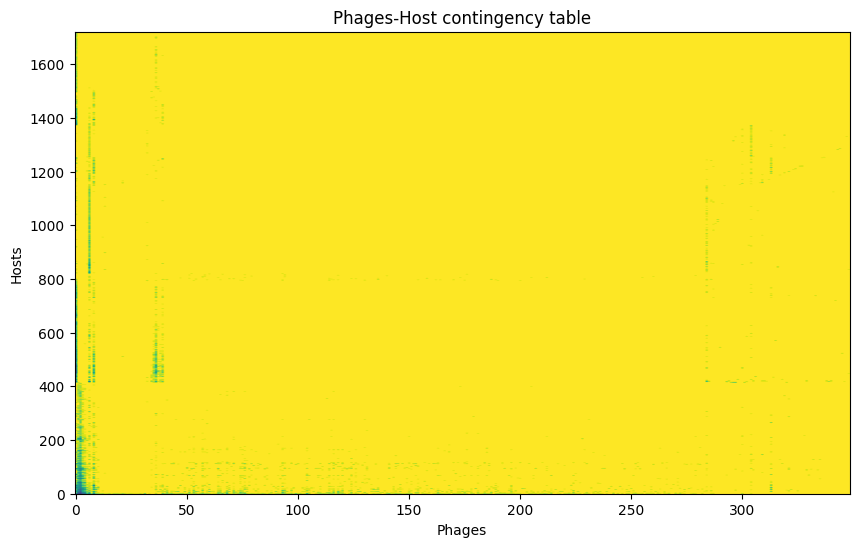

2024-10-08 19:46:27,551 - distributed.scheduler - WARNING - Worker failed to heartbeat for 848s; attempting restart: <WorkerState 'tcp://127.0.0.1:55805', name: 0, status: running, memory: 0, processing: 0>
2024-10-08 19:46:27,552 - distributed.scheduler - WARNING - Worker failed to heartbeat for 848s; attempting restart: <WorkerState 'tcp://127.0.0.1:55806', name: 1, status: running, memory: 0, processing: 0>
2024-10-08 19:46:27,553 - distributed.scheduler - WARNING - Worker failed to heartbeat for 848s; attempting restart: <WorkerState 'tcp://127.0.0.1:55807', name: 3, status: running, memory: 0, processing: 0>
2024-10-08 19:46:27,553 - distributed.scheduler - WARNING - Worker failed to heartbeat for 848s; attempting restart: <WorkerState 'tcp://127.0.0.1:55814', name: 2, status: running, memory: 0, processing: 0>
2024-10-08 19:46:28,506 - distributed.nanny - WARNING - Restarting worker
2024-10-08 19:46:28,568 - distributed.nanny - WARNING - Restarting worker
2024-10-08 19:46:28,600 

In [28]:
from datashader.utils import export_image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

phage_metadata_pandas = p_m

phage_metadata_pandas['Taxonomy'], col1_codes = pd.factorize(phage_metadata_pandas['Taxonomy'])
phage_metadata_pandas['Host'], col2_codes = pd.factorize(phage_metadata_pandas['Host'])

canvas = ds.Canvas(plot_width=349, plot_height=1722)
agg = canvas.points(phage_metadata_pandas, 'Taxonomy', 'Host', agg=ds.count())
img = ds.tf.shade(agg, cmap='red', how='log')

# Convert the Datashader image to a format that Matplotlib can use
exported_img = export_image(img, "plot", background="white")

# Plot the image with Matplotlib and add labels
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(exported_img, aspect='auto', origin='lower')

# Add labels and title
ax.set_title('Phages-Host contingency table')
ax.set_xlabel('Phages')
ax.set_ylabel('Hosts')

fig.savefig('Less_represented_Phage_Host_contingency_table.tif', format='TIFF')

plt.show()



In [448]:
!pip install networkx

In [41]:
# TURN THE CONTINGENCY TABLE INTO A GRAPH
import networkx as nx


G = nx.Graph()

# Add edges between Taxa and Hosts with weights
for taxon in contingency_table.index:
    for host in contingency_table.columns:
        weight = contingency_table.loc[taxon, host]
        if weight > 0:  # Only add edges with positive weights
            G.add_edge(taxon, host, weight=weight)
#print(G.edges(data=True))

taxa = contingency_table.index  # 50 host nodes
hosts = contingency_table.columns  # 50 taxon nodes

# Color the nodes based on whether they are Taxa or Hosts
for node in G.nodes():
    if node in taxa:
        G.nodes[node]['color'] = 'lightgreen'  # Taxa nodes
    elif node in hosts:
        G.nodes[node]['color'] = 'lightblue'   # Host nodes



In [42]:
# ENSURE GRAPH IS A STANDARD INT OR FLOAT
# IPYSIGMA DOESN'T WORK OTHERWISE

for node, data in G.nodes(data=True):
    for key, value in data.items():
        if isinstance(value, (int, float)):
            data[key] = int(value) if isinstance(value, (int, float)) else str(value)  # Convert int/float to standard types

for u, v, d in G.edges(data=True):
    d['weight'] = int(d['weight'])



In [43]:
# PRINT THE GRAPH

pos = nx.spring_layout(G)  # pos is a dictionary of node positions

# Format positions as needed by ipysigma (x, y dict per node)
formatted_pos = {node: {'x': float(x), 'y': float(y)} for node, (x, y) in pos.items()}

from ipysigma import Sigma

Sigma.write_html(
    G,
    './phage-host_graph.html',
    fullscreen=True,
    node_metrics=['louvain'],
    layout=formatted_pos,
    #node_color='louvain',
    raw_node_color='color',
    node_size_range=(3, 20),
    max_categorical_colors=30,
    default_edge_type='curve',
    node_border_color_from='node',
    default_node_label_size=14,
    node_size=G.degree
)


In [ ]:
!pip install holoviews hvplot

In [ ]:
!pip install pyvis

In [ ]:
!pip install ipysigma

In [ ]:
!pip install pelote

In [ ]:
pip install -U ipywidgets

In [ ]:
#
# CHORD GRAPH TOO SLOW
#

# import pandas as pd
# import holoviews as hv
# from holoviews import opts, dim

# # Step 1: Initialize Holoviews and the Bokeh backend
# hv.extension('bokeh')  # Ensure that Holoviews uses Bokeh for plotting
# hv.output(size=200)  # Set the default output size for plots


# # Step 4: Reshape the table for the chord diagram
# links = contingency_table.reset_index().melt(id_vars='Taxonomy', var_name='Host', value_name='Count')
# links['Count']=links['Count'].astype(int)
# # Step 5: Set a threshold for filtering (e.g., interactions with counts >= 50)
# #threshold = 50
# #links_filtered = links[links['Count'] >= threshold]
# links

#hv.Chord(links)

# PROTEIN ANALYS REMOVING CAUDOVIRALES AND CAUDOVIRICETES

In [19]:
#Load PROTEIN METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\annotated_protein_metadata\*.tsv'  # Use * to select all TSV files in the folder
folder_path = folder_path.replace(os.sep, '/')
start = time.time()
ddf = dd.read_csv(folder_path, sep='\t', dtype={'Instability_index': 'object',
       'Molecular_weight': 'object'})

#Load PHAGE METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\phage_metadata\*.tsv'  # Use a wildcard to select all TSV files
folder_path = folder_path.replace(os.sep, '/')
phage_metadata = dd.read_csv(folder_path, sep='\t')



In [5]:
ddf.head()

Phage_ID Protein_source Function_Prediction_source  Start  \
0  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper    319   
1  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper   1062   
2  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper   1398   
3  SRS101376_a1_ct99314_vs01       prodigal              eggNOG-mapper   1718   
4  SRS101376_a1_ct99314_vs01       prodigal                          -   2145   

   Stop Strand                   Protein_ID  \
0  1062      -  SRS101376_a1_ct99314_vs01_1   
1  1385      -  SRS101376_a1_ct99314_vs01_2   
2  1718      -  SRS101376_a1_ct99314_vs01_3   
3  2155      -  SRS101376_a1_ct99314_vs01_4   
4  2276      -  SRS101376_a1_ct99314_vs01_5   

                                  Product Protein_classification  \
0      N-acetylmuramoyl-L-alanine amidase              unsorted;   
1                    hypothetical protein          hypothetical;   
2  Psort location Cytoplasmic, score 8.87              assembly;   
3                    hypothetical protein          hypothetical;   
4                                 unknown              unsorted;   

    Molecular_weight  Aromaticity   Instability_index  Isoelectric_point  \
0          4186.6396     0.054054   22.98918918918919           5.664426   
1           3630.987     0.027027  0.9459459459459463           4.427894   
2  3685.323799999999     0.027778  23.205555555555563          11.000385   
3            623.652     0.200000               56.22           4.050028   
4  4829.349899999999     0.046512   52.20232558139535           4.827017   

   Helix_fraction  Turn_fraction  Sheet_fraction  Reduced_coefficient  \
0        0.270270       0.081081        0.405405                 2980   
1        0.216216       0.162162        0.405405                 1490   
2        0.388889       0.250000        0.277778                 5500   
3        0.400000       0.000000        0.400000                    0   
4        0.186047       0.069767        0.511628                 2980   

   Oxidized_coefficient Phage_source  
0                  2980         CHVD  
1                  1490         CHVD  
2                  5500         CHVD  
3                     0         CHVD  
4                  2980         CHVD

In [45]:
phage_metadata.head()

Phage_ID  Length  GC_content      Taxonomy  \
0     SRS101376_a1_ct99314_vs01   31763   50.511602    Myoviridae   
1     SRS101388_a1_ct42327_vs01  223331   42.421339    Myoviridae   
2     SRS101376_a1_ct26874_vs01   25835   52.897232    Myoviridae   
3       SAMEA1906416_a1_ct13001   53468   40.515823  Siphoviridae   
4  SAMEA1906416_a1_ct130485_vs1   23523   61.658802  Siphoviridae   

     Completeness             Host Lifestyle         Cluster  \
0    High-quality         Gemmiger  virulent   cluster_33392   
1    High-quality        Neisseria  virulent  cluster_340704   
2     Low-quality                -  virulent  cluster_208857   
3    High-quality  Lachnospiraceae  virulent  cluster_243648   
4  Medium-quality  Bifidobacterium  virulent   cluster_44056   

          Subcluster Phage_source  
0   subcluster_40629         CHVD  
1  subcluster_411447         CHVD  
2  subcluster_251798         CHVD  
3  subcluster_294650         CHVD  
4   subcluster_53753         CHVD

In [4]:
# create protein dataset of only caudovirales, only caudoviricetes and everything else

#prot_m = ddf[['Phage_ID', 'Start', 'Stop']]
prot_m = ddf[['Phage_ID', 'Protein_classification']]
phage_m = phage_metadata[['Phage_ID', 'Taxonomy']]


#columns = ['Molecular_weight', 'Aromaticity', 'Instability_index', 'Isoelectric_point', 'Helix_fraction', 'Turn_fraction', 'Sheet_fraction', 'Reduced_coefficient', 'Oxidized_coefficient']


merged_data = prot_m.merge(phage_m, on='Phage_ID')


In [7]:
merged_data.head()

Phage_ID Protein_classification      Taxonomy
0  LN681537.2          hypothetical;  Caudovirales
1  LN681537.2          hypothetical;  Caudovirales
2  LN681537.2              unsorted;  Caudovirales
3  LN681537.2          hypothetical;  Caudovirales
4  LN681537.2          hypothetical;  Caudovirales

In [5]:
prot_caudovirales = merged_data[merged_data['Taxonomy'] == 'Caudovirales']
prot_caudoviricetes = merged_data[merged_data['Taxonomy'] == 'Caudoviricetes']
prot_else = merged_data[(merged_data['Taxonomy'] != 'Caudovirales') & (merged_data['Taxonomy'] != 'Caudoviricetes')]


In [ ]:
prot_else.head()

In [7]:
def count_protein_categories(df, name):
    # Split the "Protein_classification" column into multiple rows
    split_df = df['Protein_classification'].str.split(';').explode()

    # Remove any empty strings that might result from splitting
    split_df = split_df[split_df != '']

    # Compute the value counts for each individual category
    value_counts = split_df.value_counts().compute()

    # Total number of proteins
    total_proteins = len(split_df)

    # Compute the percentage of proteins in each category
    percentages = (value_counts / total_proteins) * 100

    # Display the total number of proteins
    print(f"\nTotal number of proteins in {name}: {total_proteins}")

    # Display the number of unique categories
    num_categories = value_counts.index.size
    print(f"Number of unique categories in {name}: {num_categories}")

    # Display the count of items in each category along with the percentage
    print(f"Counts and percentage of each category in {name}:")
    result_df = pd.DataFrame({'Count': value_counts, 'Percentage (%)': percentages})
    print(result_df)
    return value_counts

# Apply the function to each DataFrame
value_counts_all = count_protein_categories(ddf, "All taxa")
value_counts_caudovirales = count_protein_categories(prot_caudovirales, "Caudovirales")
value_counts_caudoviricetes = count_protein_categories(prot_caudoviricetes, "Caudoviricetes")
value_counts_else = count_protein_categories(prot_else, "Other")


2024-10-04 12:52:33,818 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cef01beca17b82605b2f1d03a1af3b21 initialized by task ('hash-join-transfer-cef01beca17b82605b2f1d03a1af3b21', 121) executed on worker tcp://127.0.0.1:63413
2024-10-04 12:52:35,291 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle adaa687da25b7509a09e3aadbc9b221f initialized by task ('hash-join-transfer-adaa687da25b7509a09e3aadbc9b221f', 7) executed on worker tcp://127.0.0.1:63413
2024-10-04 12:53:36,860 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c7580b19a7b9e4121e24c3fba700d8b3 initialized by task ('shuffle-transfer-c7580b19a7b9e4121e24c3fba700d8b3', 107) executed on worker tcp://127.0.0.1:63416
2024-10-04 12:54:21,253 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle adaa687da25b7509a09e3aadbc9b221f deactivated due to stimulus 'task-finished-1728039261.2338326'
2024-10-04 12:54:21,253 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cef01beca17b82605b2f1d0


Total number of proteins in Caudovirales: 29703893
Number of unique categories in Caudovirales: 11
Counts and percentage of each category in Caudovirales:
                           Count  Percentage (%)
Protein_classification                          
infection                2655179        8.938825
unsorted                13170835       44.340434
tRNA_related              134163        0.451668
integration              1046872        3.524360
replication              2613376        8.798093
packaging                1338413        4.505850
hypothetical             1457454        4.906609
lysis                    1255223        4.225786
assembly                 3790767       12.761852
immune                    662589        2.230647
regulation               1579022        5.315876


2024-10-04 12:56:19,472 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3a464269a3b61082aca23b76e3faae59 initialized by task ('hash-join-transfer-3a464269a3b61082aca23b76e3faae59', 99) executed on worker tcp://127.0.0.1:63410
2024-10-04 12:56:21,092 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f101e30e3e25459fe3754670a78b99d9 initialized by task ('hash-join-transfer-f101e30e3e25459fe3754670a78b99d9', 6) executed on worker tcp://127.0.0.1:63416
2024-10-04 12:57:20,605 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle dc2a31a8b6300d6967da99fa97efa150 initialized by task ('shuffle-transfer-dc2a31a8b6300d6967da99fa97efa150', 90) executed on worker tcp://127.0.0.1:63416
2024-10-04 12:57:49,908 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f101e30e3e25459fe3754670a78b99d9 deactivated due to stimulus 'task-finished-1728039469.9019144'
2024-10-04 12:57:49,908 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3a464269a3b61082aca23b76e


Total number of proteins in Caudoviricetes: 11856951
Number of unique categories in Caudoviricetes: 11
Counts and percentage of each category in Caudoviricetes:
                          Count  Percentage (%)
Protein_classification                         
infection                356754        3.008817
unsorted                7845492       66.167871
tRNA_related               8454        0.071300
integration              180089        1.518847
replication              411851        3.473498
packaging                227473        1.918478
hypothetical            1763016       14.869050
lysis                    196267        1.655291
assembly                 566350        4.776523
immune                    67628        0.570366
regulation               233577        1.969958


2024-10-04 12:59:30,332 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9c5b4e1ddf66da40f5df0c339d427994 initialized by task ('hash-join-transfer-9c5b4e1ddf66da40f5df0c339d427994', 4) executed on worker tcp://127.0.0.1:63416
2024-10-04 12:59:32,611 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30ffd4a29cc021014c4f1bda00fb0a3b initialized by task ('hash-join-transfer-30ffd4a29cc021014c4f1bda00fb0a3b', 6) executed on worker tcp://127.0.0.1:63416
2024-10-04 13:01:00,425 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7a6f67183249e9ad0f4e4b0a7c341065 initialized by task ('shuffle-transfer-7a6f67183249e9ad0f4e4b0a7c341065', 64) executed on worker tcp://127.0.0.1:63407
2024-10-04 13:01:22,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30ffd4a29cc021014c4f1bda00fb0a3b deactivated due to stimulus 'task-finished-1728039682.2600775'
2024-10-04 13:01:22,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9c5b4e1ddf66da40f5df0c339d


Total number of proteins in Other: 4950573
Number of unique categories in Other: 11
Counts and percentage of each category in Other:
                          Count  Percentage (%)
Protein_classification                         
infection                254024        5.131204
unsorted                2695072       54.439597
tRNA_related              16207        0.327376
integration              126520        2.555664
replication              323769        6.540031
packaging                149846        3.026842
hypothetical             562107       11.354383
lysis                    150190        3.033790
assembly                 469578        9.485326
immune                    60596        1.224020
regulation               142664        2.881767


2024-10-04 16:23:01,880 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11614s; attempting restart: <WorkerState 'tcp://127.0.0.1:63407', name: 0, status: running, memory: 0, processing: 0>
2024-10-04 16:23:01,886 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11614s; attempting restart: <WorkerState 'tcp://127.0.0.1:63410', name: 3, status: running, memory: 0, processing: 0>
2024-10-04 16:23:01,886 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11614s; attempting restart: <WorkerState 'tcp://127.0.0.1:63413', name: 1, status: running, memory: 0, processing: 0>
2024-10-04 16:23:01,886 - distributed.scheduler - WARNING - Worker failed to heartbeat for 11614s; attempting restart: <WorkerState 'tcp://127.0.0.1:63416', name: 2, status: running, memory: 0, processing: 0>
2024-10-04 16:23:06,048 - distributed.nanny - WARNING - Restarting worker
2024-10-04 16:23:06,062 - distributed.nanny - WARNING - Restarting worker
2024-10-04 16:23

Text(0.5, 1.0, 'Protein categories taxa caudovirecetes')

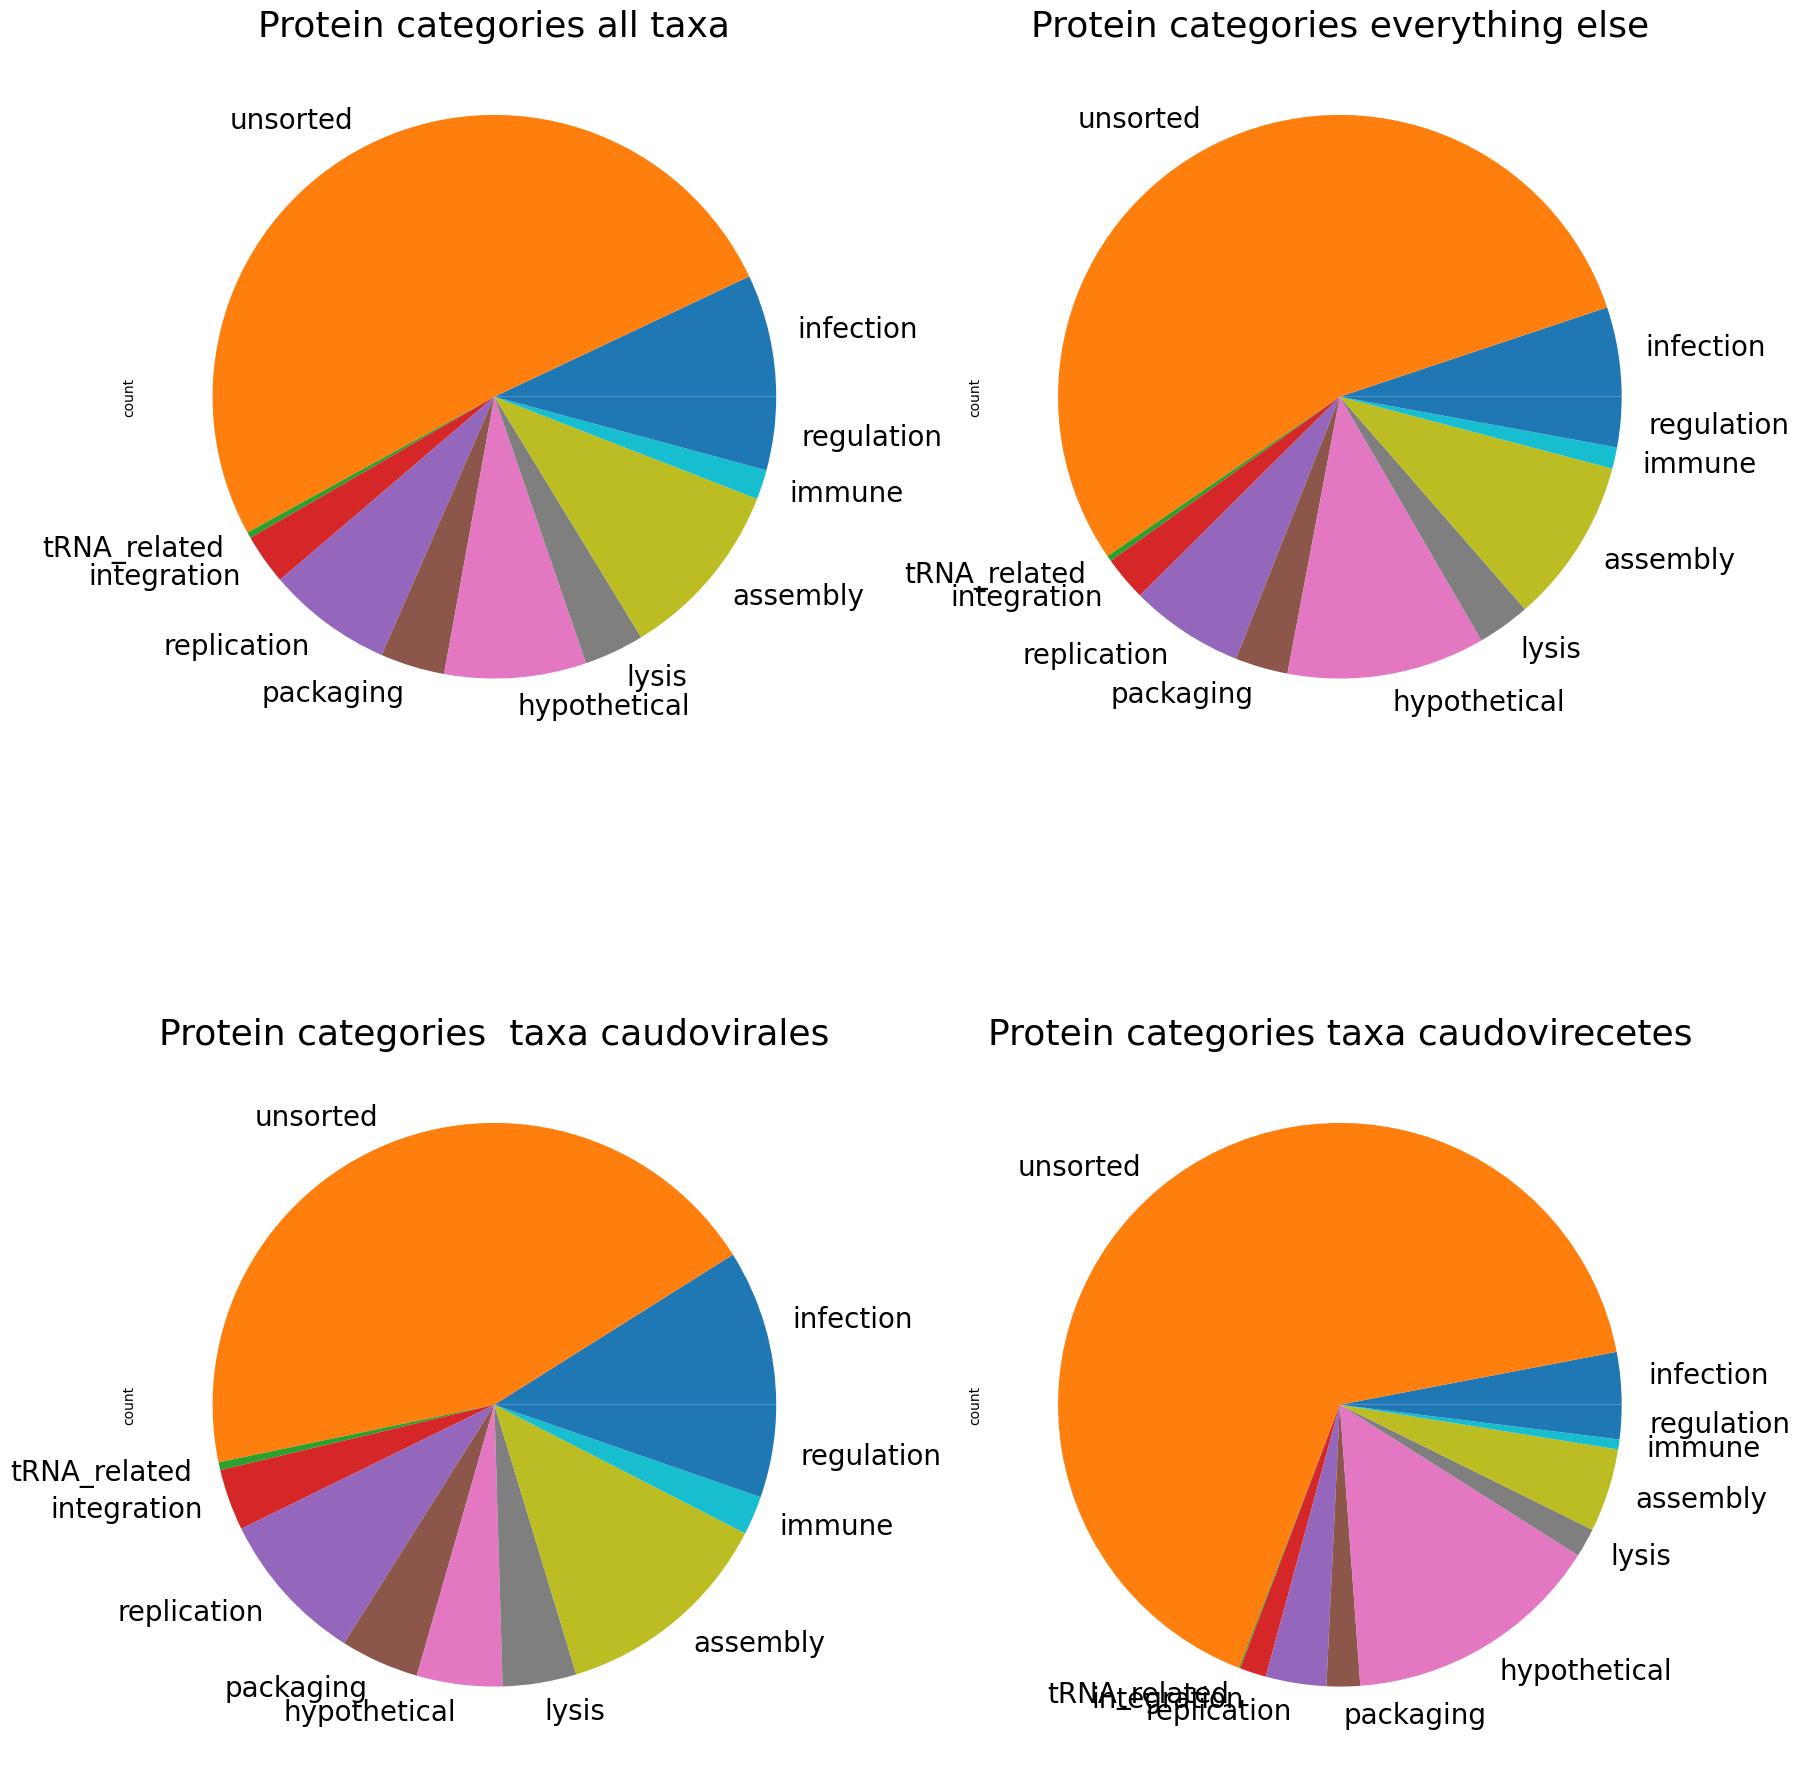

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 24))  # Adjust figure size as needed

value_counts_all.plot(kind='pie', ax=axes[0,0], fontsize=20)
axes[0,0].set_title('Protein categories all taxa', fontsize = 26)

value_counts_else.plot(kind='pie', ax=axes[0,1], fontsize=20)
axes[0,1].set_title('Protein categories everything else', fontsize = 26)

value_counts_caudovirales.plot(kind='pie', ax=axes[1,0], fontsize=20)
axes[1,0].set_title('Protein categories  taxa caudovirales', fontsize = 26)

value_counts_caudoviricetes.plot(kind='pie', ax=axes[1,1], fontsize=20)
axes[1,1].set_title('Protein categories taxa caudovirecetes', fontsize = 26)



In [ ]:
prot_else = prot_else.compute()

In [29]:
prot_else.head()

Phage_ID Protein_classification Taxonomy
0  SAMEA1906424_a1_ct74408_vs1              unsorted;        -
1  SAMEA1906424_a1_ct74408_vs1          hypothetical;        -
2  SAMEA1906424_a1_ct74408_vs1          hypothetical;        -
3  SAMEA1906424_a1_ct74408_vs1          hypothetical;        -
4  SAMEA1906424_a1_ct74408_vs1          hypothetical;        -

In [8]:
protein_counts_all = ddf.groupby('Phage_ID')['Protein_classification'].size().compute()

2024-10-04 17:15:01,579 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4dc5ccf1b170f7ff2508048a74b780d9 initialized by task ('shuffle-transfer-4dc5ccf1b170f7ff2508048a74b780d9', 54) executed on worker tcp://127.0.0.1:65120
2024-10-04 17:15:42,650 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4dc5ccf1b170f7ff2508048a74b780d9 deactivated due to stimulus 'task-finished-1728054942.6466281'


In [10]:
protein_counts_else = prot_else.groupby('Phage_ID')['Protein_classification'].size().compute()

2024-10-04 17:16:46,159 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9c5b4e1ddf66da40f5df0c339d427994 initialized by task ('hash-join-transfer-9c5b4e1ddf66da40f5df0c339d427994', 155) executed on worker tcp://127.0.0.1:65122
2024-10-04 17:16:48,319 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30ffd4a29cc021014c4f1bda00fb0a3b initialized by task ('hash-join-transfer-30ffd4a29cc021014c4f1bda00fb0a3b', 7) executed on worker tcp://127.0.0.1:65121
2024-10-04 17:18:05,956 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9c5b4e1ddf66da40f5df0c339d427994 deactivated due to stimulus 'task-finished-1728055085.94543'
2024-10-04 17:18:05,956 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30ffd4a29cc021014c4f1bda00fb0a3b deactivated due to stimulus 'task-finished-1728055085.94543'


In [18]:
protein_counts_else

Phage_ID
Han_2018_ERR1398069_NODE_2604_length_6546_cov_107.071330      7
Han_2018_ERR1398079_NODE_2482_length_5428_cov_25.753397       2
Han_2018_ERR1398138_NODE_3048_length_5012_cov_2.687311        3
Han_2018_ERR1398162_NODE_2461_length_10216_cov_5.878752       5
Han_2018_ERR1398171_NODE_1300_length_10881_cov_249.332163     5
                                                             ..
uvig_578599                                                  52
uvig_582169                                                  21
uvig_59606                                                   20
uvig_88775                                                   18
uvig_96901                                                   23
Name: Protein_classification, Length: 125149, dtype: Int64

In [12]:
protein_counts_caudovirales = prot_caudovirales.groupby('Phage_ID')['Protein_classification'].size().compute()

2024-10-04 17:18:59,030 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cef01beca17b82605b2f1d03a1af3b21 initialized by task ('hash-join-transfer-cef01beca17b82605b2f1d03a1af3b21', 50) executed on worker tcp://127.0.0.1:65122
2024-10-04 17:19:01,106 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle adaa687da25b7509a09e3aadbc9b221f initialized by task ('hash-join-transfer-adaa687da25b7509a09e3aadbc9b221f', 6) executed on worker tcp://127.0.0.1:65122
2024-10-04 17:20:21,163 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cef01beca17b82605b2f1d03a1af3b21 deactivated due to stimulus 'task-finished-1728055221.1667826'
2024-10-04 17:20:21,175 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle adaa687da25b7509a09e3aadbc9b221f deactivated due to stimulus 'task-finished-1728055221.1667826'


In [14]:
protein_counts_caudoviricetes = prot_caudoviricetes.groupby('Phage_ID')['Protein_classification'].size().compute()

2024-10-04 17:21:07,993 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a315278dc2eb5da4ef9e3e907b9590ee initialized by task ('hash-join-transfer-a315278dc2eb5da4ef9e3e907b9590ee', 9) executed on worker tcp://127.0.0.1:65119
2024-10-04 17:21:09,701 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 67530bd54c5202996b85a41436ddc68f initialized by task ('hash-join-transfer-67530bd54c5202996b85a41436ddc68f', 7) executed on worker tcp://127.0.0.1:65121
2024-10-04 17:22:56,843 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 67530bd54c5202996b85a41436ddc68f deactivated due to stimulus 'task-finished-1728055376.8233728'
2024-10-04 17:22:56,843 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a315278dc2eb5da4ef9e3e907b9590ee deactivated due to stimulus 'task-finished-1728055376.8233728'


In [6]:
#
# HOW MANY PROTEINS PER PHAGE
#


protein_counts_all = ddf.groupby('Phage_ID')['Protein_classification'].size().compute()
protein_counts_else = prot_else.groupby('Phage_ID')['Protein_classification'].size().compute()
protein_counts_caudovirales = prot_caudovirales.groupby('Phage_ID')['Protein_classification'].size().compute()
protein_counts_caudoviricetes = prot_caudoviricetes.groupby('Phage_ID')['Protein_classification'].size().compute()




KeyboardInterrupt



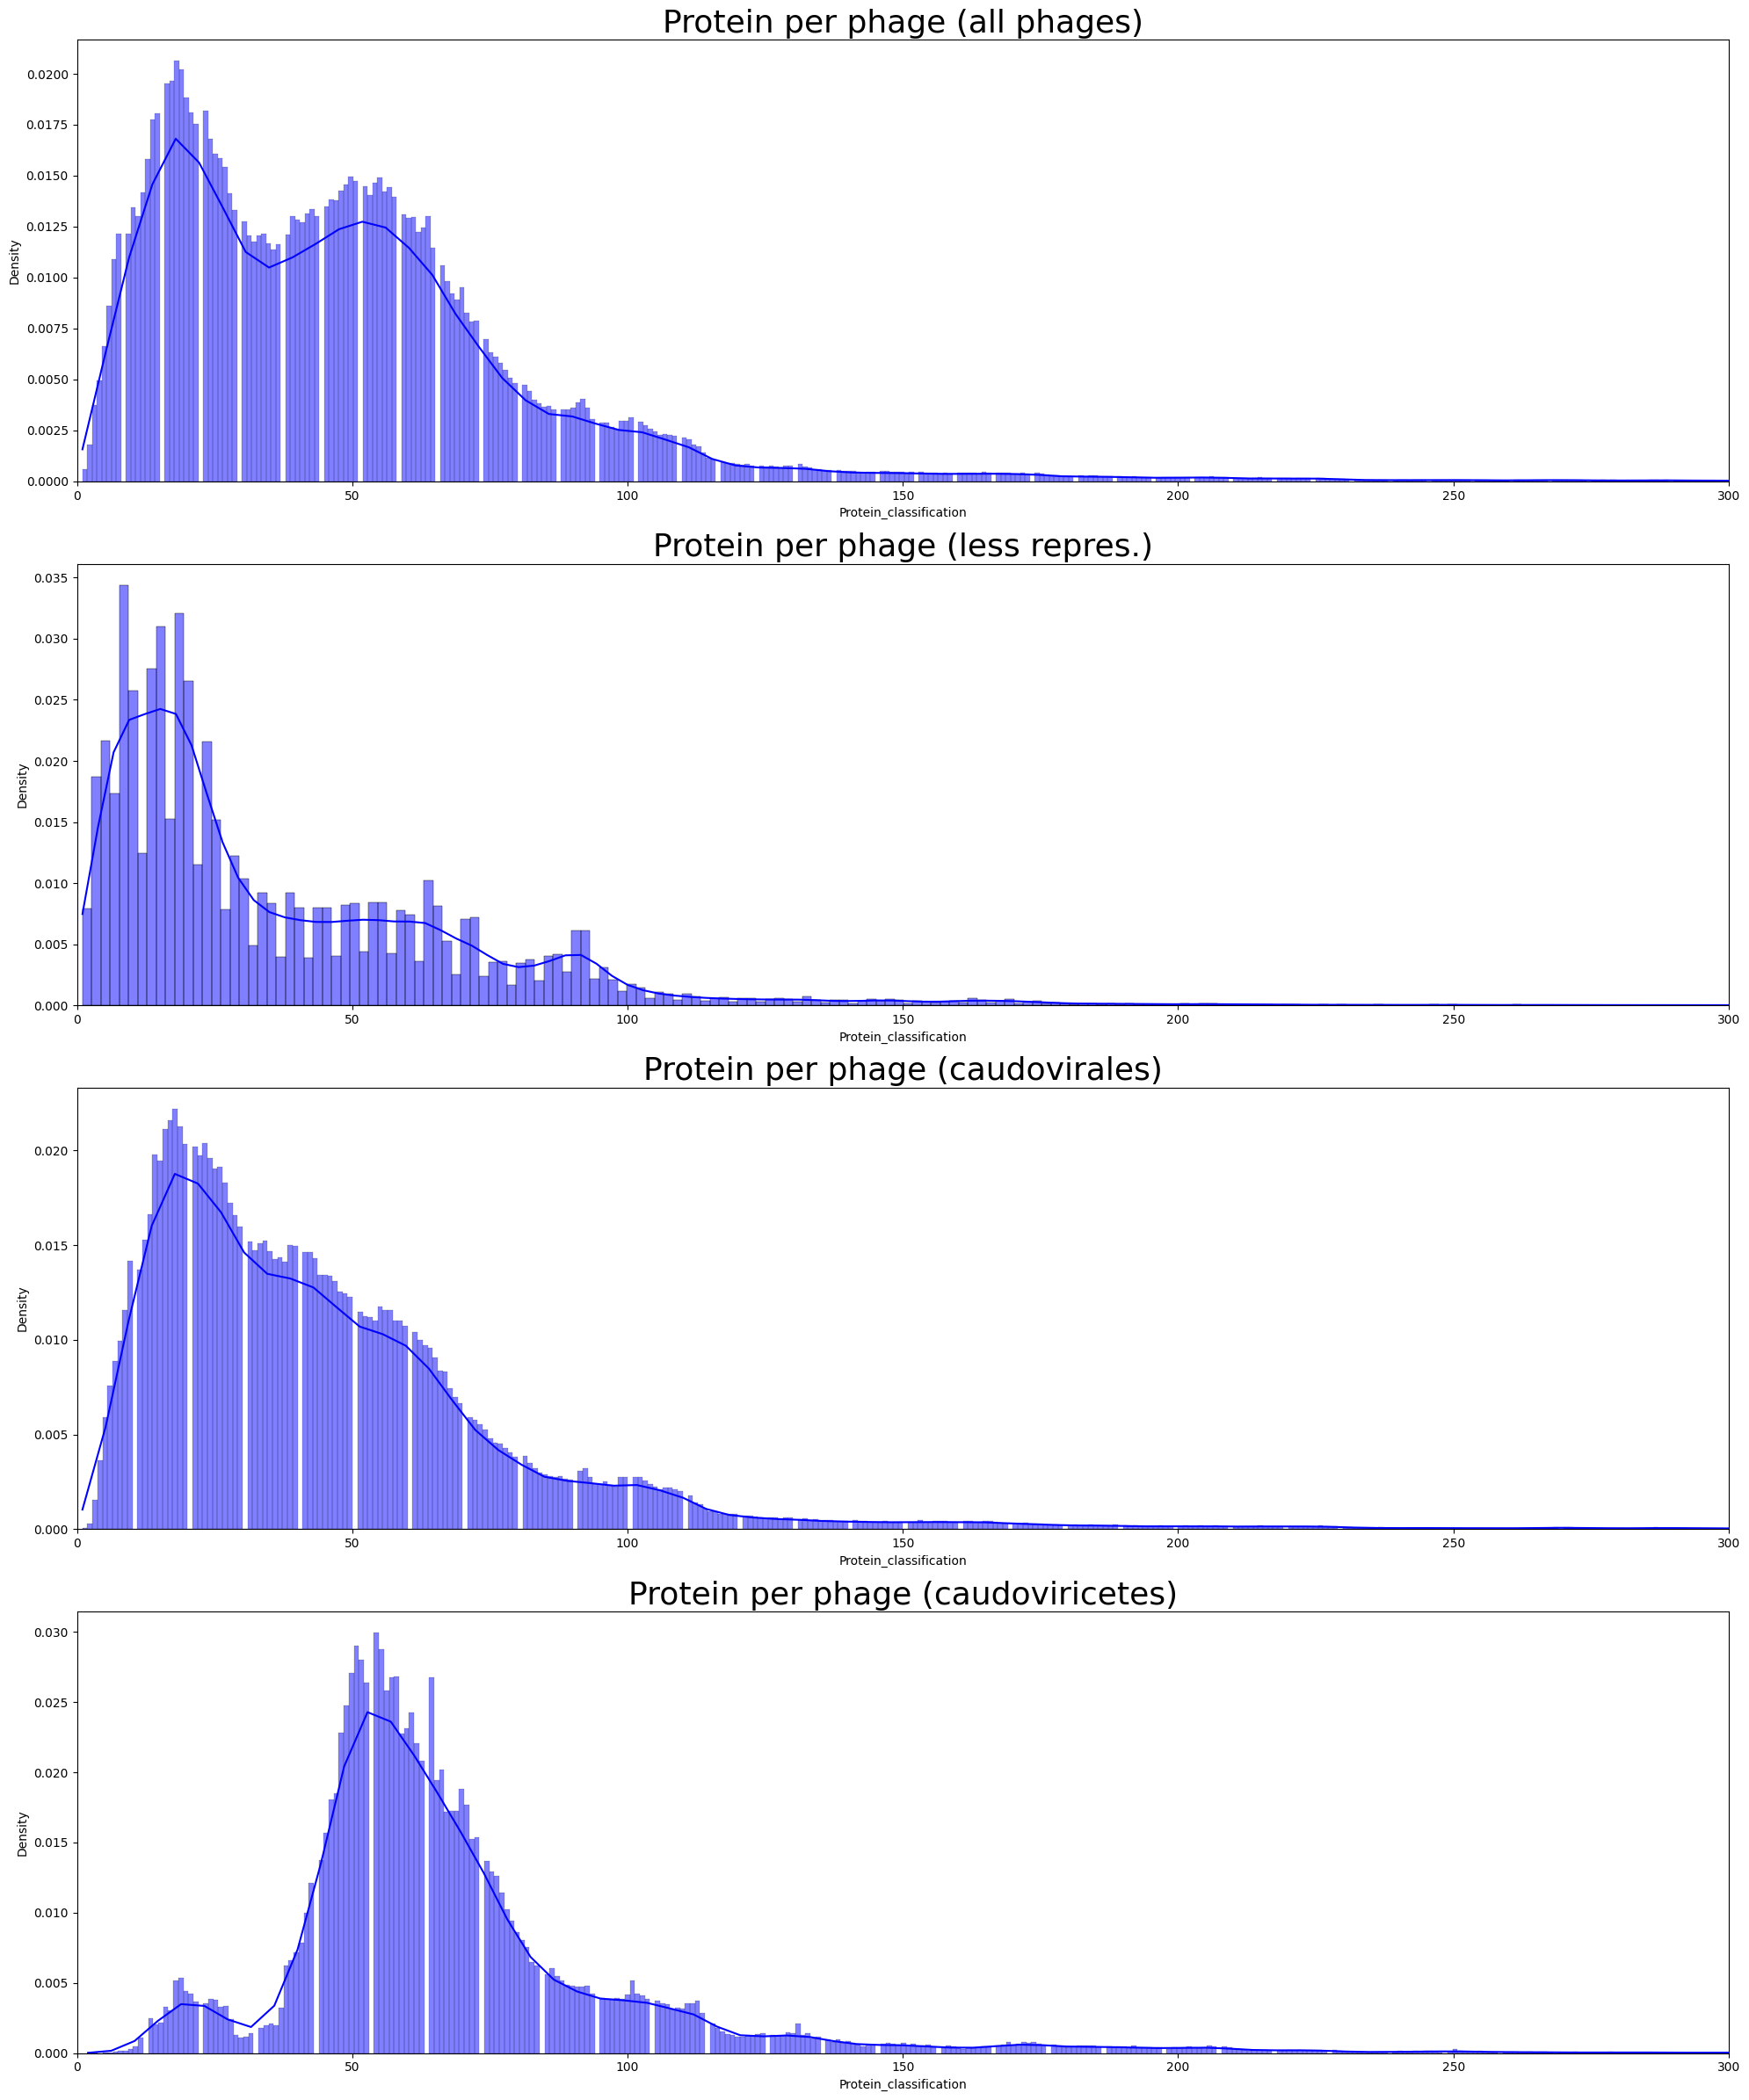

In [21]:

fig, axes = plt.subplots(4, 1, figsize=(20, 24))  # Adjust figure size as needed


sns.histplot(protein_counts_all, kde=True, color='blue',ax=axes[0], stat="density")
axes[0].set_title('Protein per phage (all phages)', fontsize = 26)
axes[0].set_xlim([0, 300])

sns.histplot(protein_counts_else, kde=True, color='blue',ax=axes[1], stat="density")
axes[1].set_title('Protein per phage (less repres.)', fontsize = 26)
axes[1].set_xlim([0, 300])

sns.histplot(protein_counts_caudovirales, kde=True, color='blue',ax=axes[2], stat="density")
axes[2].set_title('Protein per phage (caudovirales)', fontsize = 26)
axes[2].set_xlim([0, 300])

sns.histplot(protein_counts_caudoviricetes, kde=True, color='blue',ax=axes[3], stat="density")
axes[3].set_title('Protein per phage (caudoviricetes)', fontsize = 26)
axes[3].set_xlim([0, 300])

# Adjust layout
plt.tight_layout()

# Save figure as TIFF
plt.savefig('protein_categories_plot.tiff', format='tiff', dpi=300)


# PCA ON LESS REPRESENTED PHAGES

In [24]:
#Load PROTEIN METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\annotated_protein_metadata\*.tsv'  # Use * to select all TSV files in the folder
folder_path = folder_path.replace(os.sep, '/')
start = time.time()
ddf = dd.read_csv(folder_path, sep='\t', dtype={'Instability_index': 'object',
       'Molecular_weight': 'object'})

#Load PHAGE METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\phage_metadata\*.tsv'  # Use a wildcard to select all TSV files
folder_path = folder_path.replace(os.sep, '/')
phage_metadata = dd.read_csv(folder_path, sep='\t')



In [25]:
# create protein dataset of only caudovirales, only caudoviricetes and everything else

#prot_m = ddf[['Phage_ID', 'Start', 'Stop']]
prot_m = ddf[['Phage_ID', 'Molecular_weight', 'Aromaticity', 'Instability_index', 'Isoelectric_point', 'Helix_fraction', 'Turn_fraction', 'Sheet_fraction', 'Reduced_coefficient', 'Oxidized_coefficient']]
phage_m = phage_metadata[['Phage_ID', 'Taxonomy']]


#columns = ['Molecular_weight', 'Aromaticity', 'Instability_index', 'Isoelectric_point', 'Helix_fraction', 'Turn_fraction', 'Sheet_fraction', 'Reduced_coefficient', 'Oxidized_coefficient']

phage_m = phage_m[(phage_m['Taxonomy'] != 'Caudovirales') & (phage_m['Taxonomy'] != 'Caudoviricetes')]


In [26]:
# Step 1: Get the unique Phage_IDs from phage_m that match the taxa
filtered_phage_ids = phage_m[
    (phage_m['Taxonomy'] != 'Caudovirales') & 
    (phage_m['Taxonomy'] != 'Caudoviricetes')
]['Phage_ID'].compute()

# Step 2: Filter prot_m to include only relevant Phage_IDs
prot_m_filtered = prot_m[prot_m['Phage_ID'].isin(filtered_phage_ids)]

# Step 3: Merge the smaller filtered prot_m with phage_m
merged_data = prot_m_filtered.merge(phage_m, on='Phage_ID')


In [5]:
merged_data.compute()

Phage_ID   Molecular_weight  \
0      IMGVR_UViG_3300045988_019579|3300045988|Ga0495...  966.1551000000002   
1      IMGVR_UViG_3300045988_019579|3300045988|Ga0495...          7521.5007   
2      IMGVR_UViG_3300045988_019579|3300045988|Ga0495...  7034.674300000001   
3      IMGVR_UViG_3300045988_019579|3300045988|Ga0495...            1076.16   
4      IMGVR_UViG_3300045988_019579|3300045988|Ga0495...           444.4396   
...                                                  ...                ...   
25011                         SAMN01774031_a1_ct8321_vs1  5900.567100000002   
25012                         SAMN01774031_a1_ct8321_vs1  4831.229500000001   
25013                         SAMN01774031_a1_ct8321_vs1          6014.9082   
25014                         SAMN01774031_a1_ct8321_vs1  6098.881899999998   
25015                         SAMN01774031_a1_ct8321_vs1  843.8765000000001   

       Aromaticity   Instability_index  Isoelectric_point  Helix_fraction  \
0         0.125000              -40.75           8.590880        0.375000   
1         0.140625            64.70625           6.786257        0.328125   
2         0.032258  44.351612903225806           4.612109        0.161290   
3         0.111111  -9.977777777777778           6.282380        0.222222   
4         0.000000  16.460000000000004           5.525000        0.000000   
...            ...                 ...                ...             ...   
25011     0.072727                35.2           6.796432        0.290909   
25012     0.069767   7.009302325581399           4.949790        0.279070   
25013     0.115385   33.57499999999999           9.697157        0.307692   
25014     0.113208   51.98490566037737           8.077389        0.358491   
25015     0.285714   15.42857142857143           4.050028        0.428571   

       Turn_fraction  Sheet_fraction  Reduced_coefficient  \
0           0.125000        0.250000                 1490   
1           0.187500        0.281250                16960   
2           0.193548        0.354839                 6990   
3           0.333333        0.222222                 5500   
4           0.800000        0.200000                    0   
...              ...             ...                  ...   
25011       0.327273        0.200000                 2980   
25012       0.186047        0.162791                 2980   
25013       0.134615        0.250000                 2980   
25014       0.264151        0.113208                 1490   
25015       0.142857        0.000000                    0   

       Oxidized_coefficient      Taxonomy  
0                      1490  Microviridae  
1                     16960  Microviridae  
2                      6990  Microviridae  
3                      5500  Microviridae  
4                         0  Microviridae  
...                     ...           ...  
25011                  2980  Siphoviridae  
25012                  2980  Siphoviridae  
25013                  2980  Siphoviridae  
25014                  1615  Siphoviridae  
25015                     0  Siphoviridae  

[4678345 rows x 11 columns]

In [27]:
merged_data.dtypes

Phage_ID                string[pyarrow]
Molecular_weight        string[pyarrow]
Aromaticity                     float64
Instability_index       string[pyarrow]
Isoelectric_point               float64
Helix_fraction                  float64
Turn_fraction                   float64
Sheet_fraction                  float64
Reduced_coefficient               int64
Oxidized_coefficient              int64
Taxonomy                string[pyarrow]
dtype: object

In [23]:

def find_non_numeric(df):
    # Identify non-numeric values in the 'Instability_index' and 'Molecular_weight' columns
    mask = (~pd.to_numeric(df['Molecular_weight'], errors='coerce').notna()) | \
           (~pd.to_numeric(df['Instability_index'], errors='coerce').notna())
    return df[mask]

# Apply the function to the Dask DataFrame
non_numeric_ddf = merged_data.map_partitions(find_non_numeric)

# Extract the index values where the condition holds
non_numeric_indices = non_numeric_ddf.index.compute()

# Display the indices
print('non_numeric_indices: ')
print(non_numeric_indices)

2024-10-08 16:14:50,466 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9e939f8b0102aa8ef8429006a954702d initialized by task ('hash-join-transfer-9e939f8b0102aa8ef8429006a954702d', 1) executed on worker tcp://127.0.0.1:54149
2024-10-08 16:14:56,275 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 06e3d707be2b77d796106b6489fdc2d5 initialized by task ('hash-join-transfer-06e3d707be2b77d796106b6489fdc2d5', 9) executed on worker tcp://127.0.0.1:54151
2024-10-08 16:16:13,431 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 06e3d707be2b77d796106b6489fdc2d5 deactivated due to stimulus 'task-erred-1728396973.405175'
2024-10-08 16:16:13,435 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9e939f8b0102aa8ef8429006a954702d deactivated due to stimulus 'task-erred-1728396973.405175'
2024-10-08 16:16:13,442 - distributed.core - ERROR - Exception while handling op shuffle_restrict_task
Traceback (most recent call last):
  File "C:\Users\lorenzo\anaconda3\e

ValueError: could not convert string to float: '-': Error while type casting for column 'Molecular_weight'

In [ ]:

# Remove the 63k rows with non float64 values

rows_to_remove_set = set(non_numeric_indices)

def filter_rows(df_partition, rows_to_remove_set):
    return df_partition[~df_partition.index.isin(rows_to_remove_set)]

# Apply the filtering function
filtered_df = ddf.map_partitions(filter_rows, rows_to_remove_set, meta=ddf)

#filtered_df.head()

In [8]:

merged_data = merged_data.astype({'Molecular_weight': 'float64', 'Instability_index': 'float64', 'Reduced_coefficient': 'float64', 'Oxidized_coefficient': 'float64'})



In [20]:
pd.to_numeric(merged_data['Instability_index'], errors='coerce')

Dask Series Structure:
npartitions=181
    float64
        ...
     ...   
        ...
        ...
Dask Name: getitem, 34 expressions
Expr=(Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=AsType(frame=Merge(46241e9), dtypes={'Molecular_weight': 'float64', 'Instability_index': 'float64', 'Reduced_coefficient': 'float64', 'Oxidized_coefficient': 'float64'}))))))))['Instability_index']

In [21]:
merged_data['Molecular_weight'] = merged_data['Molecular_weight'].replace('-', pd.NA)
merged_data['Instability_index'] = merged_data['Instability_index'].replace('-', pd.NA)

filtered_df = merged_data.dropna(subset=['Molecular_weight', 'Instability_index'])


In [22]:
filtered_df.head()

2024-10-08 16:11:05,811 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95bc7d6f485116a2adeca476b130b314 initialized by task ('hash-join-transfer-95bc7d6f485116a2adeca476b130b314', 1) executed on worker tcp://127.0.0.1:54150
2024-10-08 16:11:11,193 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 231d24887eaed416af8575993b9598d9 initialized by task ('hash-join-transfer-231d24887eaed416af8575993b9598d9', 99) executed on worker tcp://127.0.0.1:54149
2024-10-08 16:12:32,537 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 231d24887eaed416af8575993b9598d9 deactivated due to stimulus 'task-finished-1728396752.5363605'
2024-10-08 16:12:32,537 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95bc7d6f485116a2adeca476b130b314 deactivated due to stimulus 'task-finished-1728396752.5363605'


ValueError: could not convert string to float: '-': Error while type casting for column 'Molecular_weight'

In [29]:
merged_data = merged_data.compute()

2024-10-08 16:19:36,875 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9e939f8b0102aa8ef8429006a954702d initialized by task ('hash-join-transfer-9e939f8b0102aa8ef8429006a954702d', 1) executed on worker tcp://127.0.0.1:54150
2024-10-08 16:19:42,578 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 06e3d707be2b77d796106b6489fdc2d5 initialized by task ('hash-join-transfer-06e3d707be2b77d796106b6489fdc2d5', 99) executed on worker tcp://127.0.0.1:54149
2024-10-08 16:21:02,310 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 06e3d707be2b77d796106b6489fdc2d5 deactivated due to stimulus 'task-finished-1728397262.3025699'
2024-10-08 16:21:02,310 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9e939f8b0102aa8ef8429006a954702d deactivated due to stimulus 'task-finished-1728397262.3025699'
2024-10-08 16:21:05,737 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:54149 (pid=13852) exceeded 95% memory budget. Restarting...
2024-10-08 16:21:05

KeyboardInterrupt: 

In [28]:
# Identify non-numeric rows based on 'Molecular_weight' and 'Instability_index'

non_numeric_mask = (~pd.to_numeric(merged_data['Molecular_weight'], errors='coerce').notna()) | \
                   (~pd.to_numeric(merged_data['Instability_index'], errors='coerce').notna())

# Remove the non-numeric rows
filtered_df = merged_data[~non_numeric_mask]

# Display the first few rows of the filtered DataFrame
filtered_df.head()


2024-10-08 16:17:47,990 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b6c4ed0467b10498a18e0ccef5dcd943 initialized by task ('hash-join-transfer-b6c4ed0467b10498a18e0ccef5dcd943', 3) executed on worker tcp://127.0.0.1:54158
2024-10-08 16:17:50,588 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ebce6a9df067aa9509fa132ffbb3bc54 initialized by task ('hash-join-transfer-ebce6a9df067aa9509fa132ffbb3bc54', 162) executed on worker tcp://127.0.0.1:54150
2024-10-08 16:18:42,843 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b6c4ed0467b10498a18e0ccef5dcd943 deactivated due to stimulus 'task-finished-1728397122.8347118'
2024-10-08 16:18:42,843 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ebce6a9df067aa9509fa132ffbb3bc54 deactivated due to stimulus 'task-finished-1728397122.8347118'


AttributeError: 'FloatingArray' object has no attribute 'notna'

In [ ]:




filtered_df.shape

In [55]:
filtered_df = filtered_df.astype({'Molecular_weight': 'float64', 'Instability_index': 'float64', 'Reduced_coefficient': 'float64', 'Oxidized_coefficient': 'float64'})



In [60]:
X = filtered_df[['Molecular_weight', 'Aromaticity', 'Instability_index', 'Isoelectric_point', 'Helix_fraction', 'Turn_fraction', 'Sheet_fraction', 'Reduced_coefficient', 'Oxidized_coefficient', 'Taxonomy']]


In [61]:
X.dtypes

Molecular_weight        float64
Aromaticity             float64
Instability_index       float64
Isoelectric_point       float64
Helix_fraction          float64
Turn_fraction           float64
Sheet_fraction          float64
Reduced_coefficient     float64
Oxidized_coefficient    float64
Taxonomy                 object
dtype: object

In [63]:
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from sklearn.decomposition import PCA
import umap

In [65]:
# Separate the features and the taxonomy column
X_numerical = X.iloc[:, :-1]  # All columns except the last
taxonomy = X['Taxonomy']      # The last column

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numerical)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Taxonomy'] = taxonomy

# Get the explained variance
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.94247306 0.05749474]


In [9]:
# Create a Datashader canvas
canvas = ds.Canvas(plot_width=800, plot_height=400)
agg = canvas.points(pca_df, 'PCA1', 'PCA2', ds.count())
img = tf.shade(agg, cmap=['lightblue', 'blue'], how='log')

#You can map taxonomy to colors here if needed
#taxonomy_colors = {taxonomy: i for i, taxonomy in enumerate(pca_df['Taxonomy'].unique())}
#pca_df['color'] = pca_df['Taxonomy'].map(taxonomy_colors)
#agg = canvas.points(pca_df, 'PCA1', 'PCA2', agg=ds.count_cat('Taxonomy'))
img = tf.shade(agg, cmap='fire', how='log')

# Display the PCA plot
img = tf.set_background(img, "white")  # Set background color
img

NameError: name 'pca_df' is not defined

In [ ]:
# Perform UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_numerical)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_df['taxonomy'] = taxonomy

# Create a Datashader canvas for UMAP
canvas_umap = ds.Canvas(plot_width=800, plot_height=400)
agg_umap = canvas_umap.points(umap_df, 'UMAP1', 'UMAP2', ds.count())
img_umap = tf.shade(agg_umap, cmap='fire', how='log')

# Display the UMAP plot
img_umap = tf.set_background(img_umap, "white")  # Set background color
img_umap


C:\Users\lorenzo\anaconda3\envs\esm\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\lorenzo\anaconda3\envs\esm\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


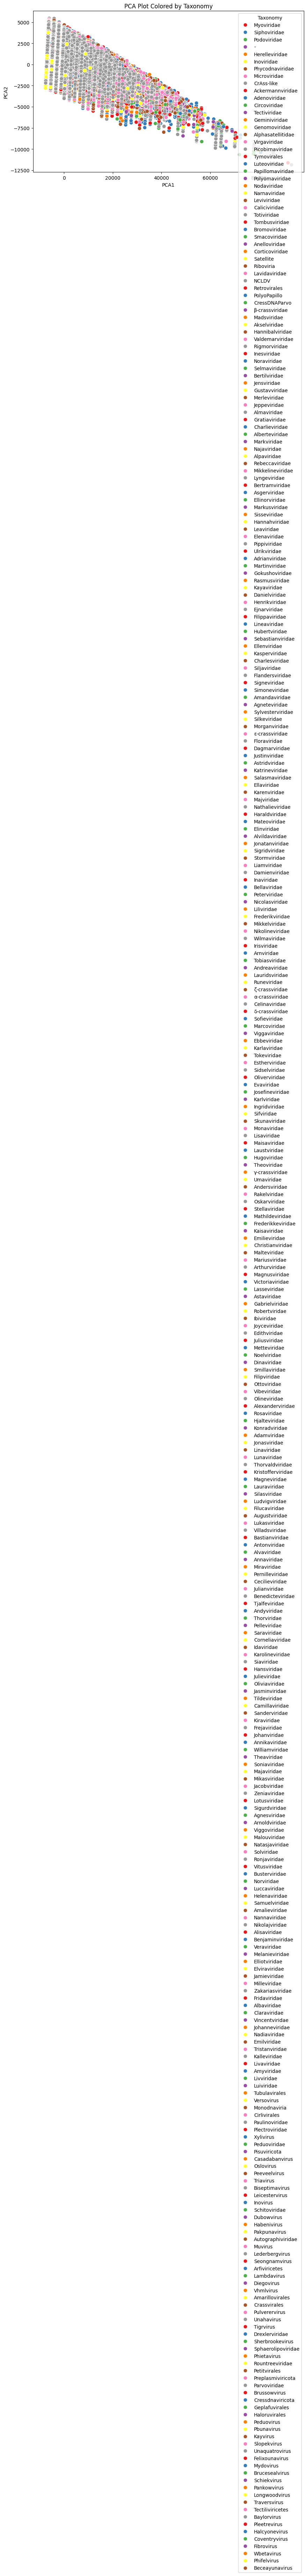

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Separate the features and the taxonomy column
X_numerical = X.iloc[:, :-1]  # All columns except the last
taxonomy = X['Taxonomy']      # The last column

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numerical)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Taxonomy'] = taxonomy

# Plot PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Taxonomy', palette='Set1', s=60)
plt.title('PCA Plot Colored by Taxonomy')
plt.show()


In [ ]:
import umap.umap_ as umap

# Perform UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_numerical)

# Create a DataFrame for plotting
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_df['taxonomy'] = taxonomy

# Plot UMAP
plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='taxonomy', palette='Set1', s=60)
plt.title('UMAP Plot Colored by Taxonomy')
plt.show()
